In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
plt.style.use('seaborn-v0_8')

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# @title Data

# ------------- Plot configuration

palette = sns.color_palette("tab20")

plot_colours = [color for color in palette.as_hex()]
plot_colours80s = ['blue', 'green', 'red', 'orange', 'yellow']

# -------------formatage data

df_odd = pd.read_csv('/content/drive/MyDrive/R/Oddity.csv')

#new Column Success where expected and response key are the same - > 1
#For non mod phones: if expected key matches the key resp = success
#For mod phones: if expected key does not match the key resp = success
success_condition = (((df_odd['ExpectedKey'] != df_odd['key_resp_question3.keys'])) & (df_odd['ModifiedWord'] != df_odd['key_resp_question3.keys']))

df_odd['Success'] = np.where(success_condition, 1, 0)

# ----------------------------- Data df_odd ------------------------
#map to age
age_mapping = {1: '3-17', 2: '18-37', 3: '38 and above'}
df_odd['Age_group'] = df_odd['Age'].map(age_mapping)

#NI is transformed into Northern Ireland (replaces)
df_odd['Country'] = df_odd['Country'].replace('NI', 'Northern Ireland')
#ItemNB is a string
df_odd['ItemNb'] = df_odd['ItemNb'].astype(str)

# Categorize 'Country' into 'Ireland' and 'Other English speaking countries'
df_odd['Country_Categorized'] = df_odd['Country'].apply(lambda x: 'Ireland' if x == 'Ireland' else 'Other English speaking countries')

# -----------------------------------------------------------

#get all the uni conditions (goes to every value in the column and saves the unique values into the list condition)
condition = pd.array(df_odd['Condition1'].unique())

#split the diff conditions in 2 tables
df_mod_T = df_odd[df_odd['Condition1'] == condition[0]]
df_mod_SH = df_odd[df_odd['Condition1'] == condition[1]]


print('Data initilised')


Data initilised


In [66]:
# @title Definition of usefull functions

def plot_success_rate_by_parameter(df, x, groupBy, xlabel, ylabel, title, colours = plot_colours):

  grouped = df.groupby(groupBy)

  # Calculate success rate
  success_rate = 100*grouped['Success'].sum() / grouped['Success'].count()

  # Plot histogram
  plt.bar(success_rate.index, success_rate.values, color=colours)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title + x)
  plt.ylim(0,100)

  display_text_size = 6
  for i in range(len(success_rate)):
    plt.text(i, success_rate[i], str(success_rate[i])[:display_text_size], ha='center', va='bottom')

  plt.show()


def plot_bar_average_parameter(df_odd, group_by, xlabel, ylabel, title, condition = ''):

  # Group the data by 'group_by' and calculate the mean of 'condition'
  average_data = df_odd.groupby(group_by)

  if condition != '':
    average_data = average_data[condition]

  average_data = average_data.mean()

  # Create the line graph
  average_data.plot(kind='bar', figsize=(25, 15))

  # Set the title and labels
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  display_text_size = 4
  for i in range(len(average_data)):
    plt.text(i, average_data[i], str(average_data[i])[:display_text_size], ha='center', va='bottom')

  # Show the plot
  plt.show()


# we create a function in which we give the headers and the data manually. Aims at making a plot
# we need as many elements in the headers as in data.
# for example : headers = ['title1', 'title2']
#               data = ['25', 'numbers']
def plot_2d_array(headers, data, xlabel, ylabel, title, display_text_size = 6, colours = plot_colours, fig_size = ''):

  if fig_size != '':
    plt.figure(figsize=fig_size)

  plt.bar(headers, data, color=colours)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.ylim(0, 100)

  for i in range(len(data)):
    plt.text(i, data[i], str(data[i])[:display_text_size], ha='center', va='bottom')

  plt.show()

#------------------------------------plot REPLAY-----------------------------
def plot_replay(df, x, group_by, title, xlabel):

    grouped = df.groupby(group_by)

    # Calculate success rate
    replay_rate = grouped['Replay'].sum()
    print(replay_rate)

    # Plot histogram (the figure at the bottom)
    plt.figure(figsize=(25, 15))
    plt.bar(replay_rate.index, replay_rate.values)
    plt.xlabel(xlabel,size=20)
    plt.ylabel('Number of replays',size=20)
    plt.title(title + x,size=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

#---------------------statistical tests----------------------------

def do_ttest(val1, val2):

  print("---- Performing Ttest ----")
  # Perform independent samples t-test
  t_statistic, p_value = stats.ttest_ind(val1, val2)

  # Interpret the results
  alpha = 0.05
  if p_value < alpha:
      print("Reject the null hypothesis. There is a significant difference between the means.")
  else:
      print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

  # Print the t-statistic and p-value
  print("t-statistic:", t_statistic)
  print("p-value:", p_value)
  print("")

def do_anova_test(data):

  print("---- Performing ANOVA test ----")
  # Perform ANOVA test
  f_statistic, p_value = stats.f_oneway(*data)

  # Interpret the results
  alpha = 0.05
  if p_value < alpha:
      print("Reject the null hypothesis. There is a significant difference between at least one pair of means.")
  else:
      print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

  # Print the F-statistic and p-value
  print("F-statistic:", f_statistic)
  print("p-value:", p_value)
  print("")


print('Functions defined')

Functions defined


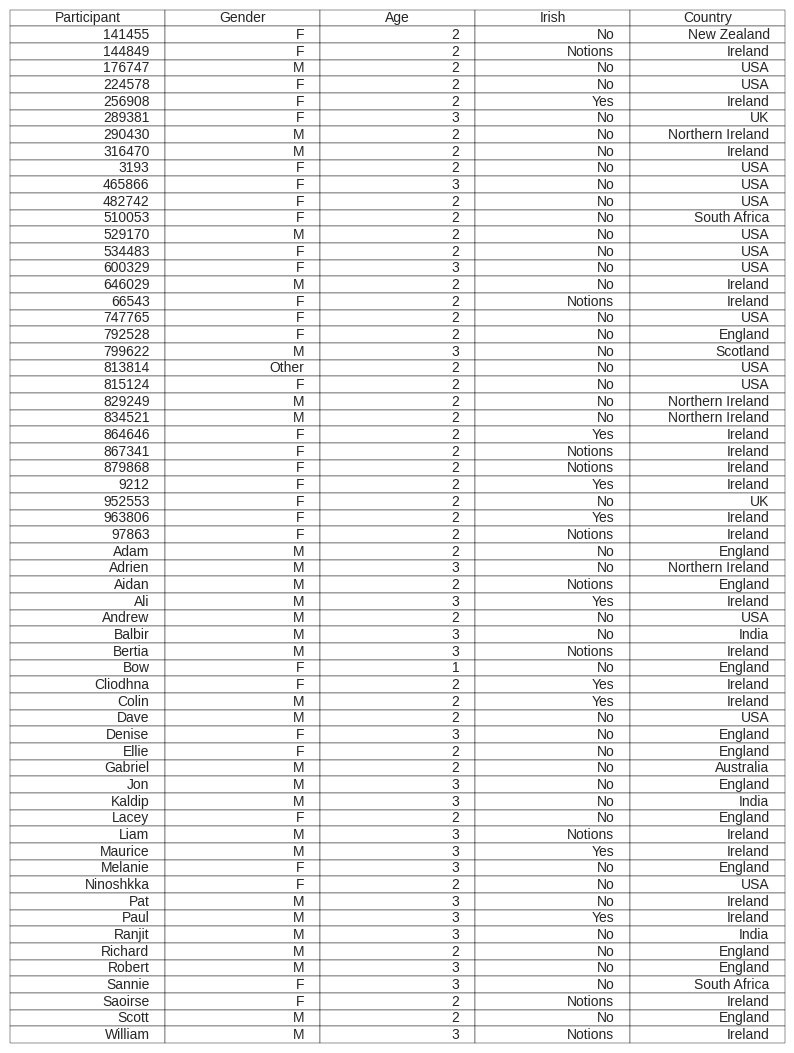

In [5]:
# @title TABLE PARTICIPANTS
# Group by 'Participant' and select the first row of each group
unique_participants_df = df_odd.groupby('Participant').first().reset_index()

# Select the columns you want
selected_columns = ['Participant', 'Gender', 'Age', 'Irish', 'Country']

# Create a new DataFrame with only the selected columns
table_df = unique_participants_df[selected_columns]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes
ax.axis('off')

# Plot the table
table = ax.table(cellText=table_df.values,
                 colLabels=table_df.columns,
                 loc='center')

# Adjust the font size
table.auto_set_font_size(False)
table.set_fontsize(10)

# Save the figure as an image
plt.savefig('participant_table.png', bbox_inches='tight')


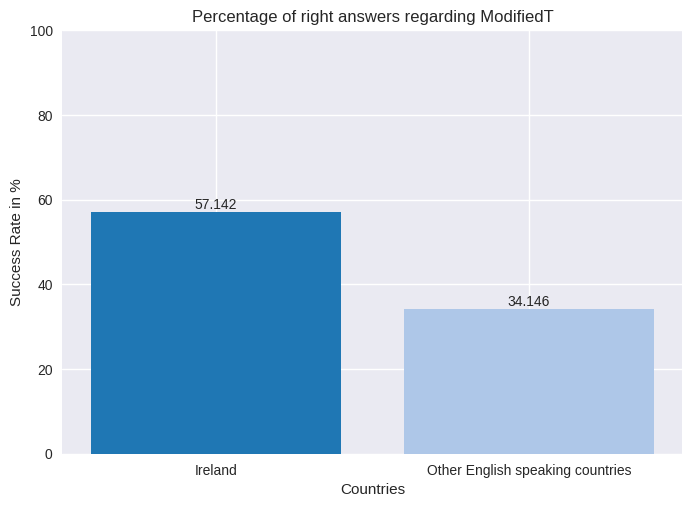

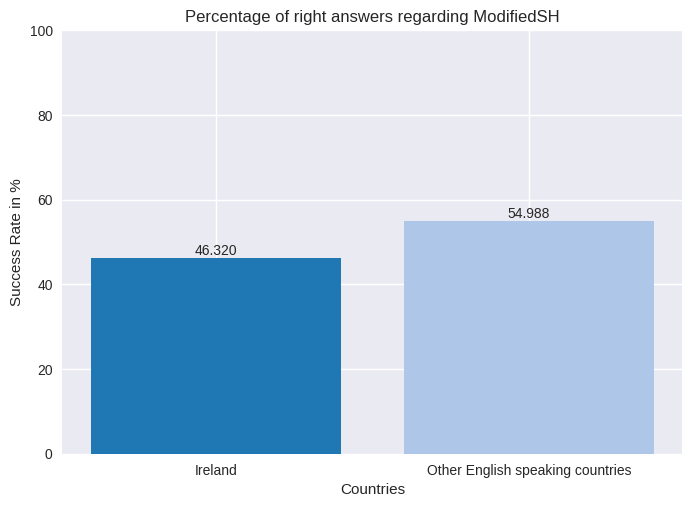

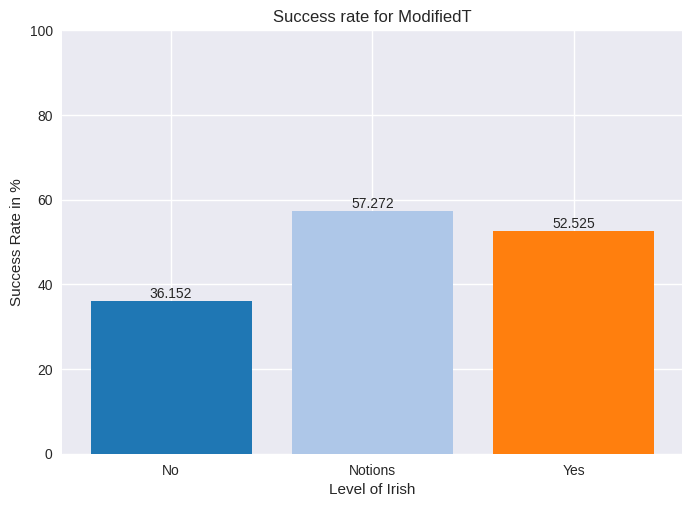

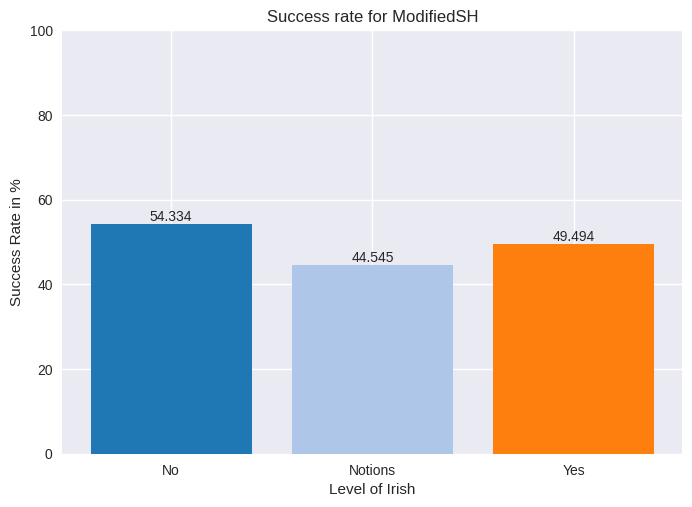

level of Irish yes vs no vs notions
---- Performing ANOVA test ----
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 210.9627376027649
p-value: 6.383466893214089e-88



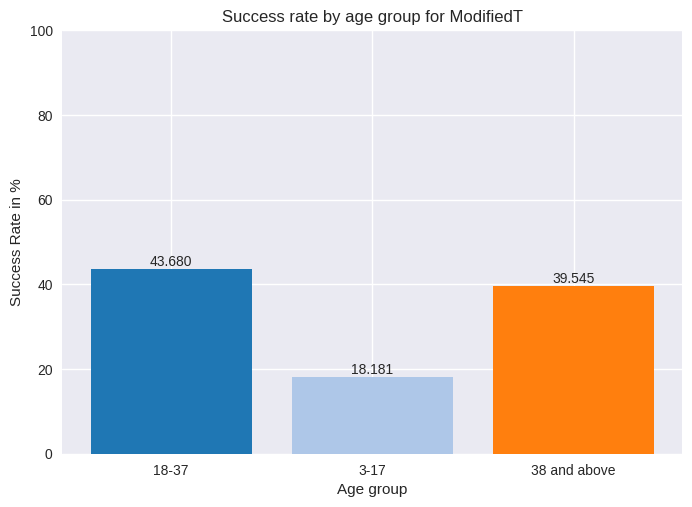

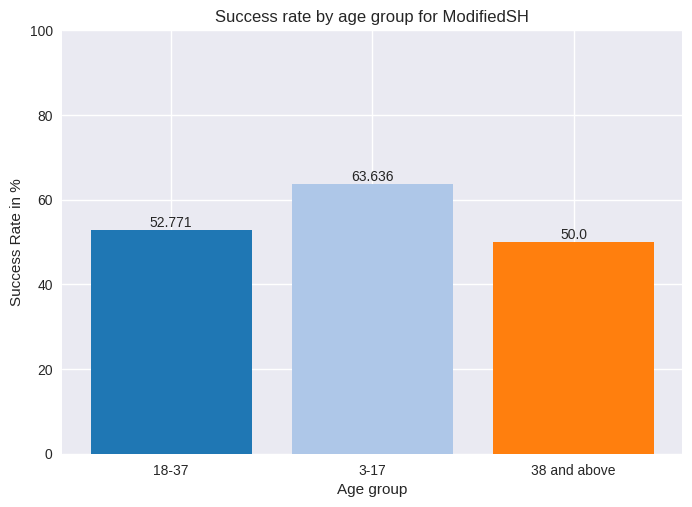

age1 vs age2 vs age3
---- Performing ANOVA test ----
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 288.3985150315145
p-value: 6.796696428450012e-118



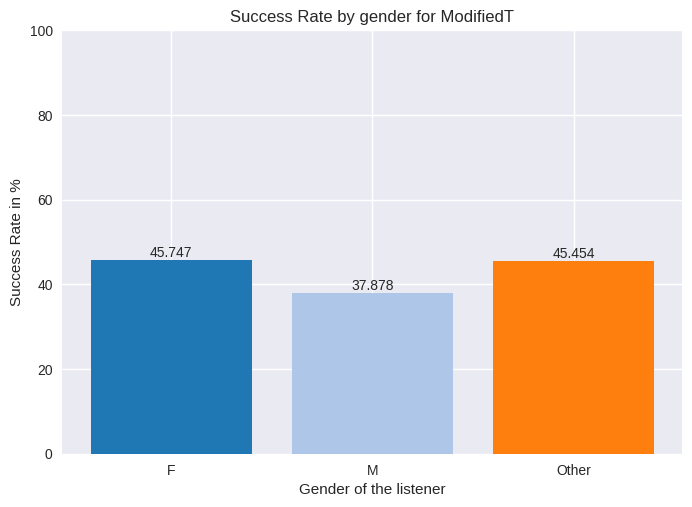

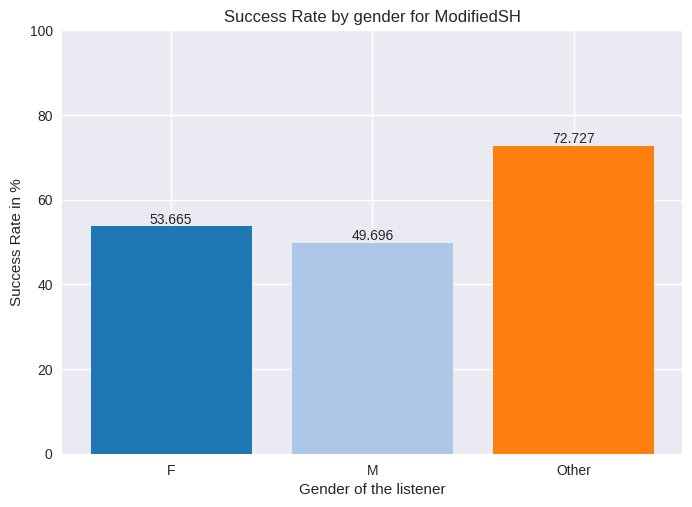

F vs M listeners
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: 2.2753881366099225
p-value: 0.022959955266605558



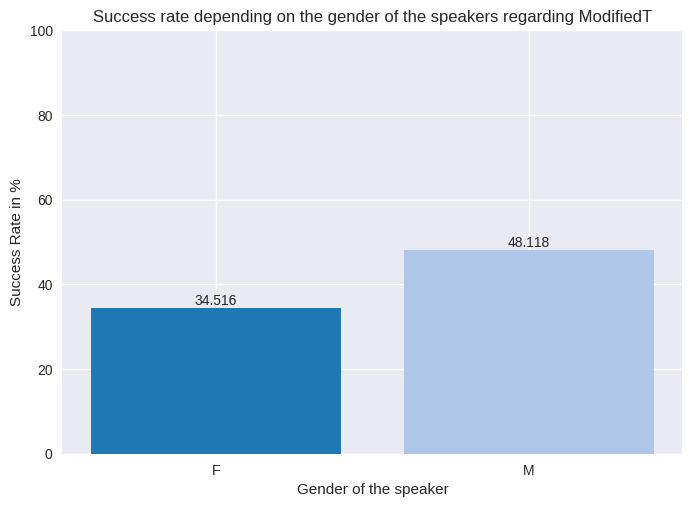

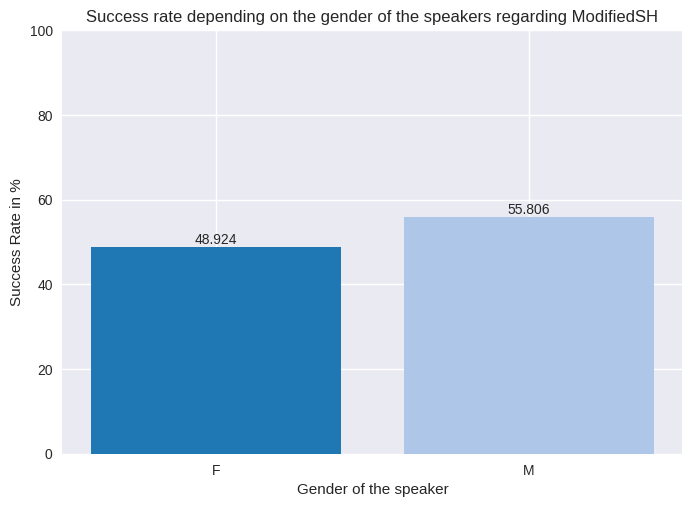

F vs M speakers
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -2.848121054300769
p-value: 0.004430769718486549



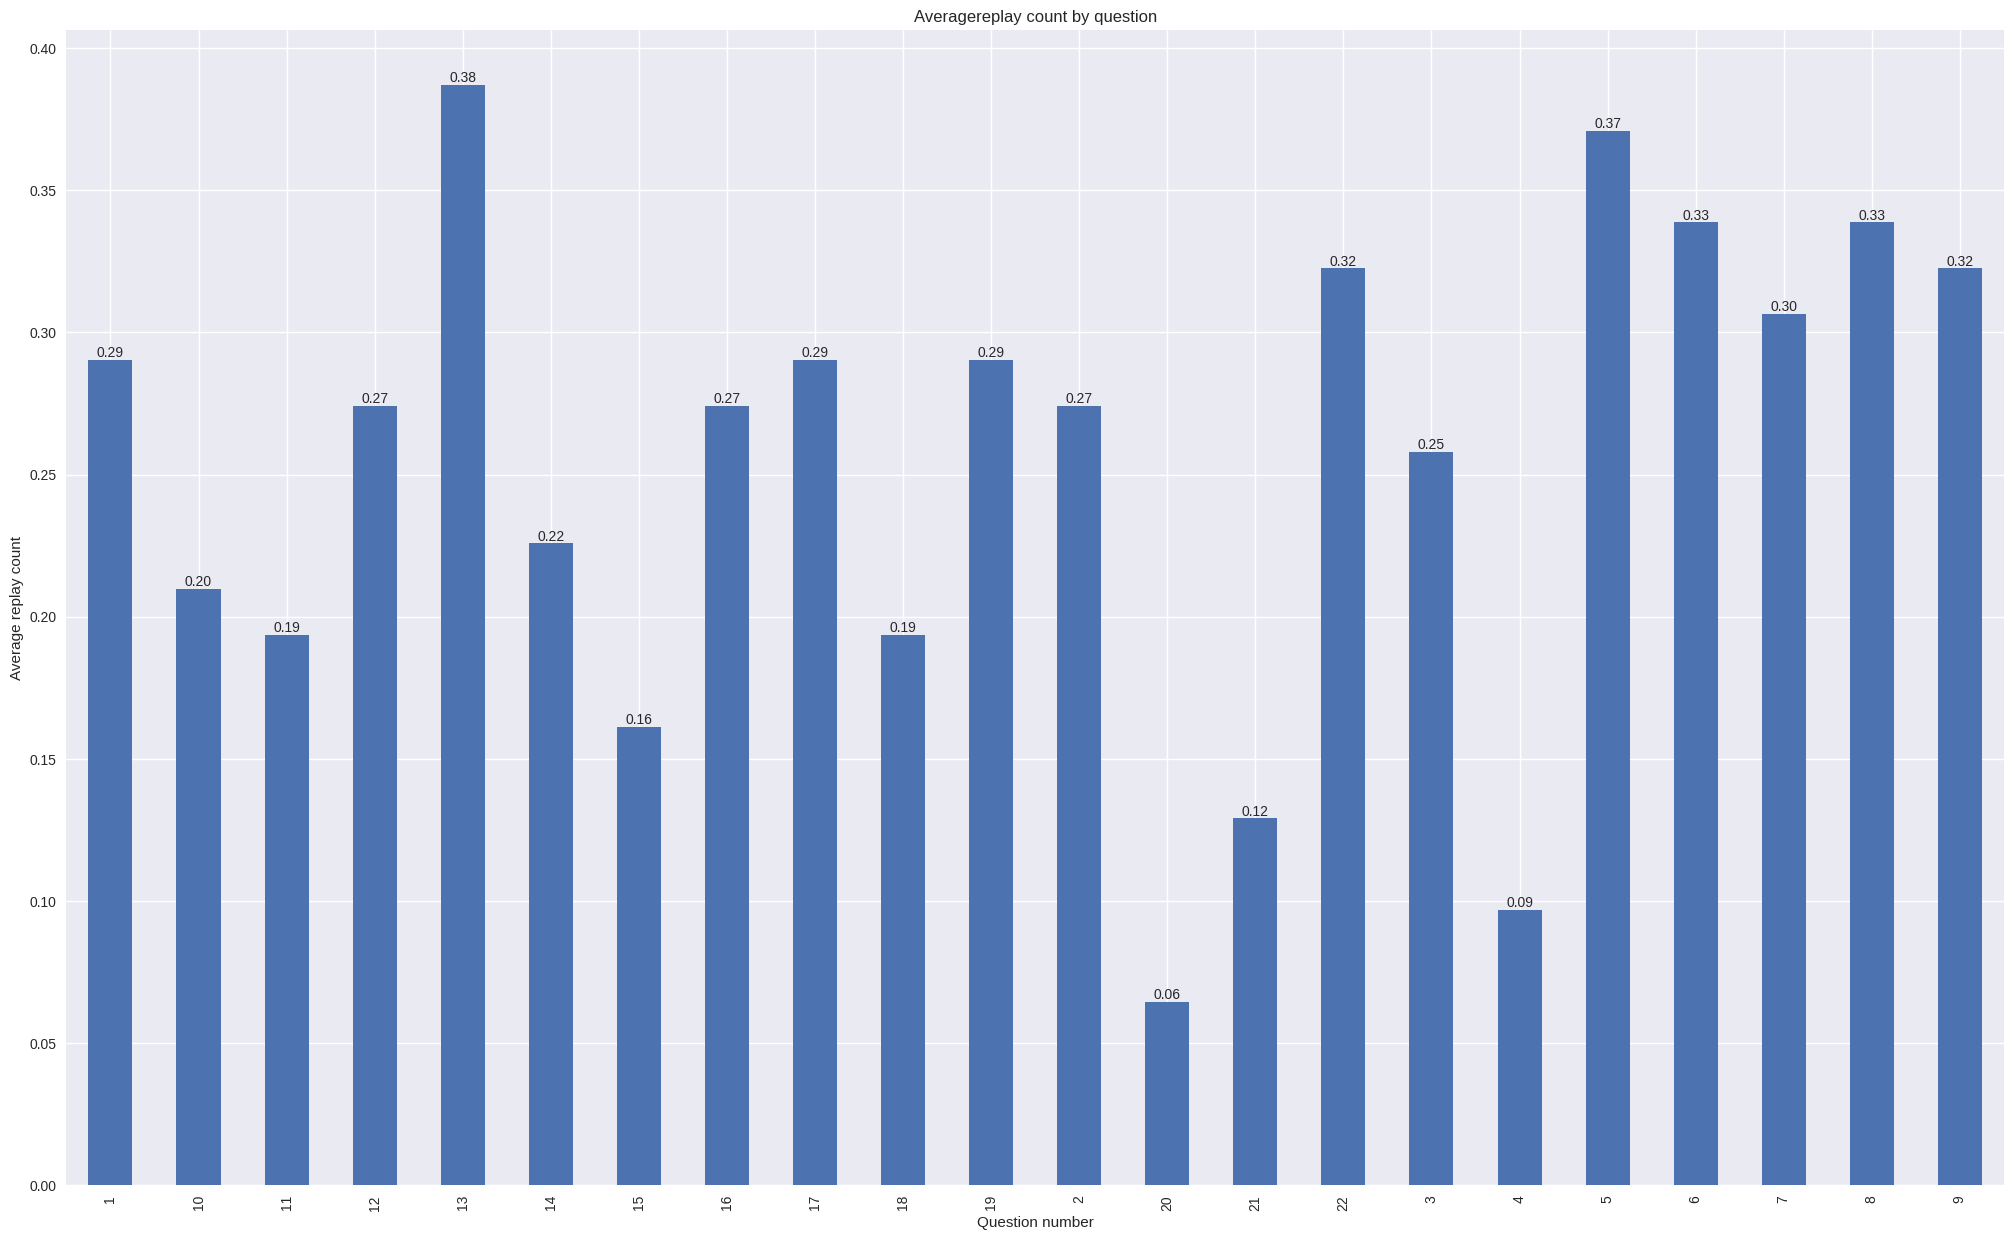

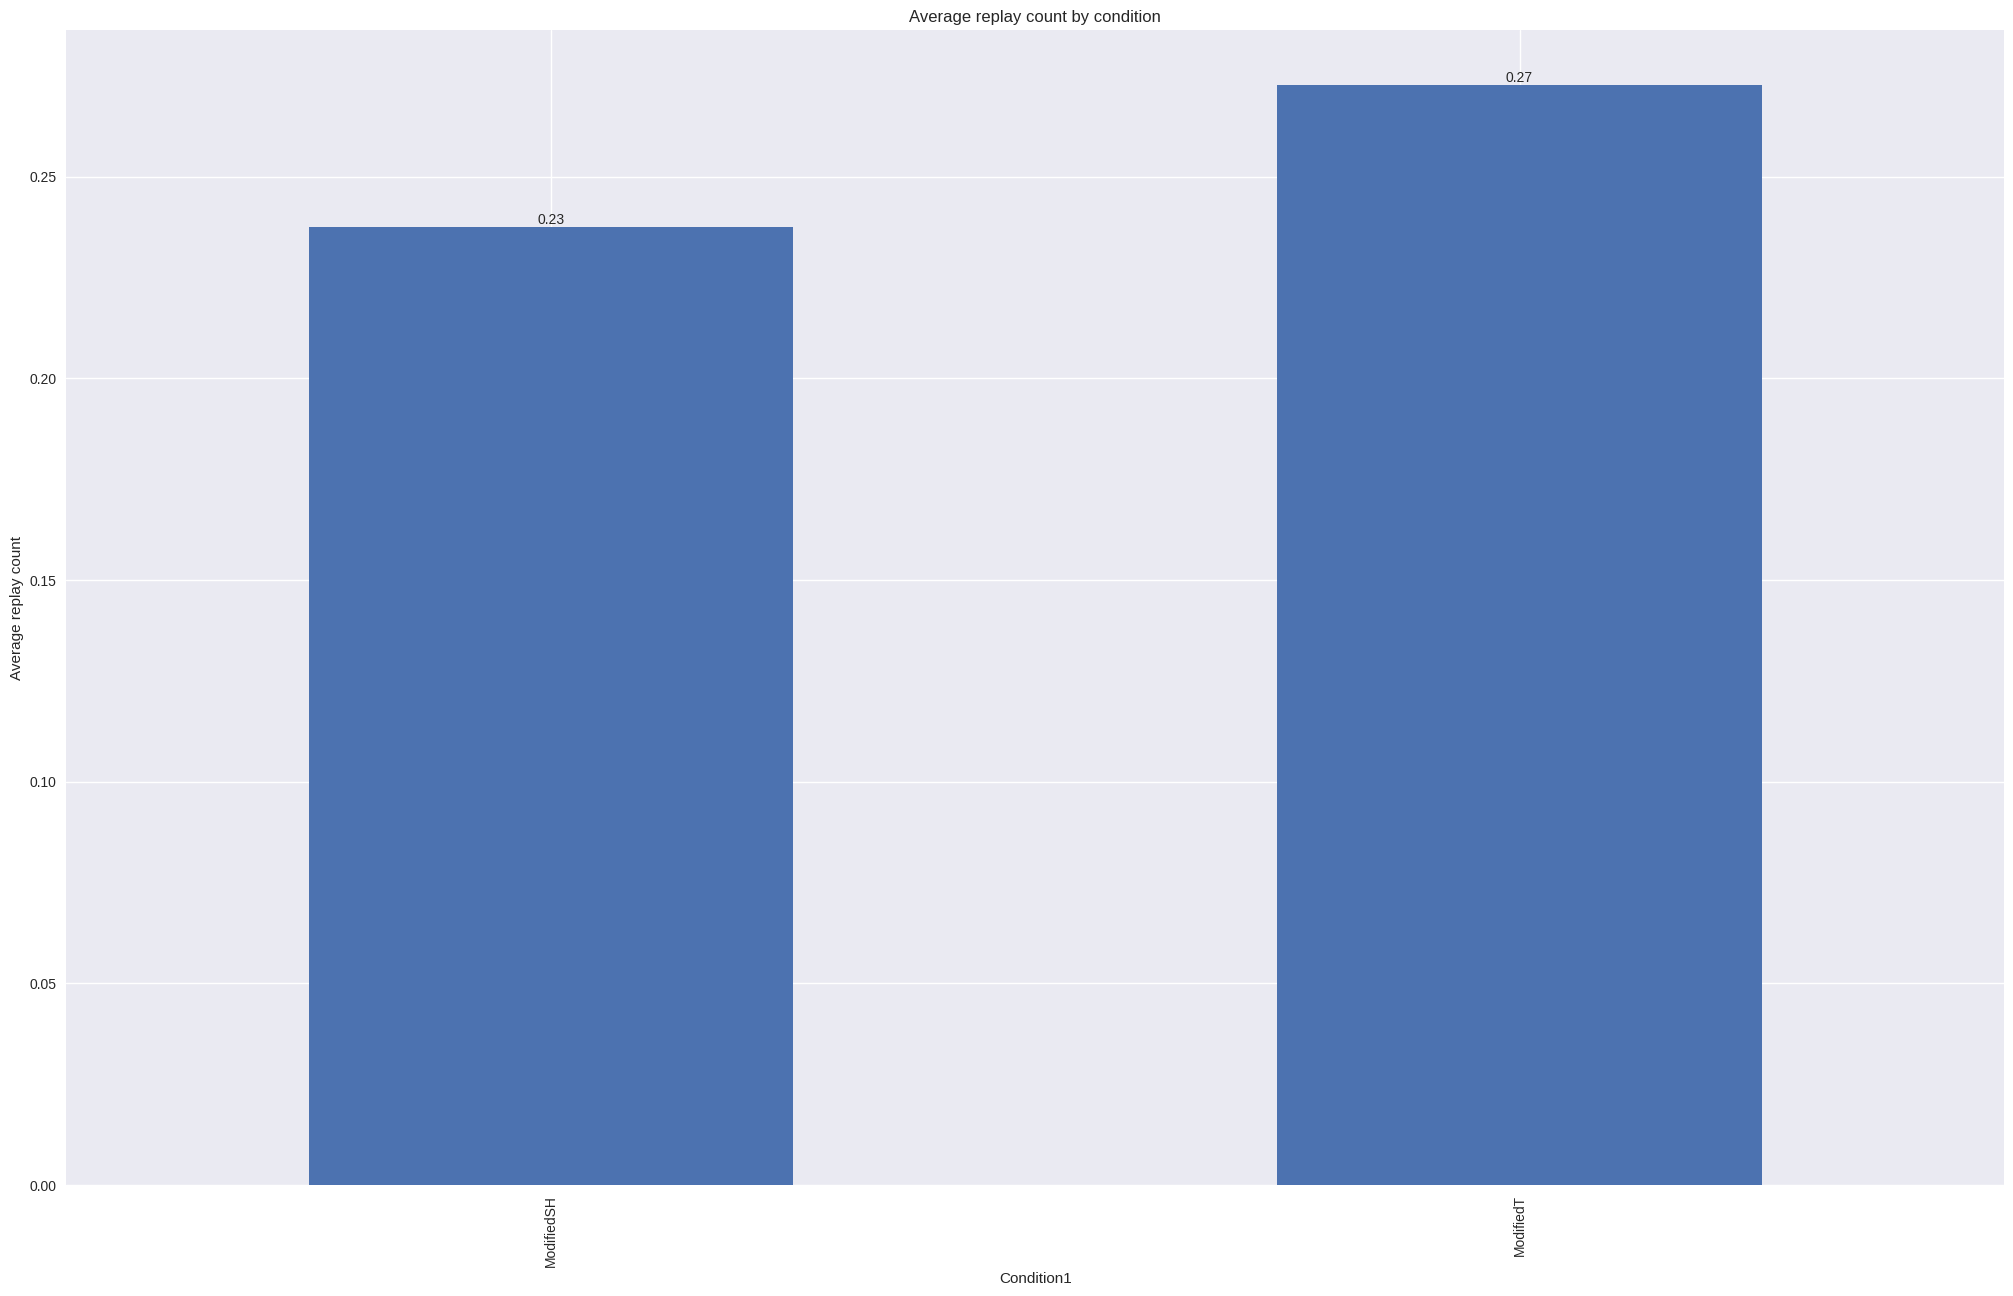

If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.
Pearson correlation coefficient between Success and Replay count: -0.04670495570255967

Modified T
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -17.51190071541826
p-value: 5.529474647061298e-53

Modified SH
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -14.08785796121908
p-value: 9.999092081936858e-38



In [ ]:
# @title ALL PARTICIPANTS

# view beginning of the table
df_odd.head()

#------------By COUNTRY------------------------------------------------------------------------------------------------------------------------------------------------------------
#go into list condition and take the value x
for x in condition:
    df = df_odd[df_odd['Condition1'] == x]
    # plot_success_rate_by_country(df,x)
    plot_success_rate_by_parameter(df, x, 'Country_Categorized', 'Countries', 'Success Rate in %',  'Percentage of right answers regarding ')

#------------By LEVEL OF IRISH-----------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = df_odd[df_odd['Condition1'] == x]
    plot_success_rate_by_parameter(df, x, 'Irish', 'Level of Irish', 'Success Rate in %',  'Success rate for ')


print('level of Irish yes vs no vs notions')
val1 = ((df_odd['Success'] == 1) & (df_odd['Irish'] == 'Yes'))
val2 = ((df_odd['Success'] == 1) & (df_odd['Irish'] == 'No'))
val3 = ((df_odd['Success'] == 1) & (df_odd['Irish'] == 'Notions'))

do_anova_test([val1, val2, val3])

#------------By AGE----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = df_odd[df_odd['Condition1'] == x]
    plot_success_rate_by_parameter(df, x, 'Age_group', 'Age group', 'Success Rate in %',  'Success rate by age group for ')


print('age1 vs age2 vs age3')

val1 = ((df_odd['Success'] == 1) & (df_odd['Age'] == 1))
val2 = ((df_odd['Success'] == 1) & (df_odd['Age'] == 2))
val3 = ((df_odd['Success'] == 1) & (df_odd['Age'] == 3))

do_anova_test([val1, val2, val3])

#------------By GENDER----------------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = df_odd[df_odd['Condition1'] == x]
    plot_success_rate_by_parameter(df, x, 'Gender', 'Gender of the listener', 'Success Rate in %',  'Success Rate by gender for ')


print('F vs M listeners')
val1 = ((df_odd['Success'] == 1) & (df_odd['Gender'] == 'F'))
val2 = ((df_odd['Success'] == 1) & (df_odd['Gender'] == 'M'))
do_ttest(val1, val2)

#------------By GENDER of the speaker

for x in condition:
    df = df_odd[df_odd['Condition1'] == x]
    plot_success_rate_by_parameter(df, x, 'Condition2', 'Gender of the speaker', 'Success Rate in %',  'Success rate depending on the gender of the speakers regarding ')

print('F vs M speakers')
val1 = ((df_odd['Success'] == 1) & (df_odd['Condition2'] == 'F'))
val2 = ((df_odd['Success'] == 1) & (df_odd['Condition2'] == 'M'))
do_ttest(val1, val2)

#------------Average replay By question-----------------------------------------------------------------------------------------------------------------------------------------

plot_bar_average_parameter(df_odd, 'ItemNb', 'Question number', 'Average replay count', 'Average replay count by question', 'Replay')

#------------Average reaction time in s By condition----------------------------------------------------------------------------------------------------------------------------

plot_bar_average_parameter(df_odd, 'Condition1', 'Condition', 'Average replay count', 'Average replay count by condition', 'Replay')


# ----------------------------Calculate Pearson correlation coefficient

correlation = df_odd['Success'].corr(df_odd['Replay'])

print("If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.")

print("Pearson correlation coefficient between Success and Replay count:", correlation)

print("")


#---------------ttest IRISH vs OTHERS----------------------------------------------------------------------------------------------------------------------------------------------

All_filtered_df_odd_mod_t = df_mod_T.loc[df_mod_T['Country'].isin(['Ireland', 'Other English speaking countries'])]
All_filtered_df_odd_mod_sh = df_mod_SH.loc[df_mod_SH['Country'].isin(['Ireland', 'Other English speaking countries'])]

print('Modified T')
val1 = ((All_filtered_df_odd_mod_t['Success'] == 1) & (All_filtered_df_odd_mod_t['Country'] == 'Other English speaking countries'))
val2 = ((All_filtered_df_odd_mod_t['Success'] == 1) & (All_filtered_df_odd_mod_t['Country'] == 'Ireland'))
do_ttest(val1, val2)

print('Modified SH')
val1 = ((All_filtered_df_odd_mod_sh['Success'] == 1) & (All_filtered_df_odd_mod_sh['Country'] == 'Other English speaking countries'))
val2 = ((All_filtered_df_odd_mod_sh['Success'] == 1) & (All_filtered_df_odd_mod_sh['Country'] == 'Ireland'))
do_ttest(val1, val2)



[57.142857142857146, 46.32034632034632]


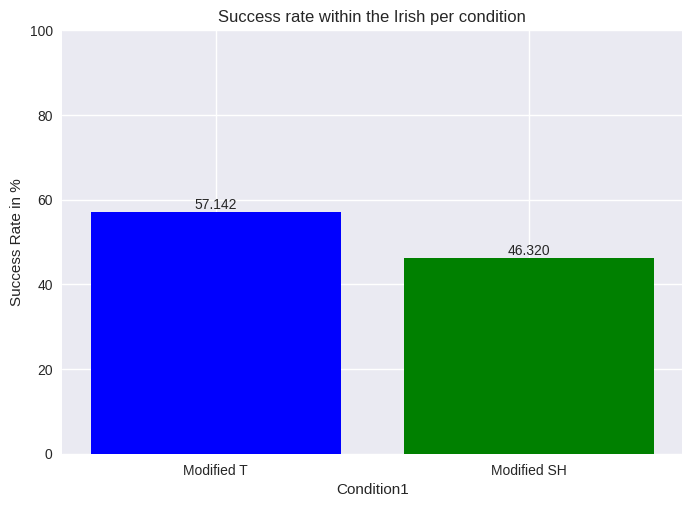

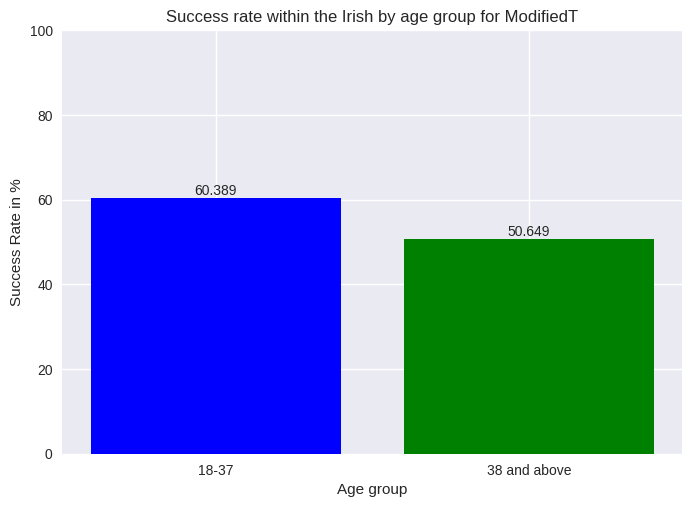

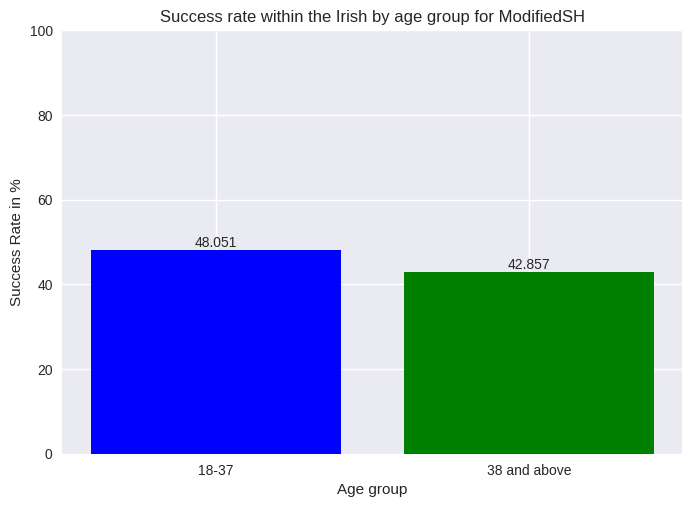

age2 vs age3
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: 7.334287770642238
p-value: 4.879445344665832e-13



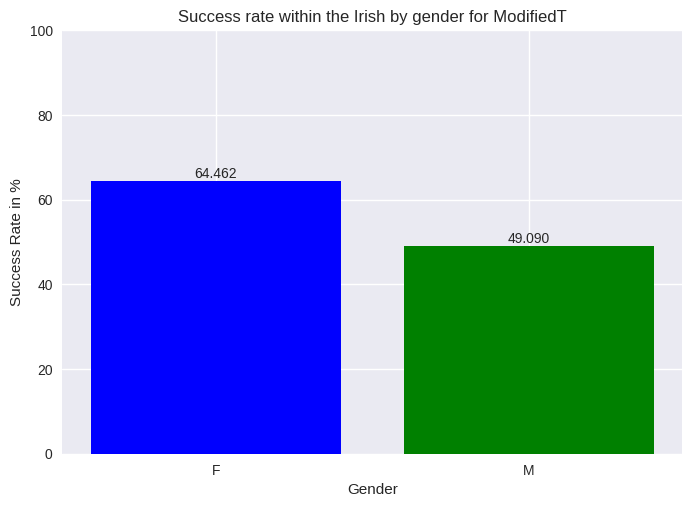

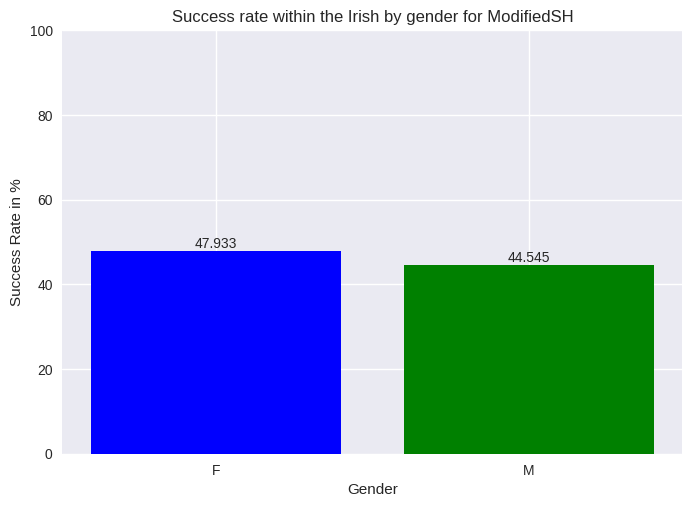

age2 vs age3
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: 2.484759789742505
p-value: 0.013140340347494433



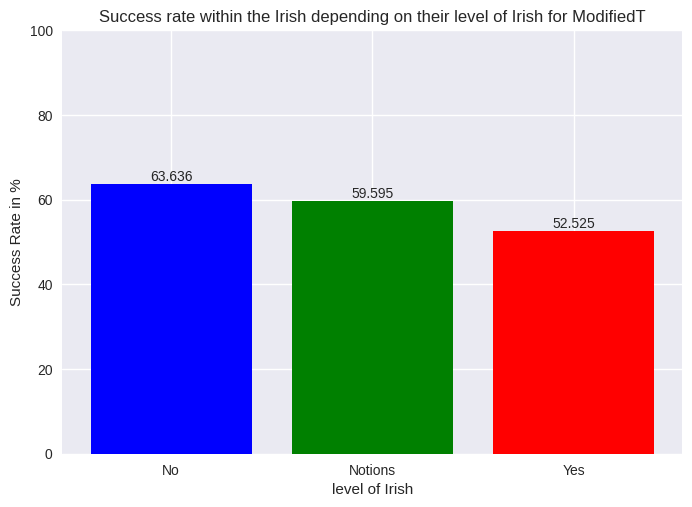

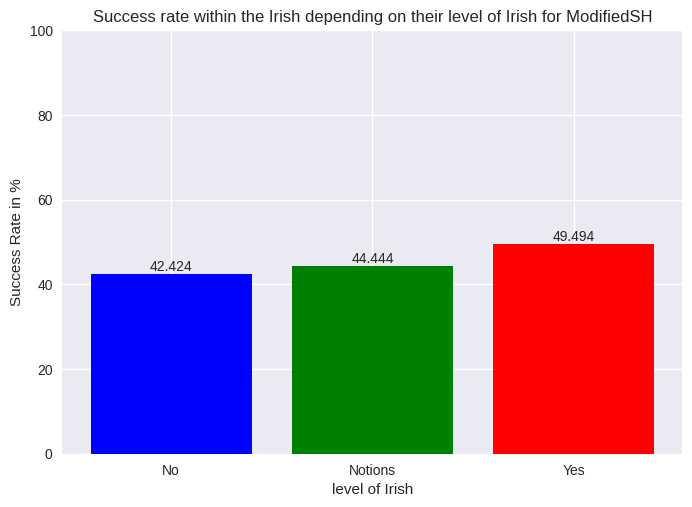

---- Performing ANOVA test ----
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 23.42998087867576
p-value: 9.841890814462884e-11



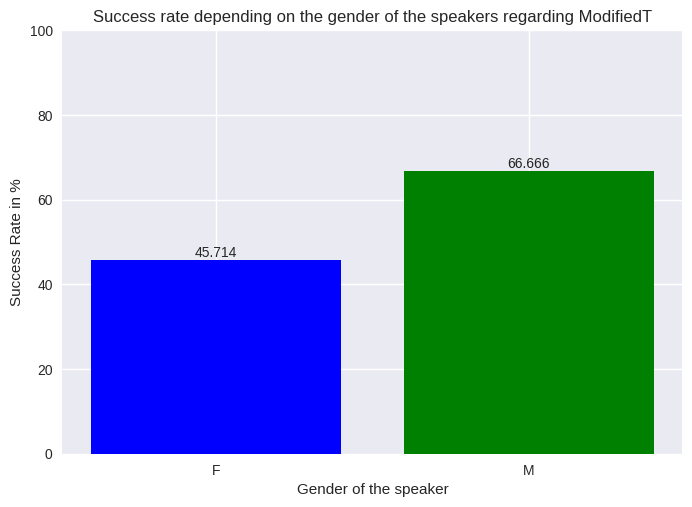

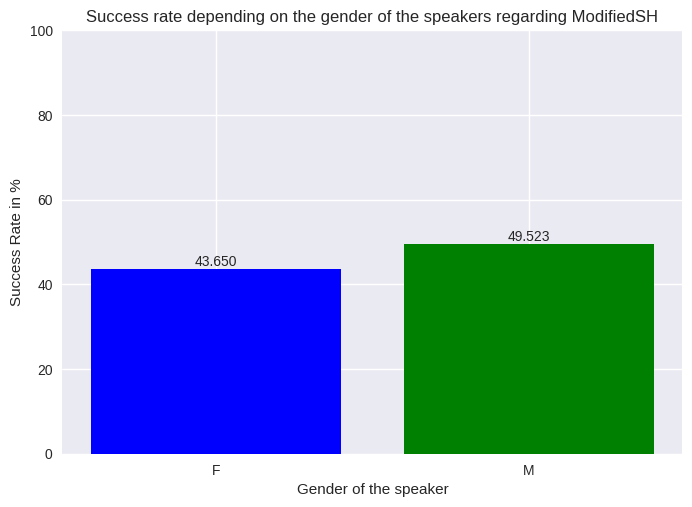

---- Performing ANOVA test ----
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 6.174031212721212
p-value: 0.013140340347500782

age2 vs age3
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -2.484759789742505
p-value: 0.013140340347494433



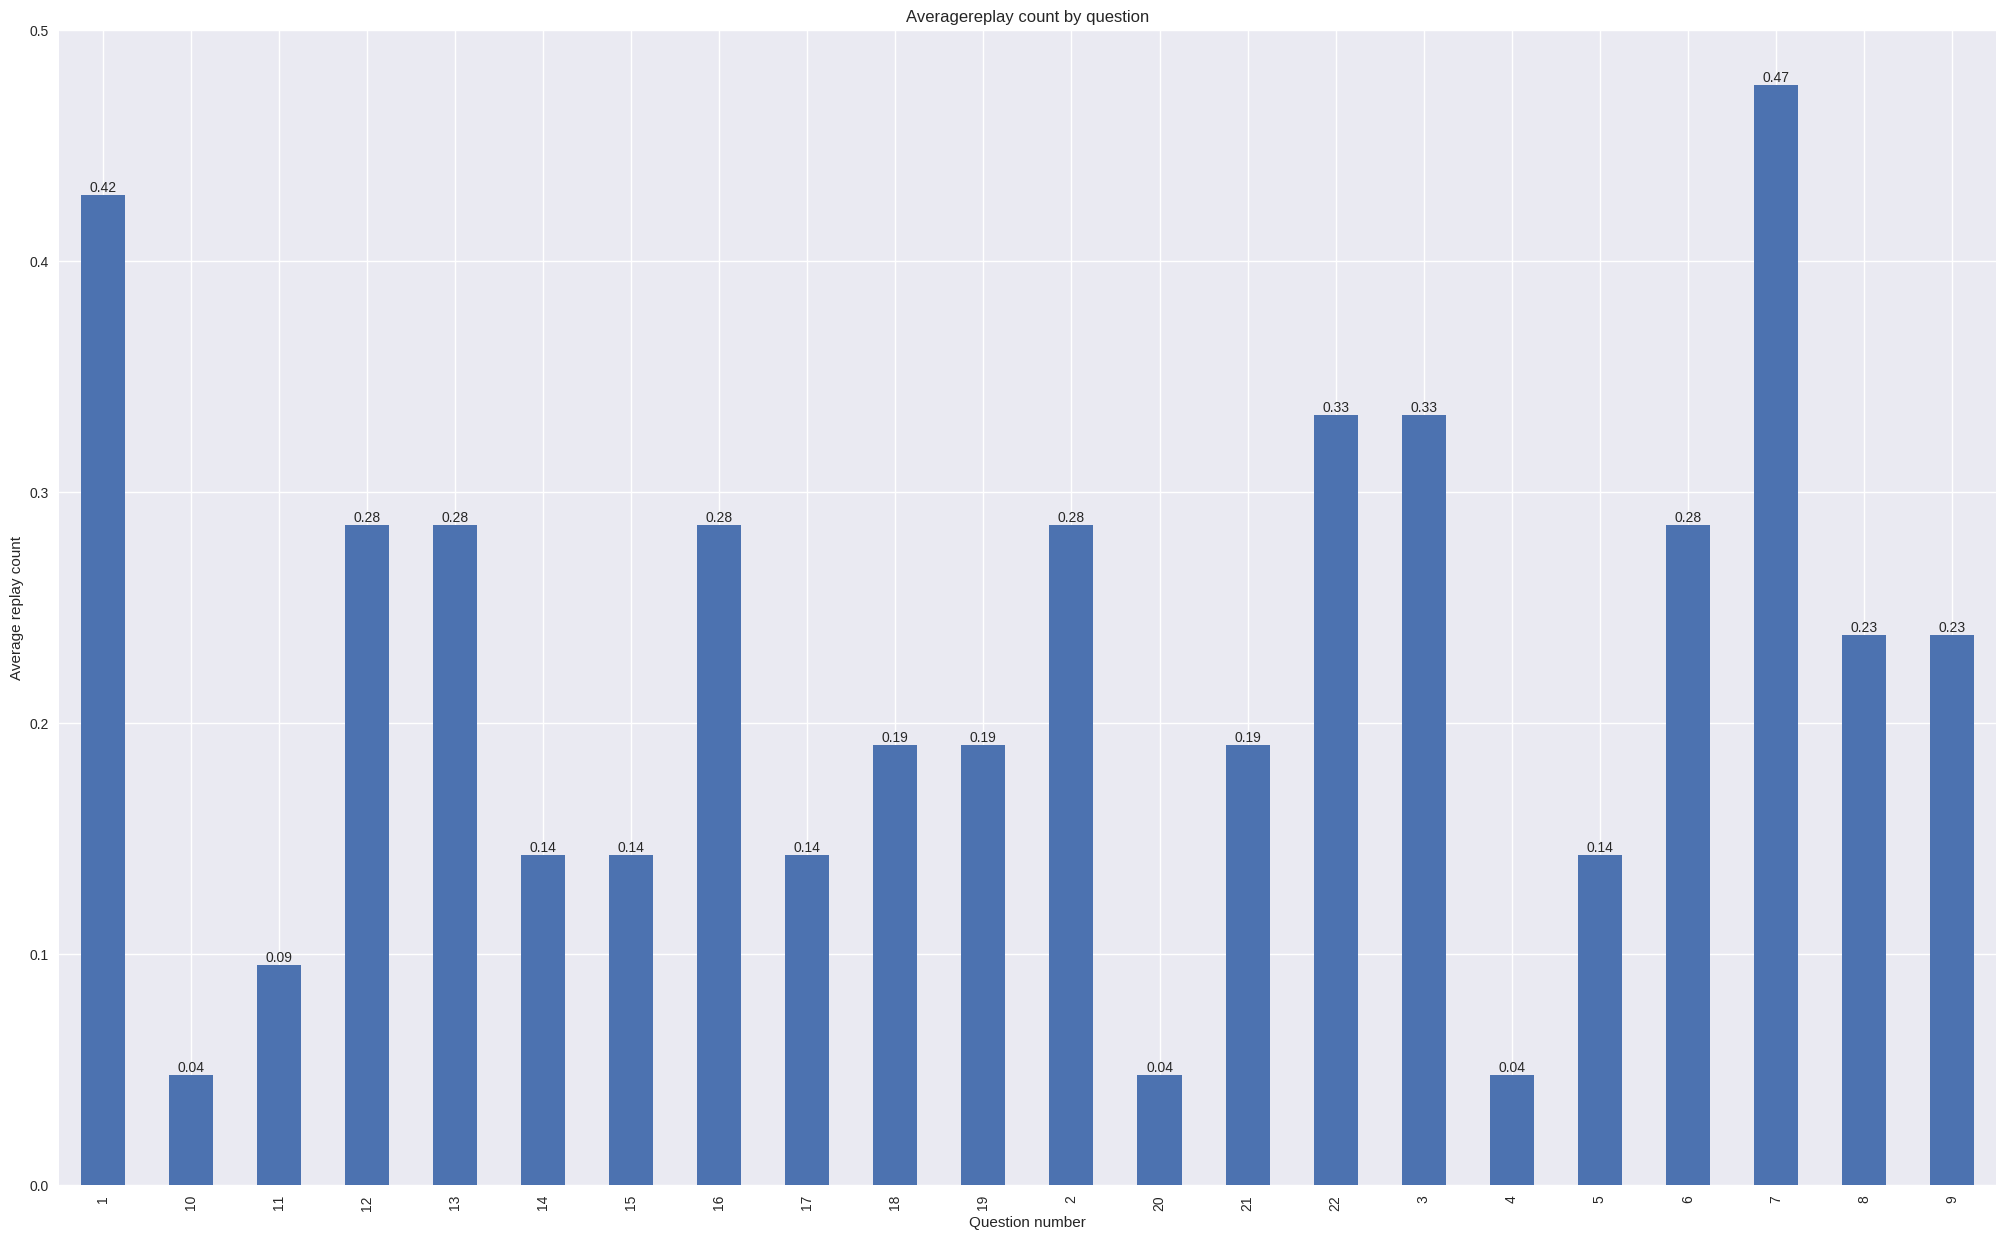

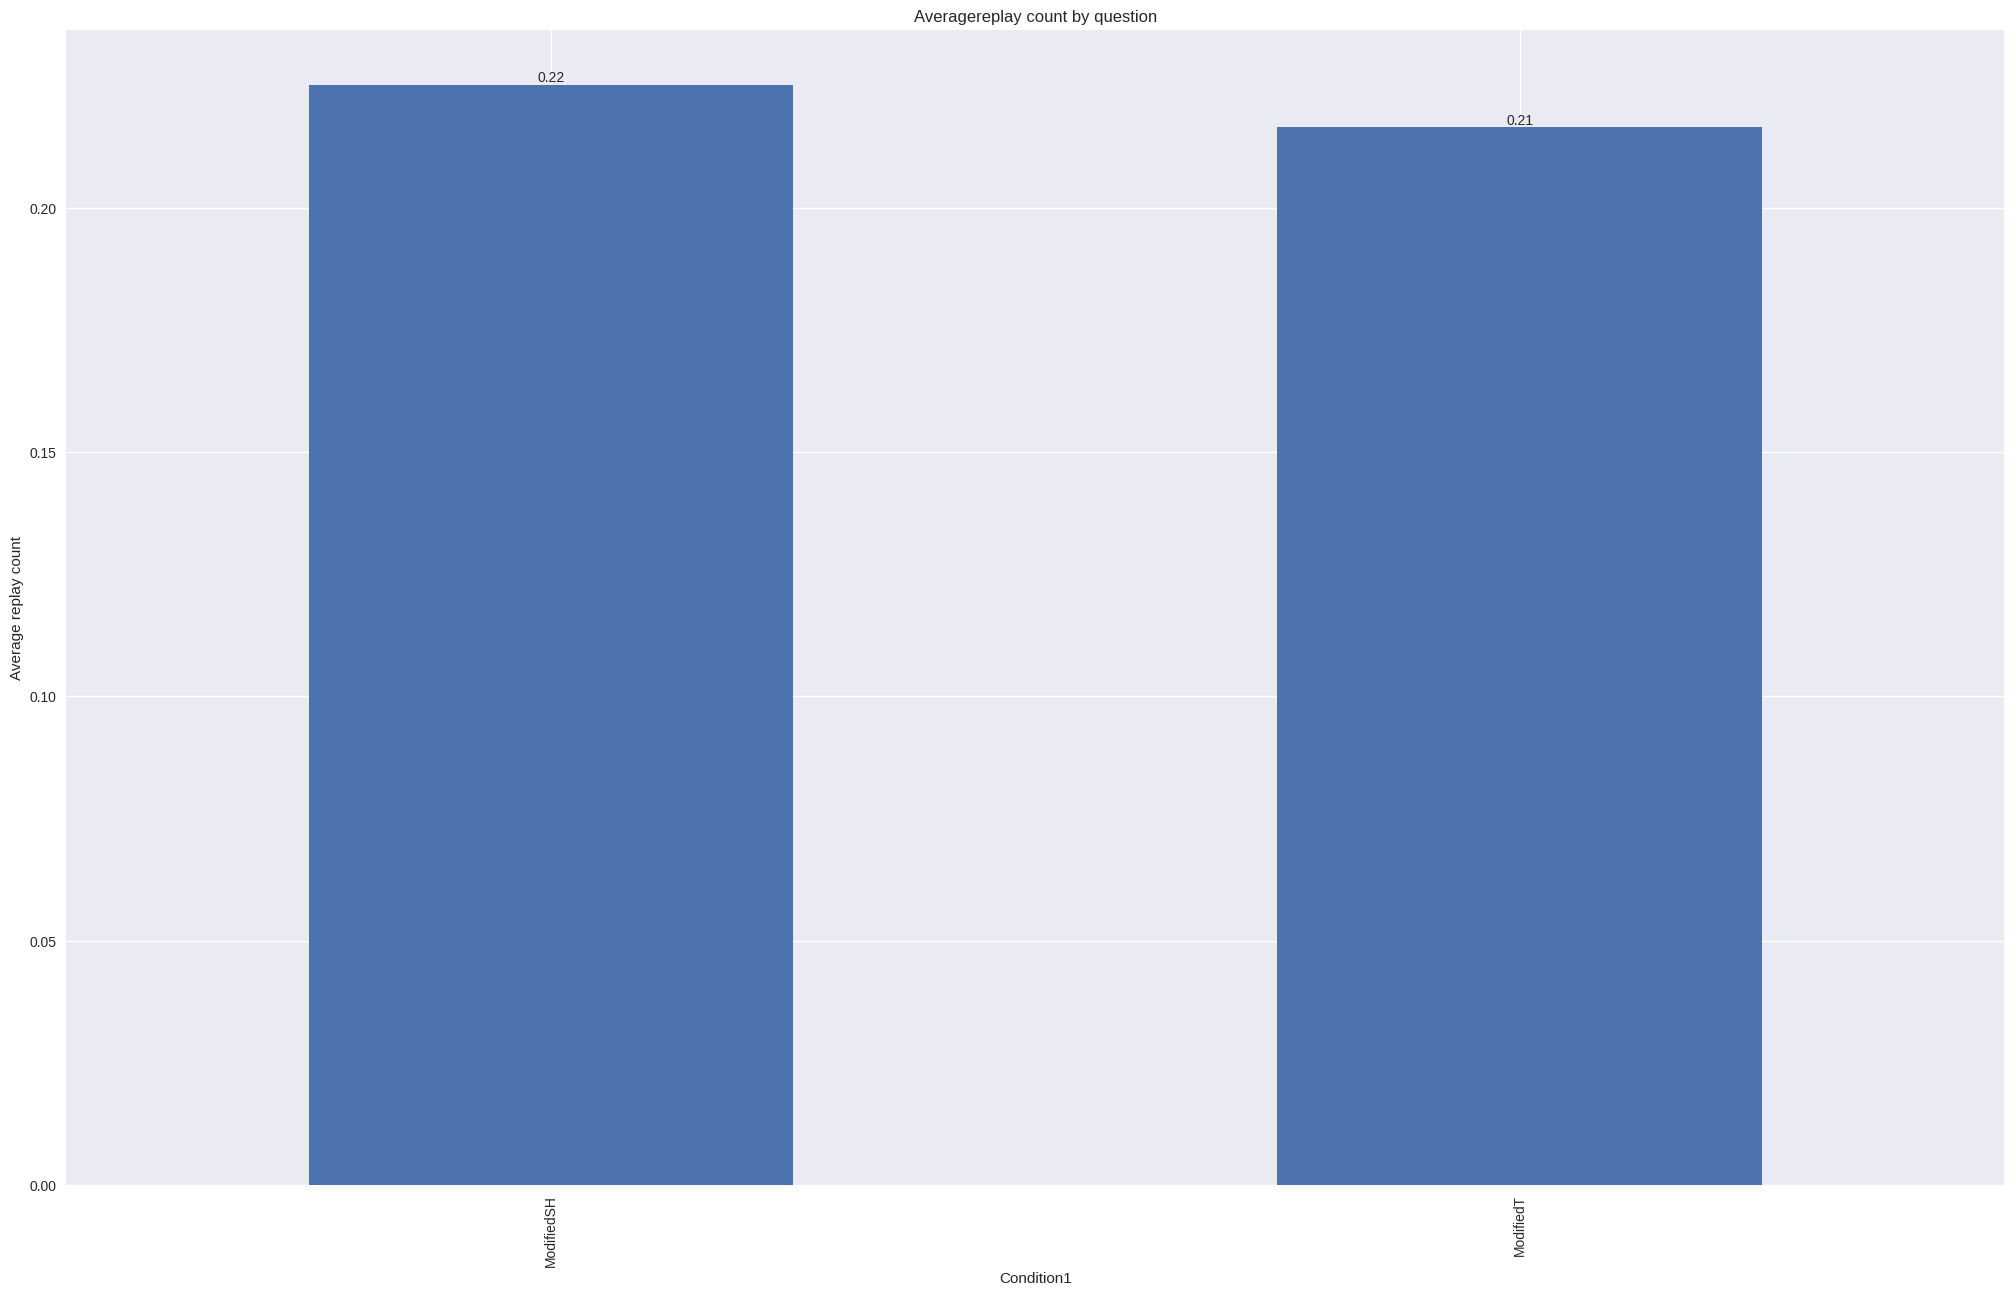

Modified SH vs Modified T
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: 2.3363022106399383
p-value: 0.019904064086656577

If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.
Pearson correlation coefficient between Success and Replay: 0.007361568813093187



In [56]:
# @title WITHIN THE IRISH

#-------Per CONDITION
# Categorise 'Country' into 'Ireland'
filtered_df_odd_mod_t = df_mod_T.loc[df_mod_T['Country'] == 'Ireland']
filtered_df_odd_mod_sh = df_mod_SH.loc[df_mod_SH['Country'] == 'Ireland']


# Calculate success rate for each condition in Ireland
success_ModifiedT = 100 * filtered_df_odd_mod_t[filtered_df_odd_mod_t['Success'] == 1].shape[0] / filtered_df_odd_mod_t.shape[0]
success_ModifiedSH = 100 * filtered_df_odd_mod_sh[filtered_df_odd_mod_sh['Success'] == 1].shape[0] / filtered_df_odd_mod_sh.shape[0]


headers = ['Modified T','Modified SH']
datas = [success_ModifiedT, success_ModifiedSH]

print(datas)

plot_2d_array(headers, datas, 'Condition1', 'Success Rate in %', 'Success rate within the Irish per condition', colours=plot_colours80s)

#-------by AGE GROUP------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

filter_withinIrish = df_odd.loc[df_odd['Country'] == 'Ireland']
for x in condition:
    df = filter_withinIrish[filter_withinIrish['Condition1'] == x]
    plot_success_rate_by_parameter(df, x, 'Age_group', 'Age group', 'Success Rate in %',  'Success rate within the Irish by age group for ', colours=plot_colours80s)

print('age2 vs age3')
val1 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Age'] == 2))
val2 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Age'] == 3))
do_ttest(val1, val2)


#------by GENDER-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = filter_withinIrish[filter_withinIrish['Condition1'] == x]
    plot_success_rate_by_parameter(df, x, 'Gender', 'Gender', 'Success Rate in %',  'Success rate within the Irish by gender for ', colours=plot_colours80s)


print('age2 vs age3')
val1 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Gender'] == 'F'))
val2 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Gender'] == 'M'))
do_ttest(val1, val2)

#------by LEVEL OF IRISH------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = filter_withinIrish[filter_withinIrish['Condition1'] == x]
    plot_success_rate_by_parameter(df, x, 'Irish', 'level of Irish', 'Success Rate in %',  'Success rate within the Irish depending on their level of Irish for ', colours=plot_colours80s)

val1 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Irish'] == 'Yes'))
val2 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Irish'] == 'No'))
val3 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Irish'] == 'Notions'))

do_anova_test([val1, val2, val3])

#------by GENDER of the speaker------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = filter_withinIrish[filter_withinIrish['Condition1'] == x]
    plot_success_rate_by_parameter(df, x, 'Condition2', 'Gender of the speaker', 'Success Rate in %',  'Success rate depending on the gender of the speakers regarding ', colours=plot_colours80s)

val1 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Condition2'] == 'F'))
val2 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Condition2'] == 'M'))

do_anova_test([val1, val2])

print('age2 vs age3')
do_ttest(val1, val2)


#------------Average reaction time in s By ItemNb------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

plot_bar_average_parameter(filter_withinIrish, 'ItemNb', 'Question number', 'Average replay count', 'Averagereplay count by question', 'Replay')

#------------Average reaction time in s By condition------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

plot_bar_average_parameter(filter_withinIrish, 'Condition1', 'Condition1', 'Average replay count', 'Averagereplay count by question', 'Replay')

#-----------TTEST on 'Modified SH vs Modified T' ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print('Modified SH vs Modified T')
val1 = ((filtered_df_odd_mod_t['Success'] == 1))
val2 = ((filtered_df_odd_mod_sh['Success'] == 1))
do_ttest(val1, val2)


# Calculate Pearson correlation coefficient
correlation = filter_withinIrish['Success'].corr(filter_withinIrish['Replay'])

print("If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.")

print("Pearson correlation coefficient between Success and Replay:", correlation)

print("")




     Participant ItemNb ExpectedKey Condition2 Condition1  \
22          9212      1           e          F  ModifiedT   
24          9212      3           t          F  ModifiedT   
25          9212      4           e          M  ModifiedT   
26          9212      5           e          F  ModifiedT   
27          9212      6           e          M  ModifiedT   
...          ...    ...         ...        ...        ...   
1354     William     13           r          F  ModifiedT   
1357     William     16           r          M  ModifiedT   
1358     William     17           r          M  ModifiedT   
1359     William     18           r          M  ModifiedT   
1360     William     19           r          F  ModifiedT   

     key_resp_question3.keys  Replay Gender  Age  Country    Irish  \
22                         e       0      F    2  Ireland      Yes   
24                         r       0      F    2  Ireland      Yes   
25                         t       0      F    2  Ireland

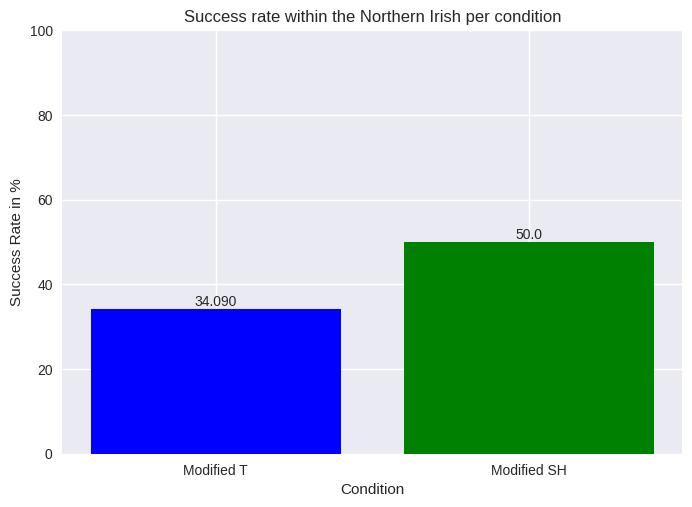

[57.142857142857146, 46.32034632034632]


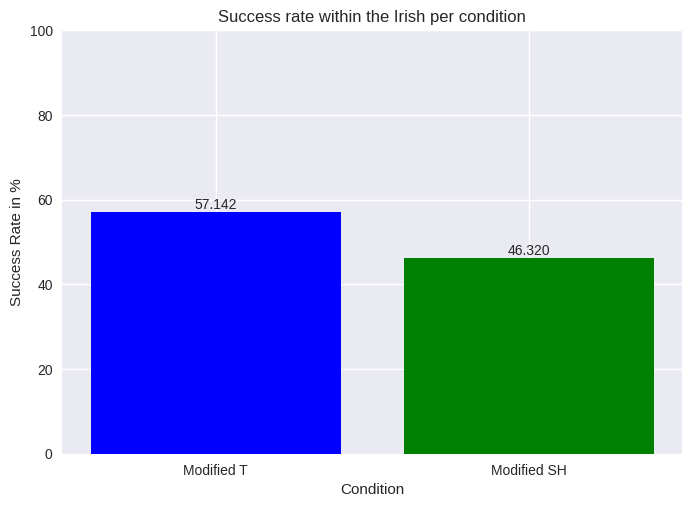

[57.142857142857146, 34.09090909090909, 46.32034632034632, 50.0]


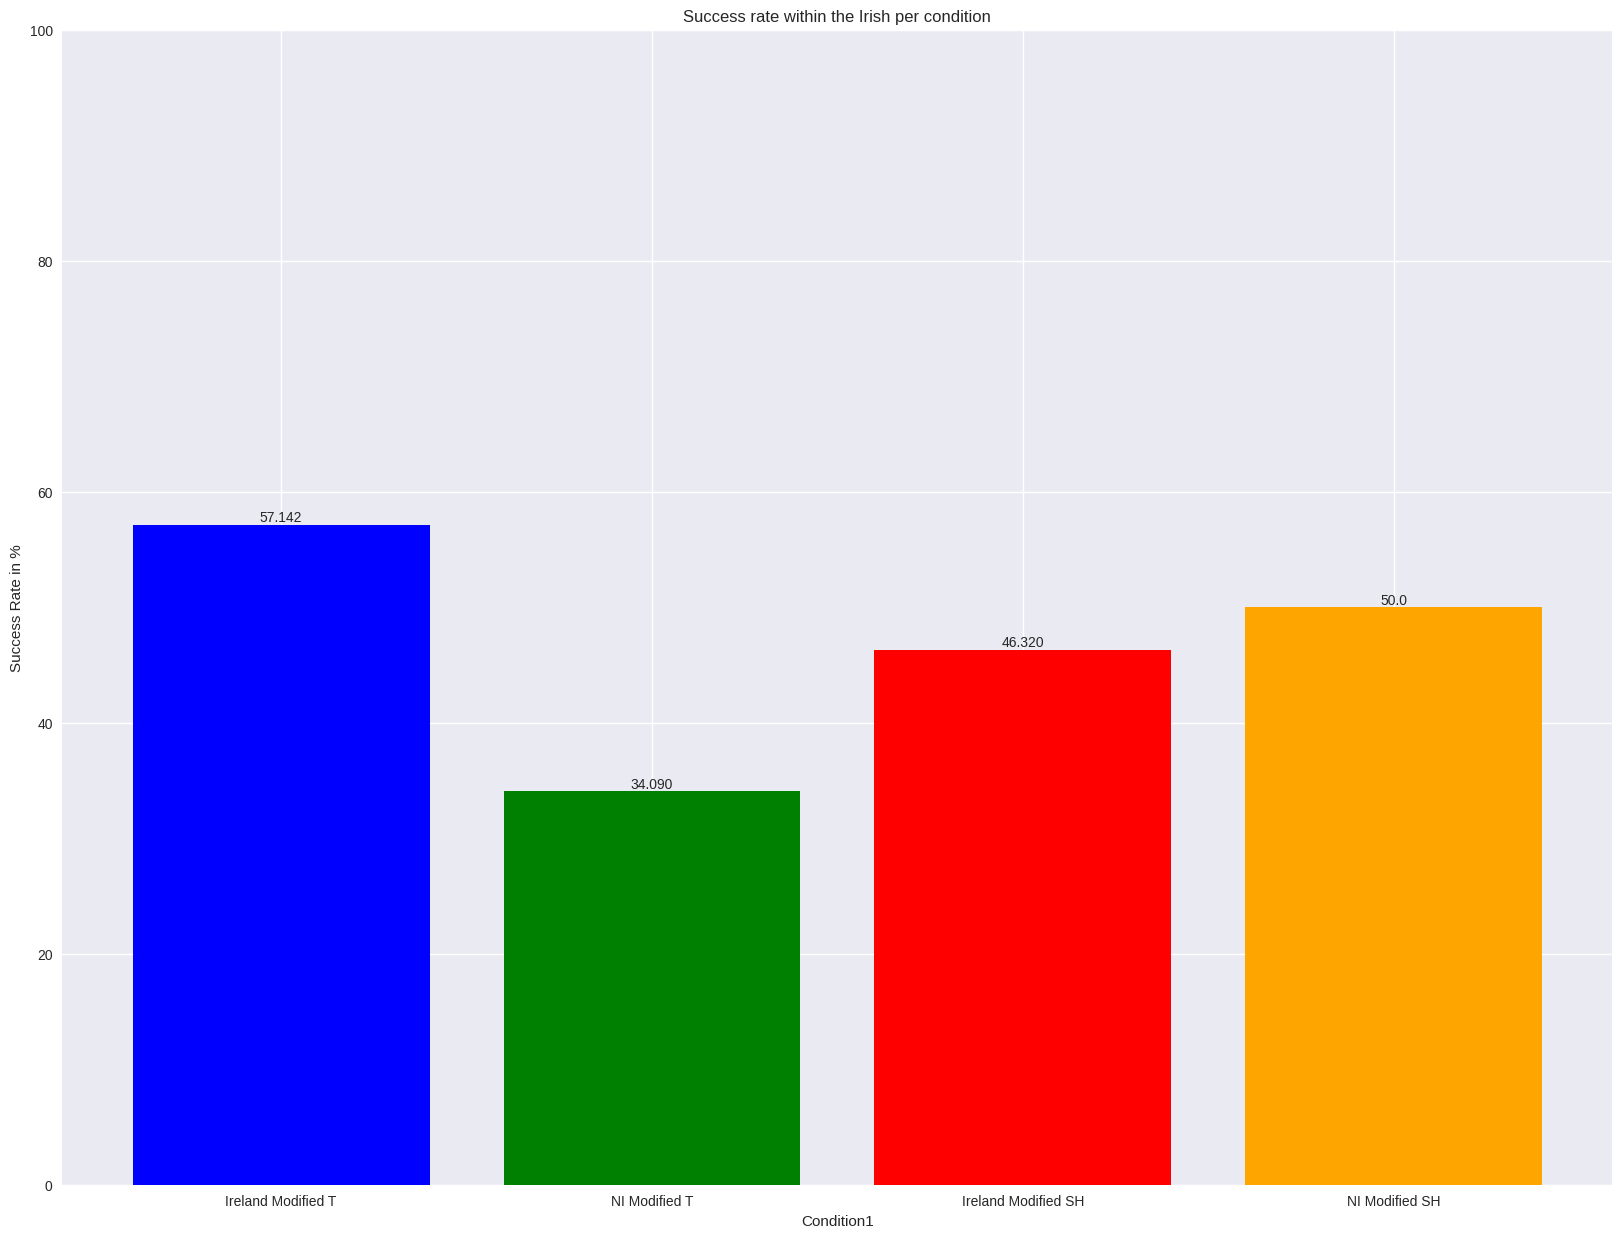

Modified T
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -12.832829261285879
p-value: 3.8053685519841285e-33

Modified SH
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -9.170067435783906
p-value: 9.50144628677898e-19



In [ ]:
# @title Ireland VS NI

#-------Per CONDITION
# Categorise 'Country' into ('Ireland', 'Northern Ireland')
filtered_df_odd_mod_t = df_mod_T.loc[df_mod_T['Country'].isin(['Ireland', 'Northern Ireland'])]
filtered_df_odd_mod_sh = df_mod_SH.loc[df_mod_SH['Country'].isin(['Ireland', 'Northern Ireland'])]


print(filtered_df_odd_mod_t)

# Calculate success rate for each condition in NI
success_ModifiedT_NI = (100 * filtered_df_odd_mod_t[(filtered_df_odd_mod_t['Success'] == 1) & (filtered_df_odd_mod_t['Country'] == 'Northern Ireland')].shape[0]
                        / filtered_df_odd_mod_t[filtered_df_odd_mod_t['Country'] == 'Northern Ireland'].shape[0])

success_ModifiedSH_NI = (100 * filtered_df_odd_mod_sh[(filtered_df_odd_mod_sh['Success'] == 1) & (filtered_df_odd_mod_sh['Country'] == 'Northern Ireland')].shape[0]
                         / filtered_df_odd_mod_sh[filtered_df_odd_mod_sh['Country'] == 'Northern Ireland'].shape[0])


headers = ['Modified T','Modified SH']
datas = [success_ModifiedT_NI, success_ModifiedSH_NI]

print(datas)
plot_2d_array(headers, datas, 'Condition', 'Success Rate in %', 'Success rate within the Northern Irish per condition', colours=plot_colours80s)

# Calculate success rate for each condition in Ireland
success_ModifiedT = (100 * filtered_df_odd_mod_t[(filtered_df_odd_mod_t['Success'] == 1) & (filtered_df_odd_mod_t['Country'] == 'Ireland')].shape[0]
                     / filtered_df_odd_mod_t[filtered_df_odd_mod_t['Country'] == 'Ireland'].shape[0])
success_ModifiedSH = (100 * filtered_df_odd_mod_sh[(filtered_df_odd_mod_sh['Success'] == 1) & (filtered_df_odd_mod_sh['Country'] == 'Ireland')].shape[0]
                      / filtered_df_odd_mod_sh[filtered_df_odd_mod_sh['Country'] == 'Ireland'].shape[0])

headers = ['Modified T','Modified SH']
datas = [success_ModifiedT, success_ModifiedSH]

print(datas)

plot_2d_array(headers, datas, 'Condition', 'Success Rate in %', 'Success rate within the Irish per condition', colours=plot_colours80s)


headers = ['Ireland Modified T', 'NI Modified T', 'Ireland Modified SH', 'NI Modified SH']
datas = [success_ModifiedT, success_ModifiedT_NI, success_ModifiedSH, success_ModifiedSH_NI]

print(datas)

plot_2d_array(headers, datas, 'Condition1', 'Success Rate in %', 'Success rate within the Irish per condition', colours=plot_colours80s, fig_size=(20, 15))

print('Modified T')
val1 = ((filtered_df_odd_mod_t['Success'] == 1) & (filtered_df_odd_mod_t['Country'] == 'Northern Ireland'))
val2 = ((filtered_df_odd_mod_t['Success'] == 1) & (filtered_df_odd_mod_t['Country'] == 'Ireland'))
do_ttest(val1, val2)

print('Modified SH')
val1 = ((filtered_df_odd_mod_sh['Success'] == 1) & (filtered_df_odd_mod_sh['Country'] == 'Northern Ireland'))
val2 = ((filtered_df_odd_mod_sh['Success'] == 1) & (filtered_df_odd_mod_sh['Country'] == 'Ireland'))
do_ttest(val1, val2)


In [45]:
# @title Other English Speaking Countries

#-------Per CONDITION
# Categorize 'Country' into 'Other English Speaking Countries'
filtered_df_odd_mod_t = df_mod_T.loc[df_mod_T['Country'] != 'Ireland']
filtered_df_odd_mod_sh = df_mod_SH.loc[df_mod_SH['Country'] != 'Ireland']


# Calculate success rate for each condition in Other English Speaking Countries
success_ModifiedT = 100 * filtered_df_odd_mod_t[filtered_df_odd_mod_t['Success'] == 1].shape[0] / filtered_df_odd_mod_t.shape[0]
success_ModifiedSH = 100 * filtered_df_odd_mod_sh[filtered_df_odd_mod_sh['Success'] == 1].shape[0] / filtered_df_odd_mod_sh.shape[0]


headers = ['Modified T','Modified SH']
datas = [success_ModifiedT, success_ModifiedSH]

print(datas)

plot_2d_array(headers, datas, 'Condition', 'Success Rate in %', 'Success rate within the other English speaking countries per condition', colours=plot_colours80s)

#-------by AGE GROUP----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

filter_withoutIrish = df_odd.loc[df_odd['Country'] != 'Ireland']
for x in condition:
    df = filter_withoutIrish[filter_withoutIrish['Condition1'] == x]
    plot_success_rate_by_parameter(df, x, 'Age_group', 'Age group', 'Success Rate in %',  'Success rate within the other English speaking countries by age group for ', colours=plot_colours80s)

print('age1 vs age2 vs age3')

val1 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Age'] == 1))
val2 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Age'] == 2))
val3 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Age'] == 3))

do_anova_test([val1, val2, val3])

#------by GENDER----------------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = filter_withoutIrish[filter_withoutIrish['Condition1'] == x]
    plot_success_rate_by_parameter(df, x, 'Gender', 'Gender', 'Success Rate in %',  'Success rate other English speaking countries by gender for ', colours=plot_colours80s)


print('F vs M listeners')
val1 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Gender'] == 'F'))
val2 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Gender'] == 'M'))
do_ttest(val1, val2)


#------by LEVEL OF IRISH---------------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = filter_withoutIrish[filter_withoutIrish['Condition1'] == x]
    plot_success_rate_by_parameter(df, x, 'Irish', 'level of Irish', 'Success Rate in %',  'Success rate within the other English speaking countries depending on their level of Irish for ', colours=plot_colours80s)


print('level of Irish yes vs no vs notions')
val1 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Irish'] == 'No'))
val2 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Irish'] == 'Notions'))

do_ttest(val1, val2)

#------by GENDER of the speaker-----------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = filter_withoutIrish[filter_withoutIrish['Condition1'] == x]
    plot_success_rate_by_parameter(df, x, 'Condition2', 'Gender of the speaker', 'Success Rate in %',  'Success rate within the  English speaking countriesdepending on the gender of the speakers regarding ', colours=plot_colours80s)

print('F vs M speakers')
val1 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Condition2'] == 'F'))
val2 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Condition2'] == 'M'))
do_ttest(val1, val2)

#------------Average reaction time in s By ItemNb---------------------------------------------------------------------------------------------------------------------------------------------

plot_bar_average_parameter(filter_withoutIrish, 'ItemNb', 'Question number', 'Average Replay', 'Average Replay by question', 'Replay')

#------------Average reaction time in s By condition

plot_bar_average_parameter(filter_withoutIrish, 'Condition1', 'Condition', 'Average Replay', 'Average Replay by question', 'Replay')

#---------TTEST on 'Modified SH vs Modified T'----------------------------------------------------------------------------------------------------------------------------------------------

print('Modified SH vs Modified T')
val1 = ((filtered_df_odd_mod_t['Success'] == 1))
val2 = ((filtered_df_odd_mod_sh['Success'] == 1))
do_ttest(val1, val2)

#-------------------------------------------------------------------------- Calculate Pearson correlation coefficient

correlation = filter_withoutIrish['Success'].corr(filter_withoutIrish['Replay'])

print("If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.")

print("Pearson correlation coefficient between Success and Replay:", correlation)

print("")



0.275


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                              Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               Success  
No. Observations:                1364                  Method:                           REML     
No. Groups:                      61                    Scale:                            0.2462   
Min. group size:                 22                    Log-Likelihood:                   -998.4763
Max. group size:                 44                    Converged:                        Yes      
Mean group size:                 22.4                                                             
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

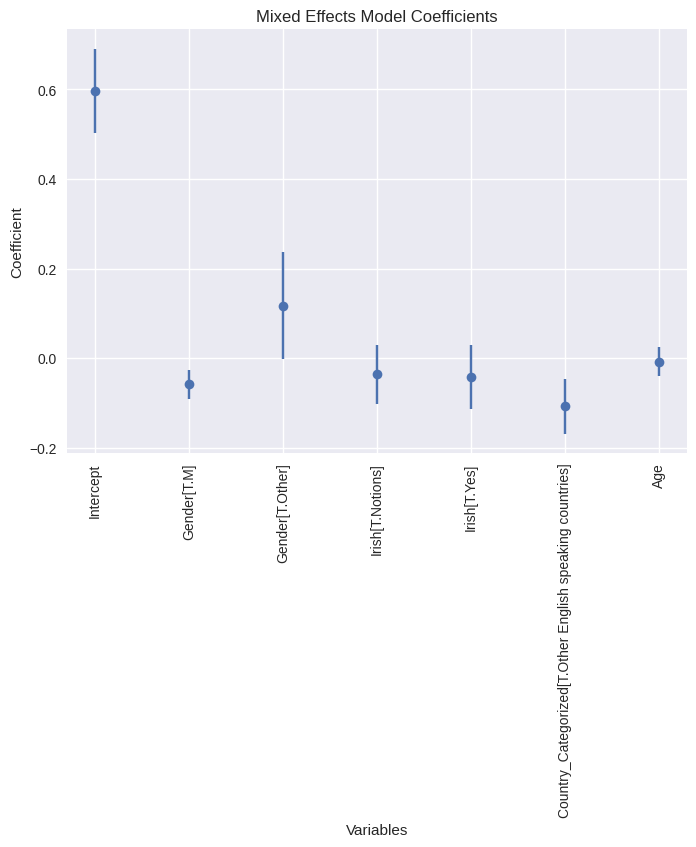

In [ ]:
# @title MIXED EFFECTS MODEL all participants


# Fit the mixed effects model
model = smf.mixedlm("Success ~ Gender + Age + Irish + Country_Categorized", df_odd, groups=df_odd["Participant"])
result = model.fit()

# Print the summary of the model
print(result.summary())

# Extract the coefficients and standard errors
coefs = result.fe_params
stderr = result.bse_fe

# Plot the coefficients with error bars
plt.errorbar(coefs.index, coefs.values, yerr=stderr, fmt='o', capsize=5)
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Mixed Effects Model Coefficients')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Success  
No. Observations:   462      Method:              REML     
No. Groups:         21       Scale:               0.2491   
Min. group size:    22       Log-Likelihood:      -342.2766
Max. group size:    22       Converged:           Yes      
Mean group size:    22.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.558    0.151  3.690 0.000  0.261  0.854
Gender[T.M]      -0.176    0.092 -1.917 0.055 -0.356  0.004
Irish[T.Notions] -0.128    0.094 -1.361 0.174 -0.311  0.056
Irish[T.Yes]     -0.118    0.087 -1.351 0.177 -0.289  0.053
Age               0.064    0.087  0.729 0.466 -0.108  0.235
Group Var         0.000    0.010                           



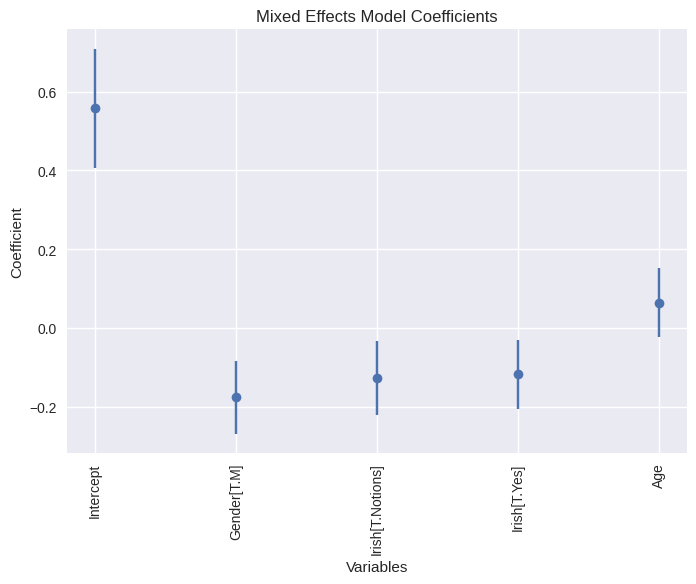

In [ ]:
# @title MIXED EFFECTS MODEL within the Irish


df_odd.head()

# Fit the mixed effects model
model = smf.mixedlm("Success ~ Gender + Age + Irish", filter_withinIrish, groups=filter_withinIrish["Participant"])
result = model.fit()

# Print the summary of the model
print(result.summary())

# Extract the coefficients and standard errors
coefs = result.fe_params
stderr = result.bse_fe

# Plot the coefficients with error bars
plt.errorbar(coefs.index, coefs.values, yerr=stderr, fmt='o', capsize=5)
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Mixed Effects Model Coefficients')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Success  
No. Observations:   902      Method:              REML     
No. Groups:         40       Scale:               0.2463   
Min. group size:    22       Log-Likelihood:      -658.6400
Max. group size:    44       Converged:           No       
Mean group size:    22.6                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.460    0.084  5.490 0.000  0.296  0.625
Gender[T.M]      -0.038    0.037 -1.047 0.295 -0.110  0.033
Gender[T.Other]   0.130    0.116  1.115 0.265 -0.098  0.358
Irish[T.Notions] -0.014    0.117 -0.118 0.906 -0.243  0.215
Age               0.000    0.036  0.012 0.990 -0.069  0.070
Group Var         0.002    0.008                           



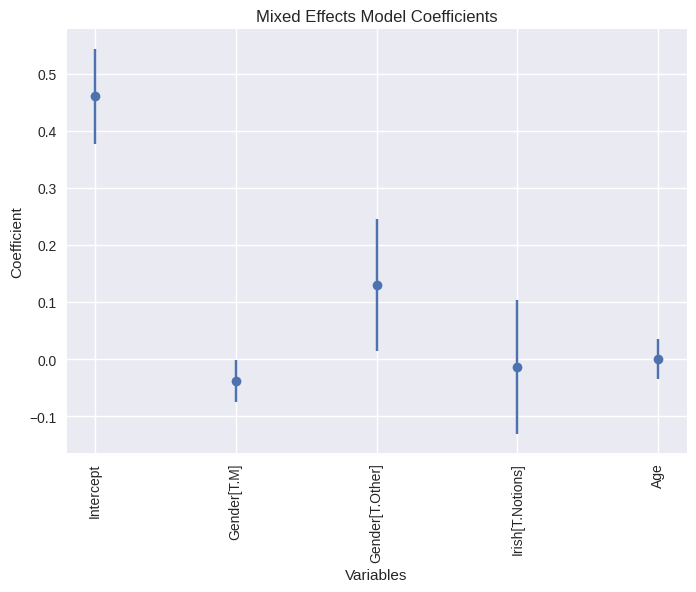

In [ ]:
# @title MIXED EFFECTS MODEL with other countries


df_odd.head()

# Fit the mixed effects model
model = smf.mixedlm("Success ~ Gender + Age + Irish", filter_withoutIrish, groups=filter_withoutIrish["Participant"])
result = model.fit()

# Print the summary of the model
print(result.summary())

# Extract the coefficients and standard errors
coefs = result.fe_params
stderr = result.bse_fe

# Plot the coefficients with error bars
plt.errorbar(coefs.index, coefs.values, yerr=stderr, fmt='o', capsize=5)
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Mixed Effects Model Coefficients')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [46]:
# @title Replay Count all participants

def plot_replay_by_country(df,x):
  #group it by country
    grouped = df.groupby('Country_Categorized')

    # Calculate success rate
    replay_rate = grouped['Replay'].sum()
    print(replay_rate)

    # Plot histogram (the figure at the bottom)
    plt.figure(figsize=(25, 15))
    plt.bar(replay_rate.index, replay_rate.values)
    plt.xlabel('Countries',size=20)
    plt.ylabel('Number of replays',size=20)
    plt.title('Number of replays by Country for '+x,size=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

Country_Categorized
Ireland                              50
Other English speaking countries    136
Name: Replay, dtype: int64


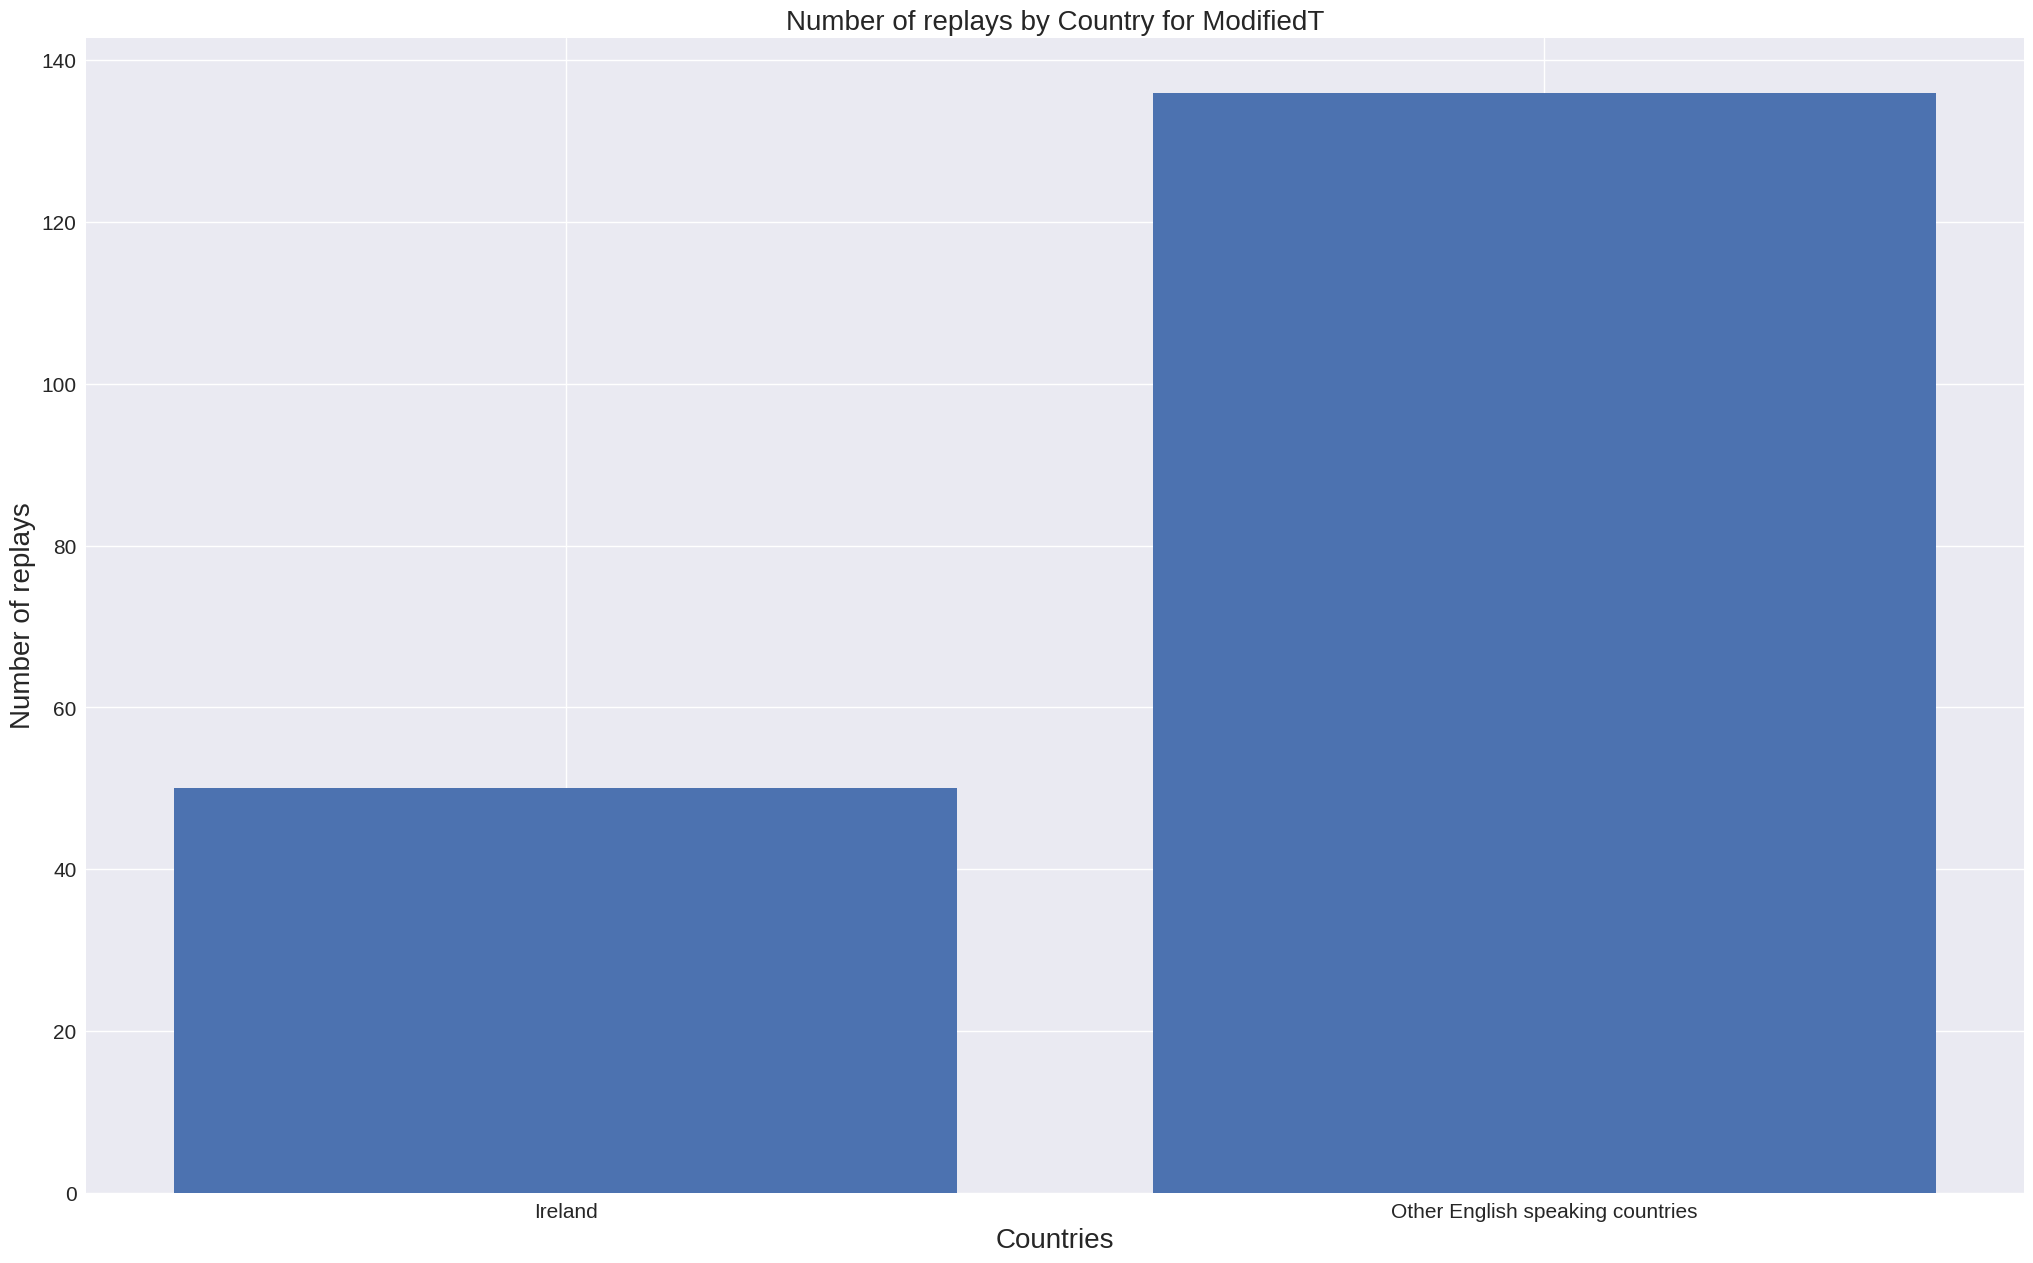

Country_Categorized
Ireland                              52
Other English speaking countries    110
Name: Replay, dtype: int64


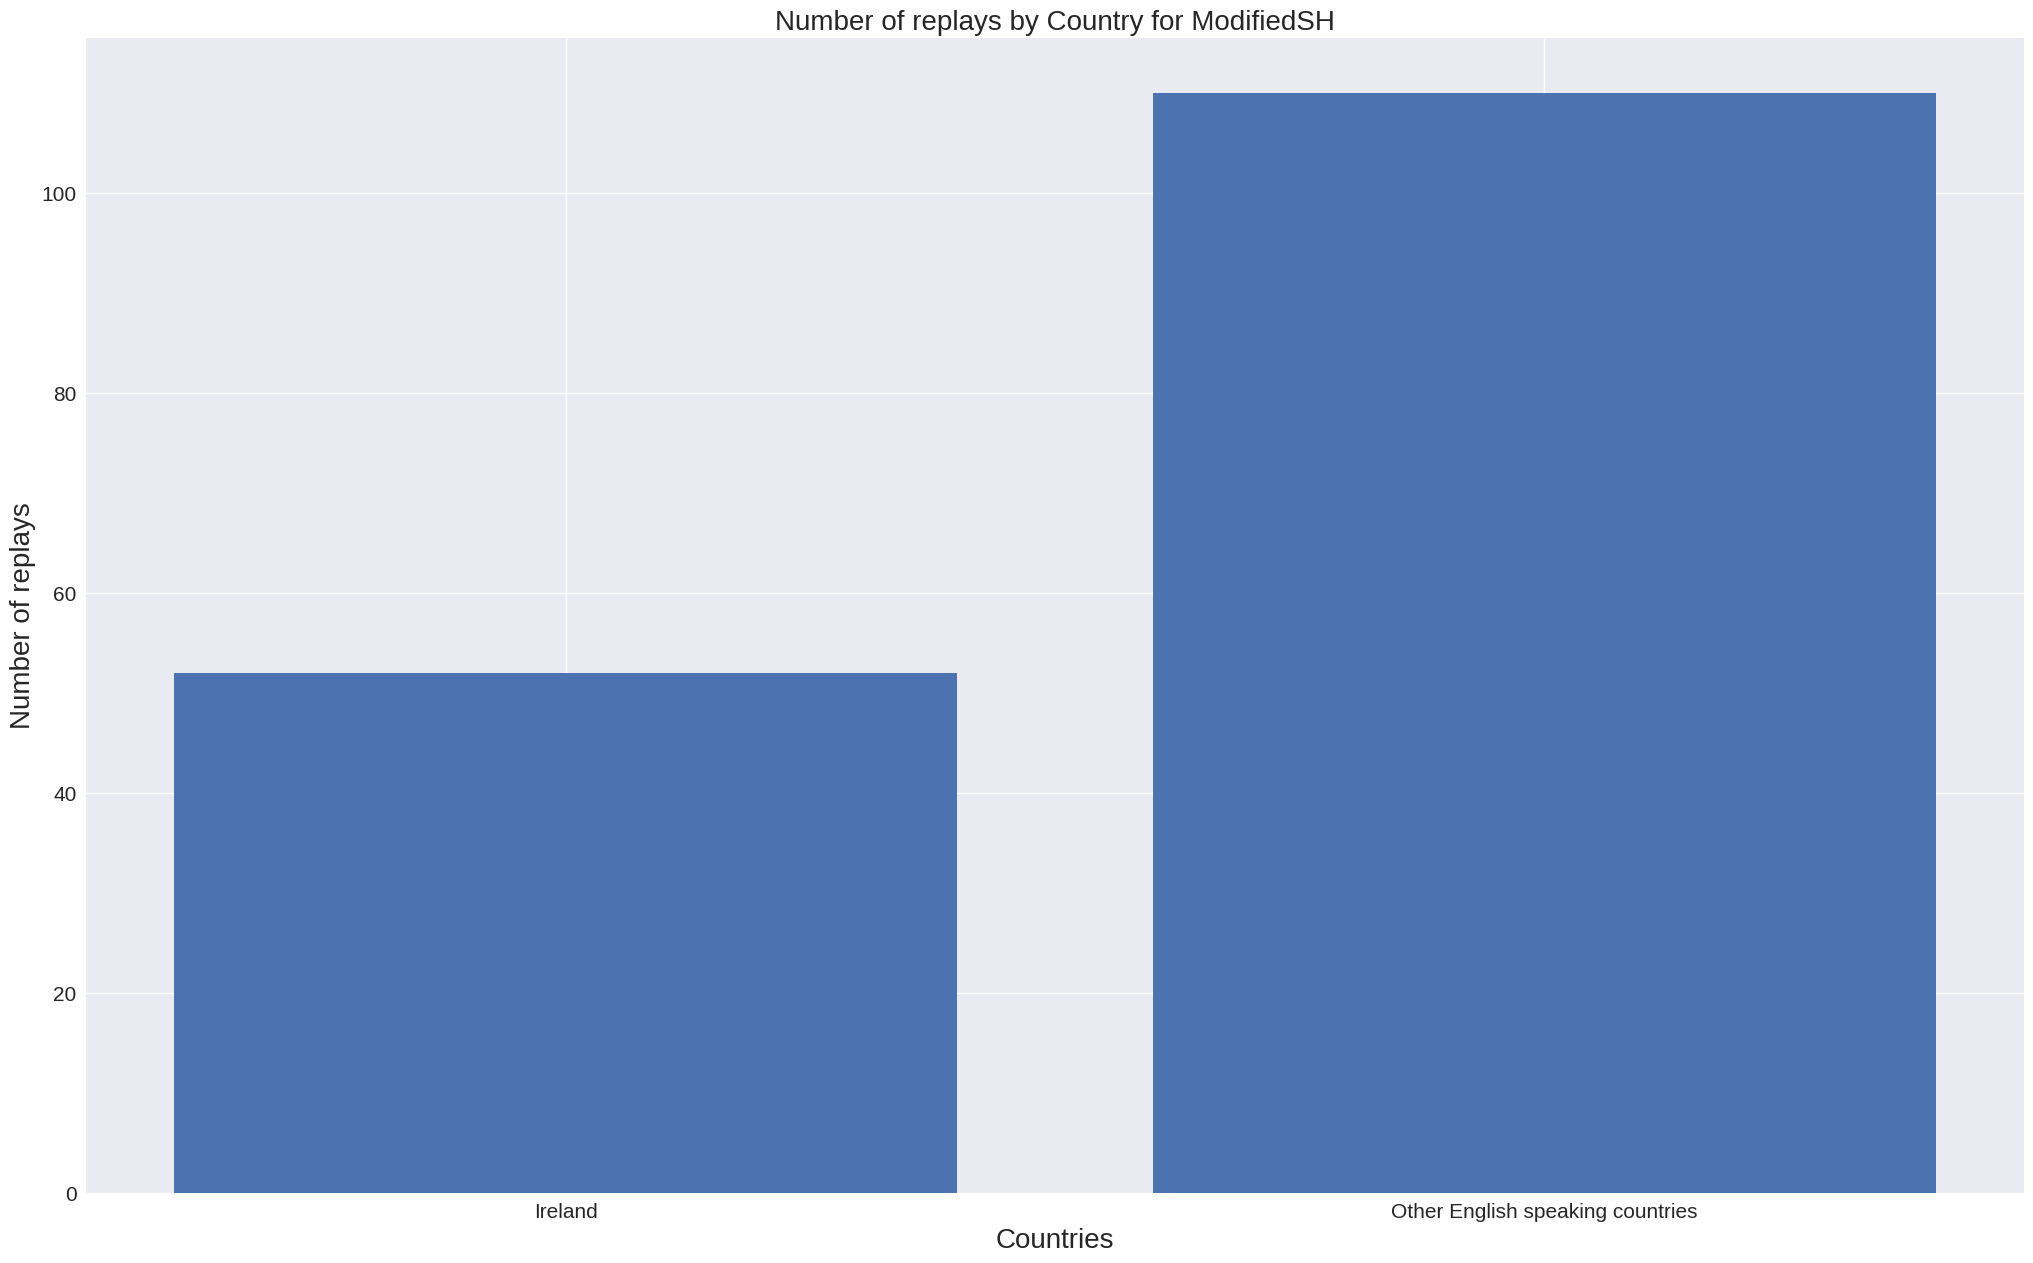

In [47]:
#go into list condition and take the value x
for x in condition:
    df = df_odd[df_odd['Condition1'] == x]
    plot_replay_by_country(df,x)

Condition1
ModifiedSH    162
ModifiedT     186
Name: Replay, dtype: int64


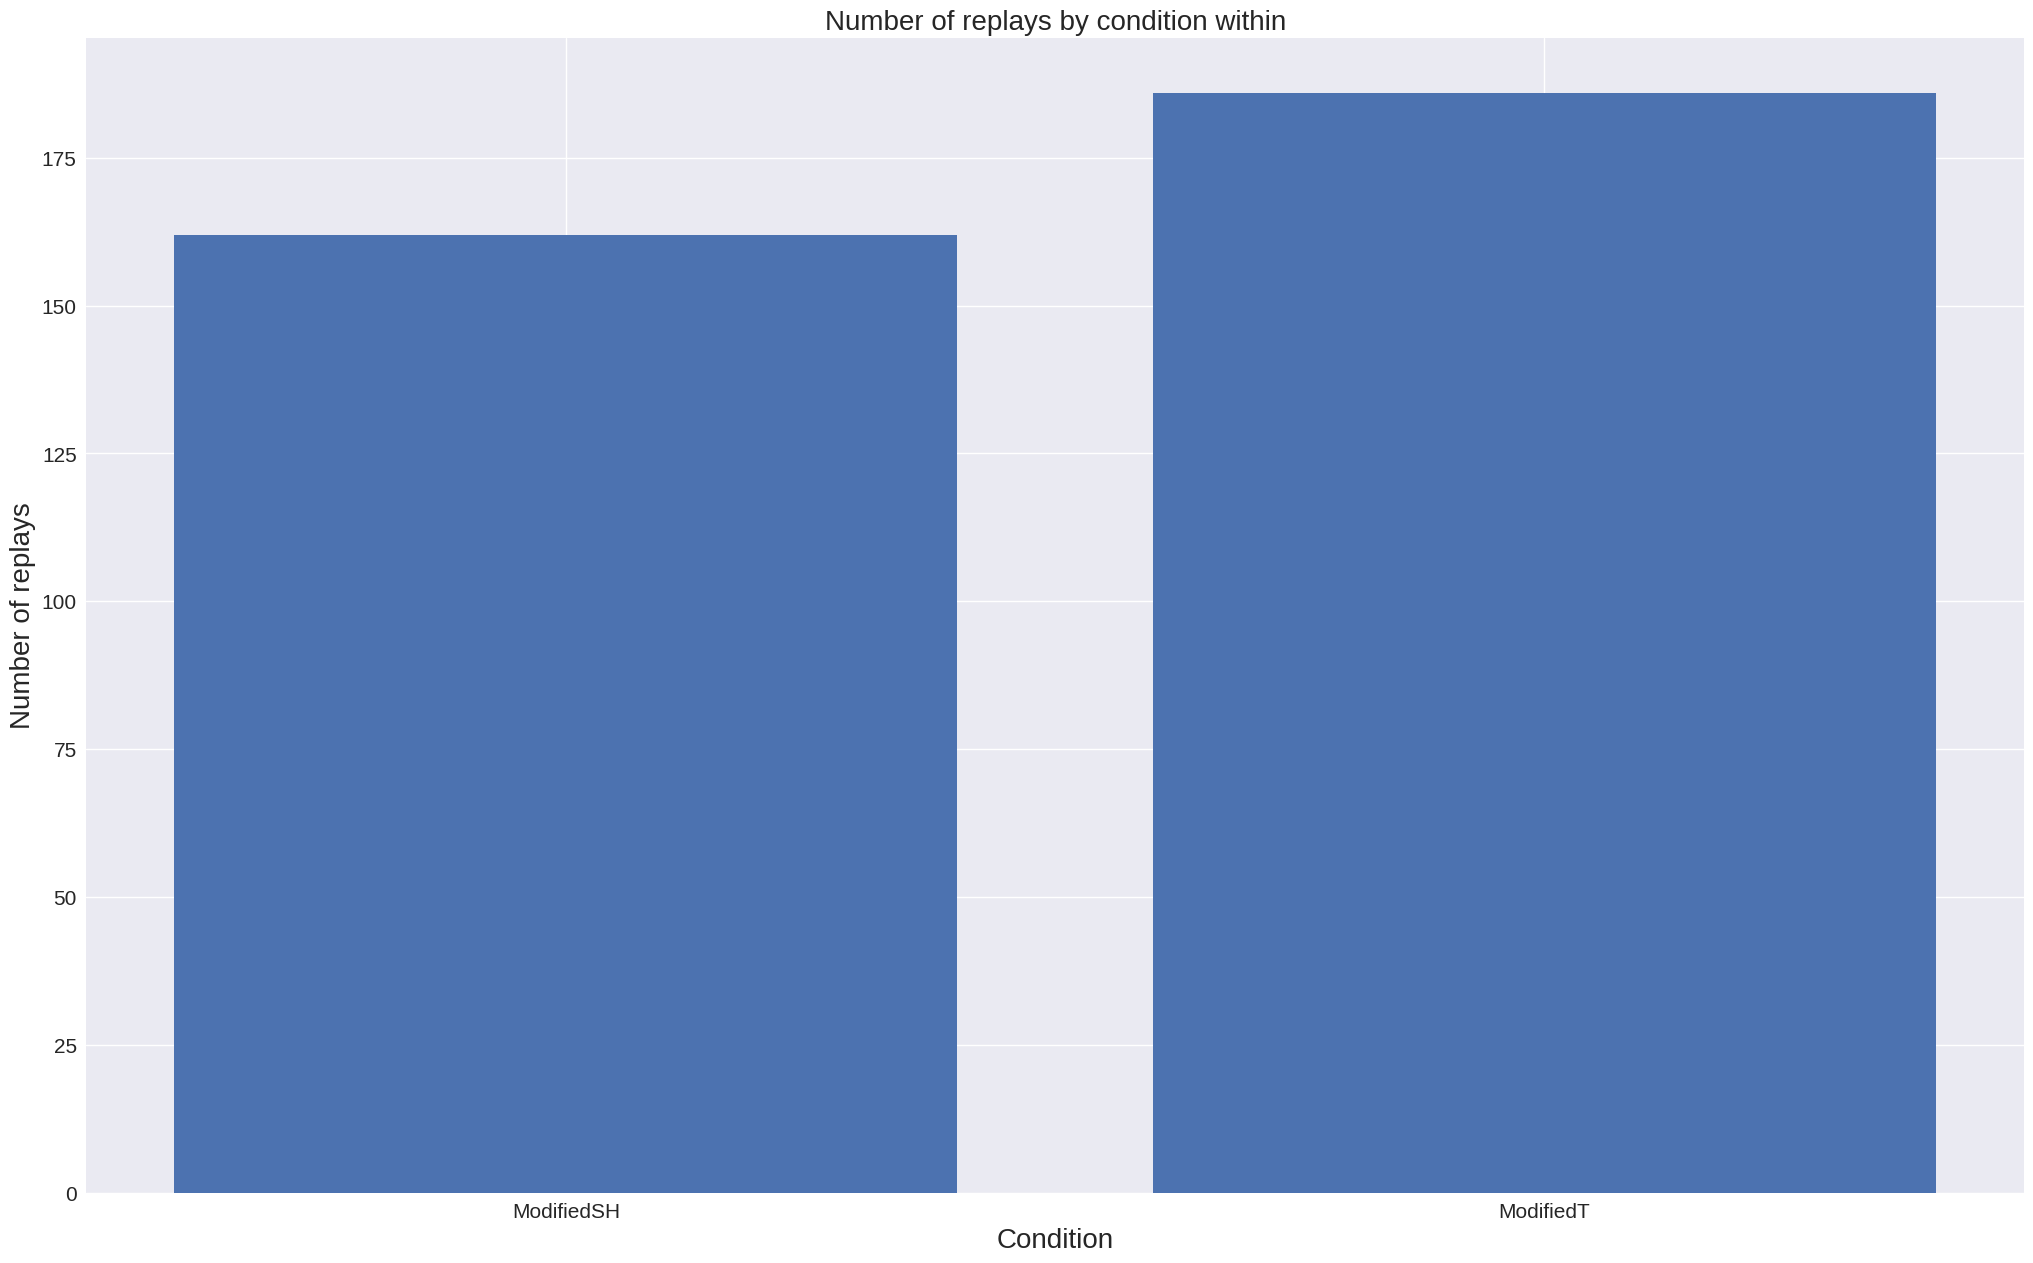

In [68]:
# @title Replay Count all participants

#-----------------------Condition
plot_replay(df_odd, '', 'Condition1', 'Number of replays by condition within', 'Condition')


Gender
F        70
M        57
Other     9
Name: Replay, dtype: int64


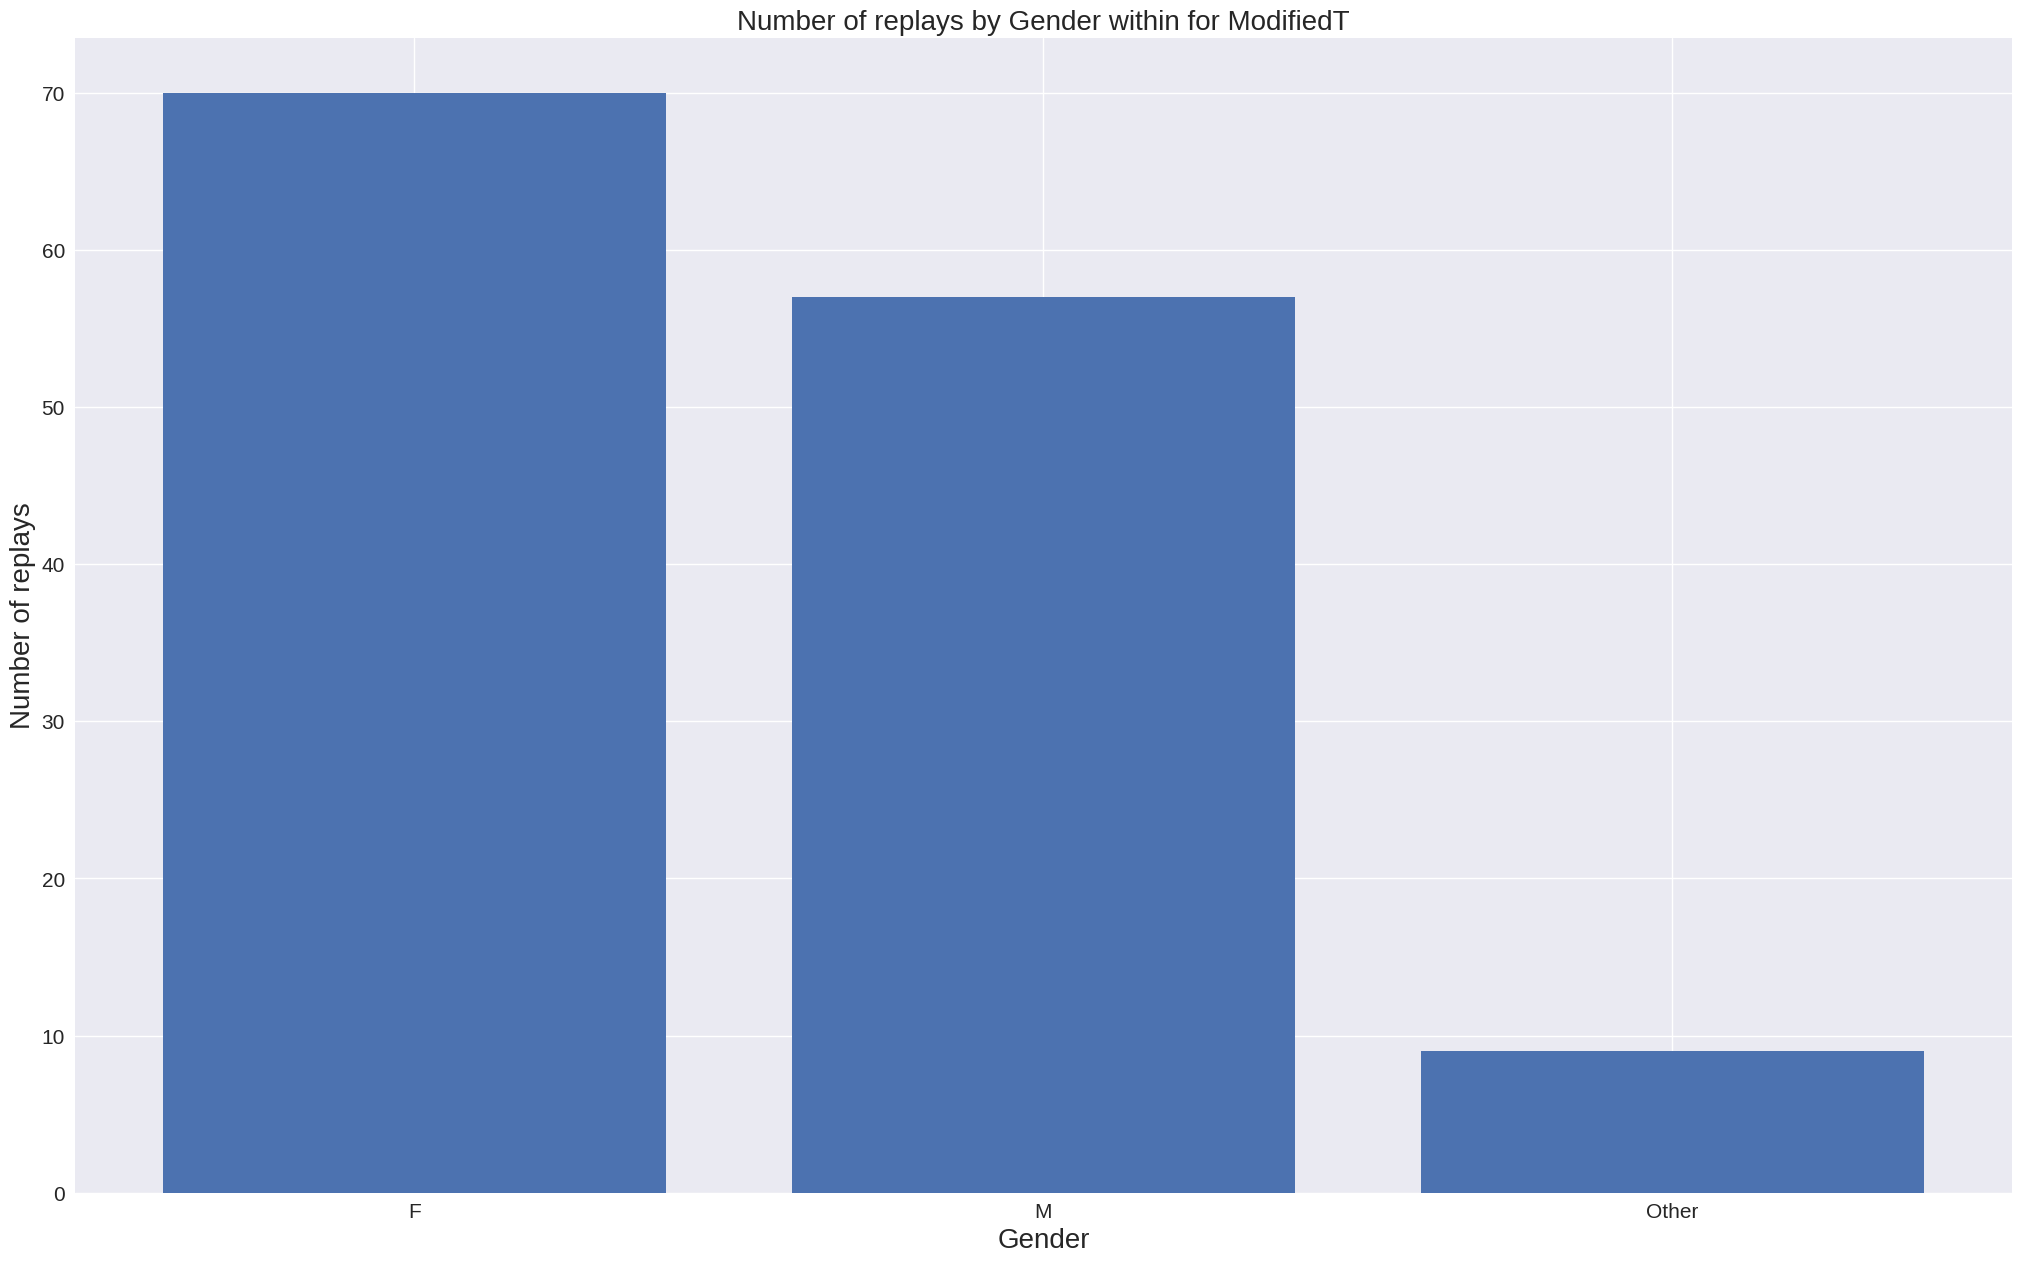

Gender
F        64
M        42
Other     4
Name: Replay, dtype: int64


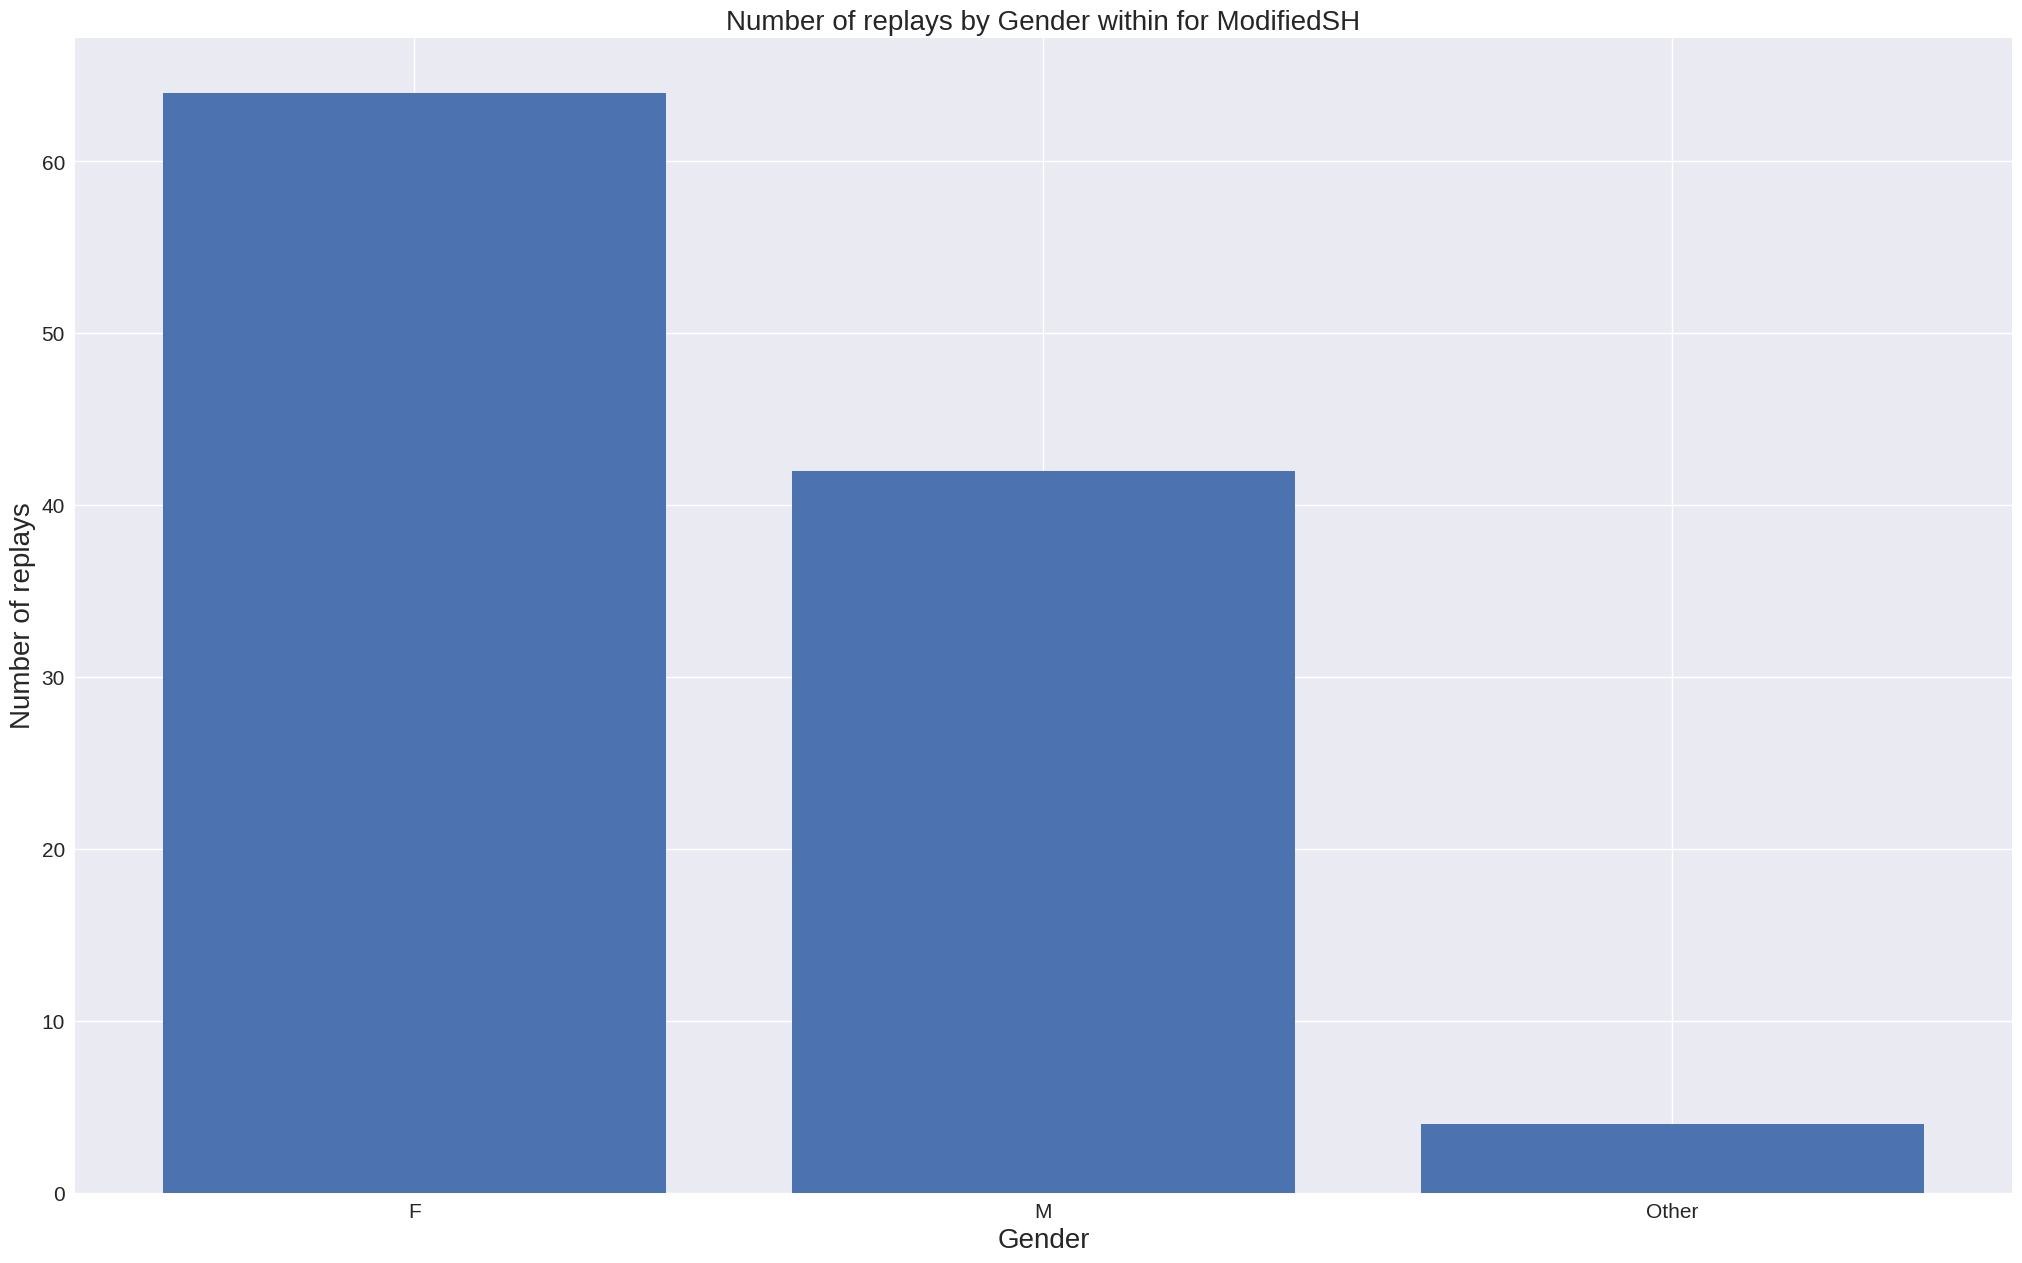

Age_group
18-37           108
3-17              0
38 and above     28
Name: Replay, dtype: int64


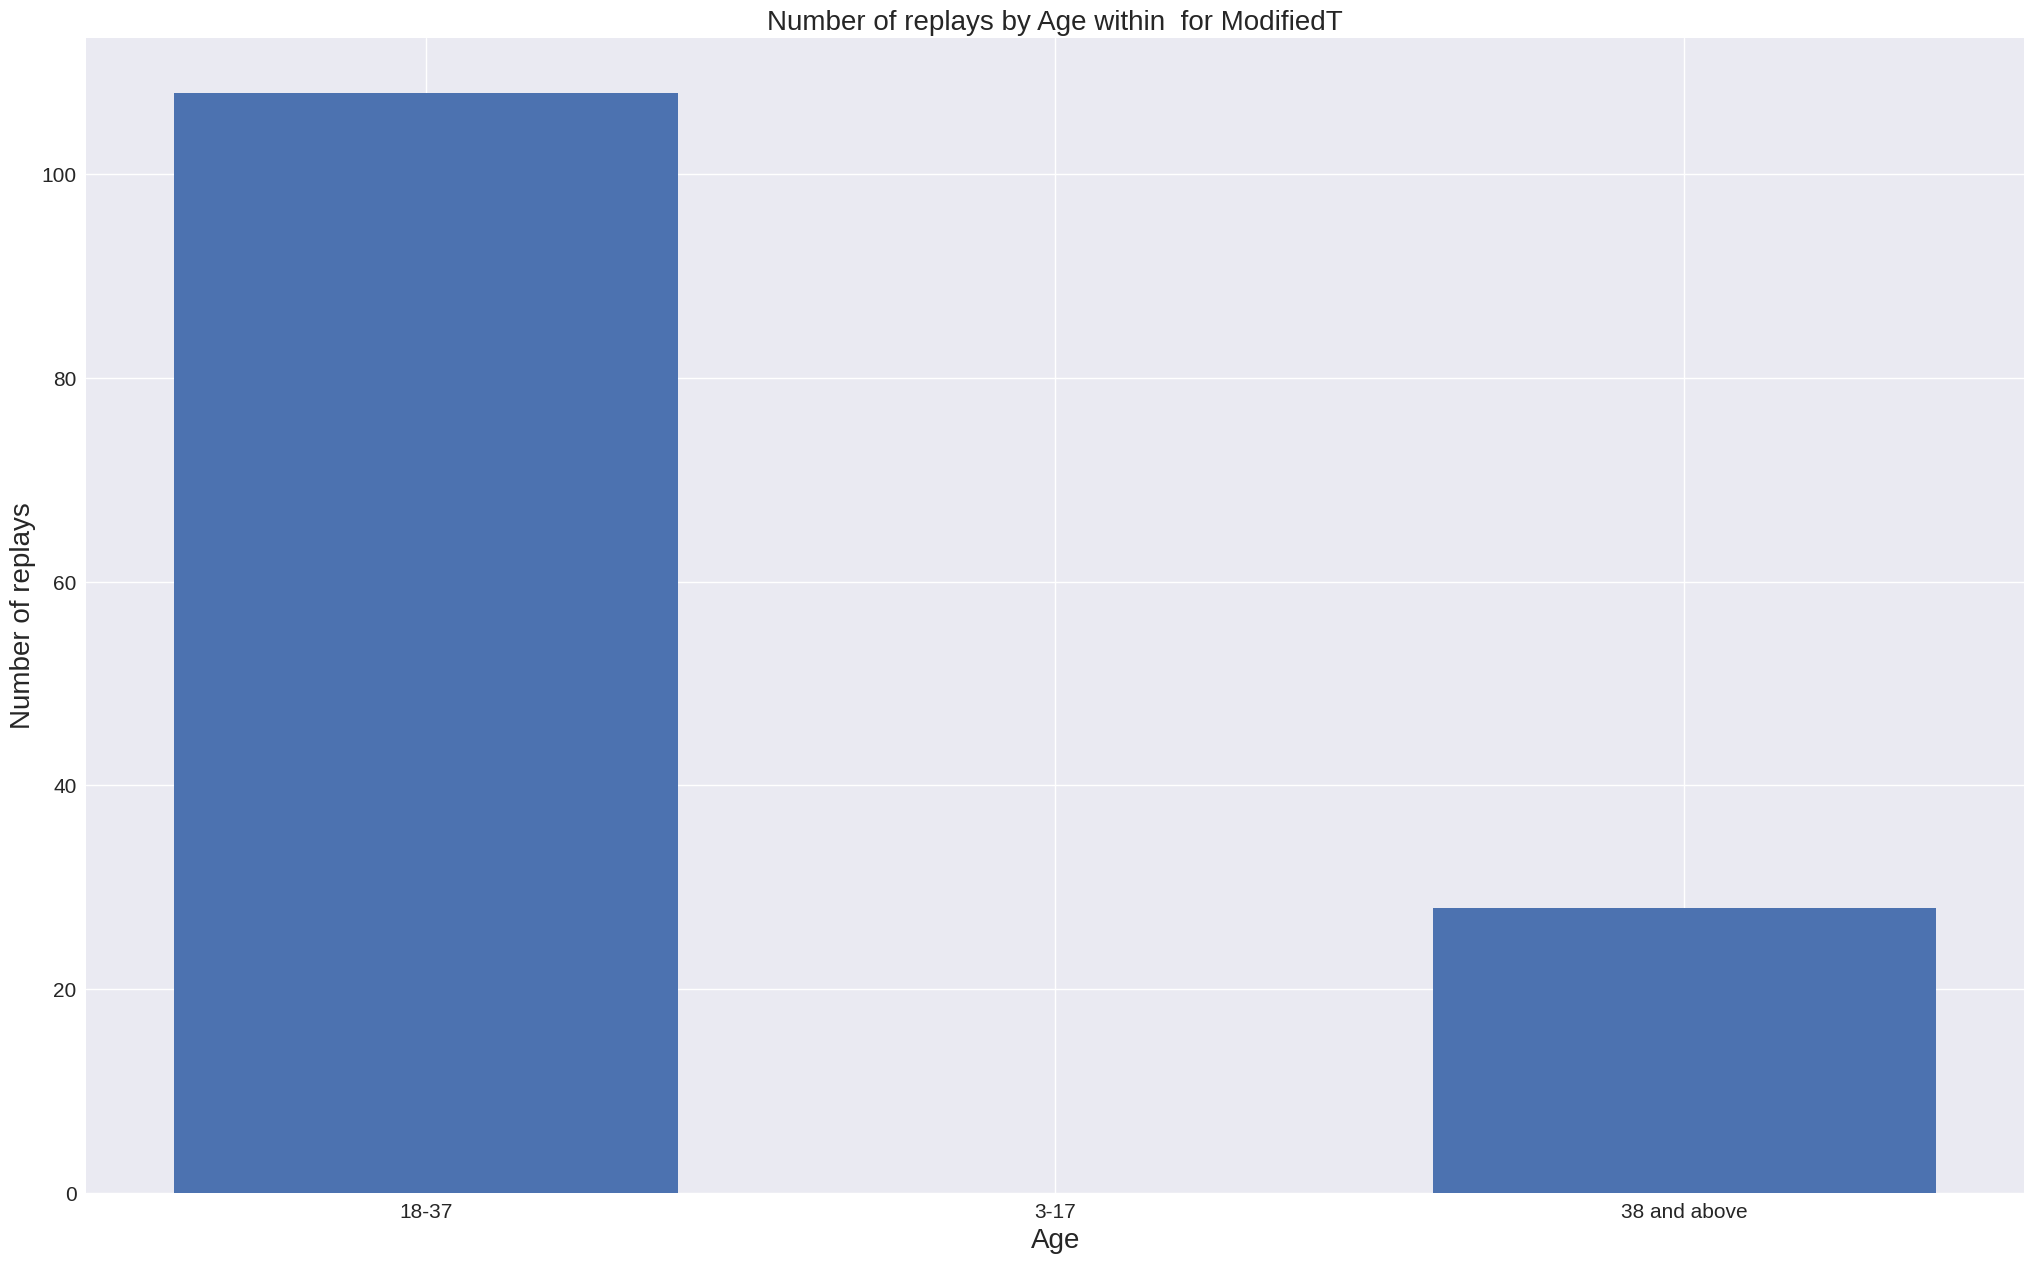

Age_group
18-37           83
3-17             0
38 and above    27
Name: Replay, dtype: int64


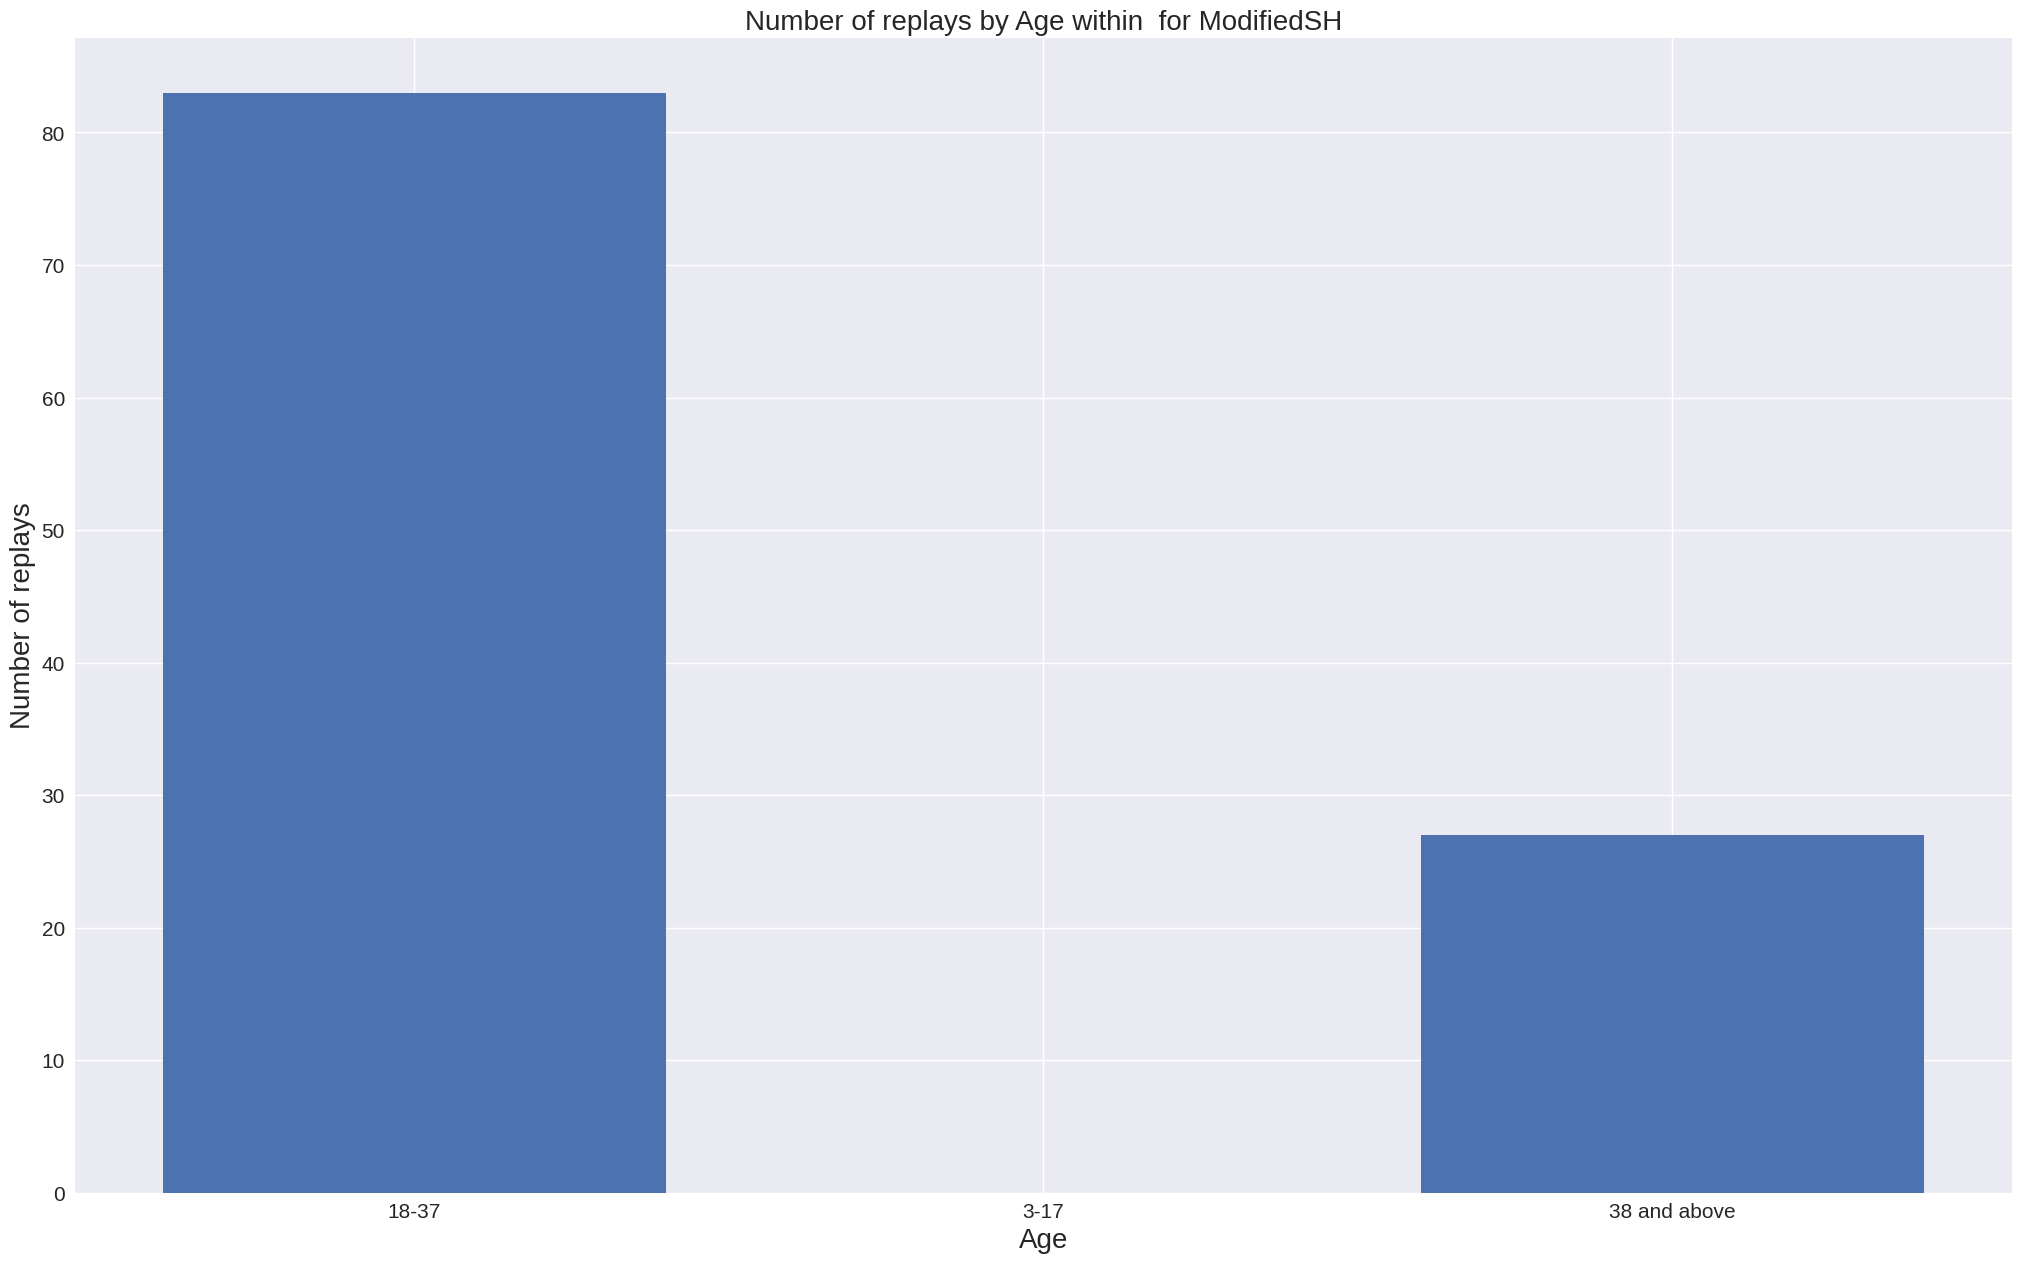

Irish
No         134
Notions      2
Name: Replay, dtype: int64


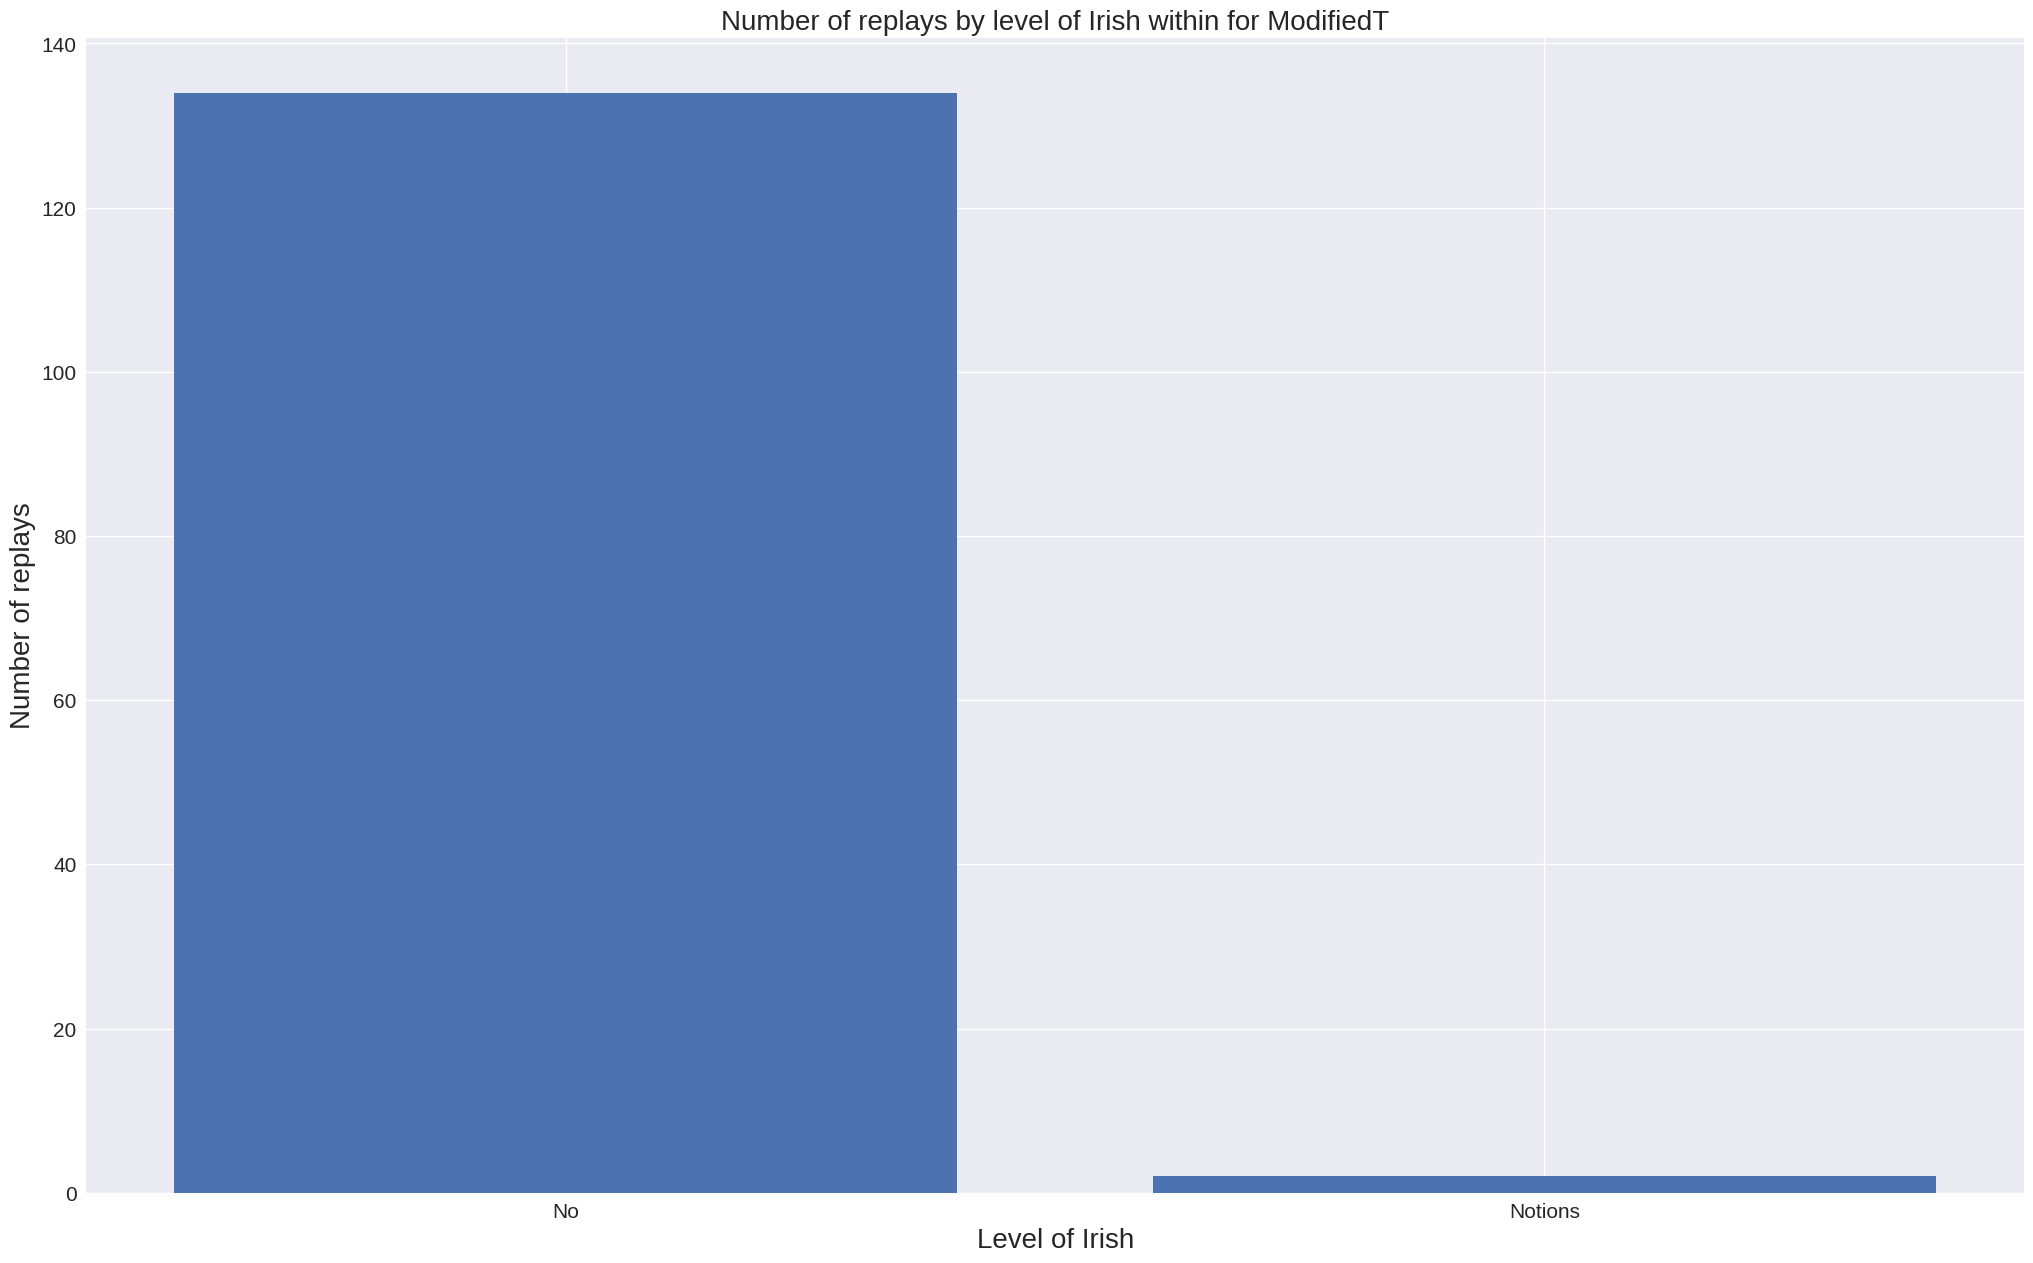

Irish
No         106
Notions      4
Name: Replay, dtype: int64


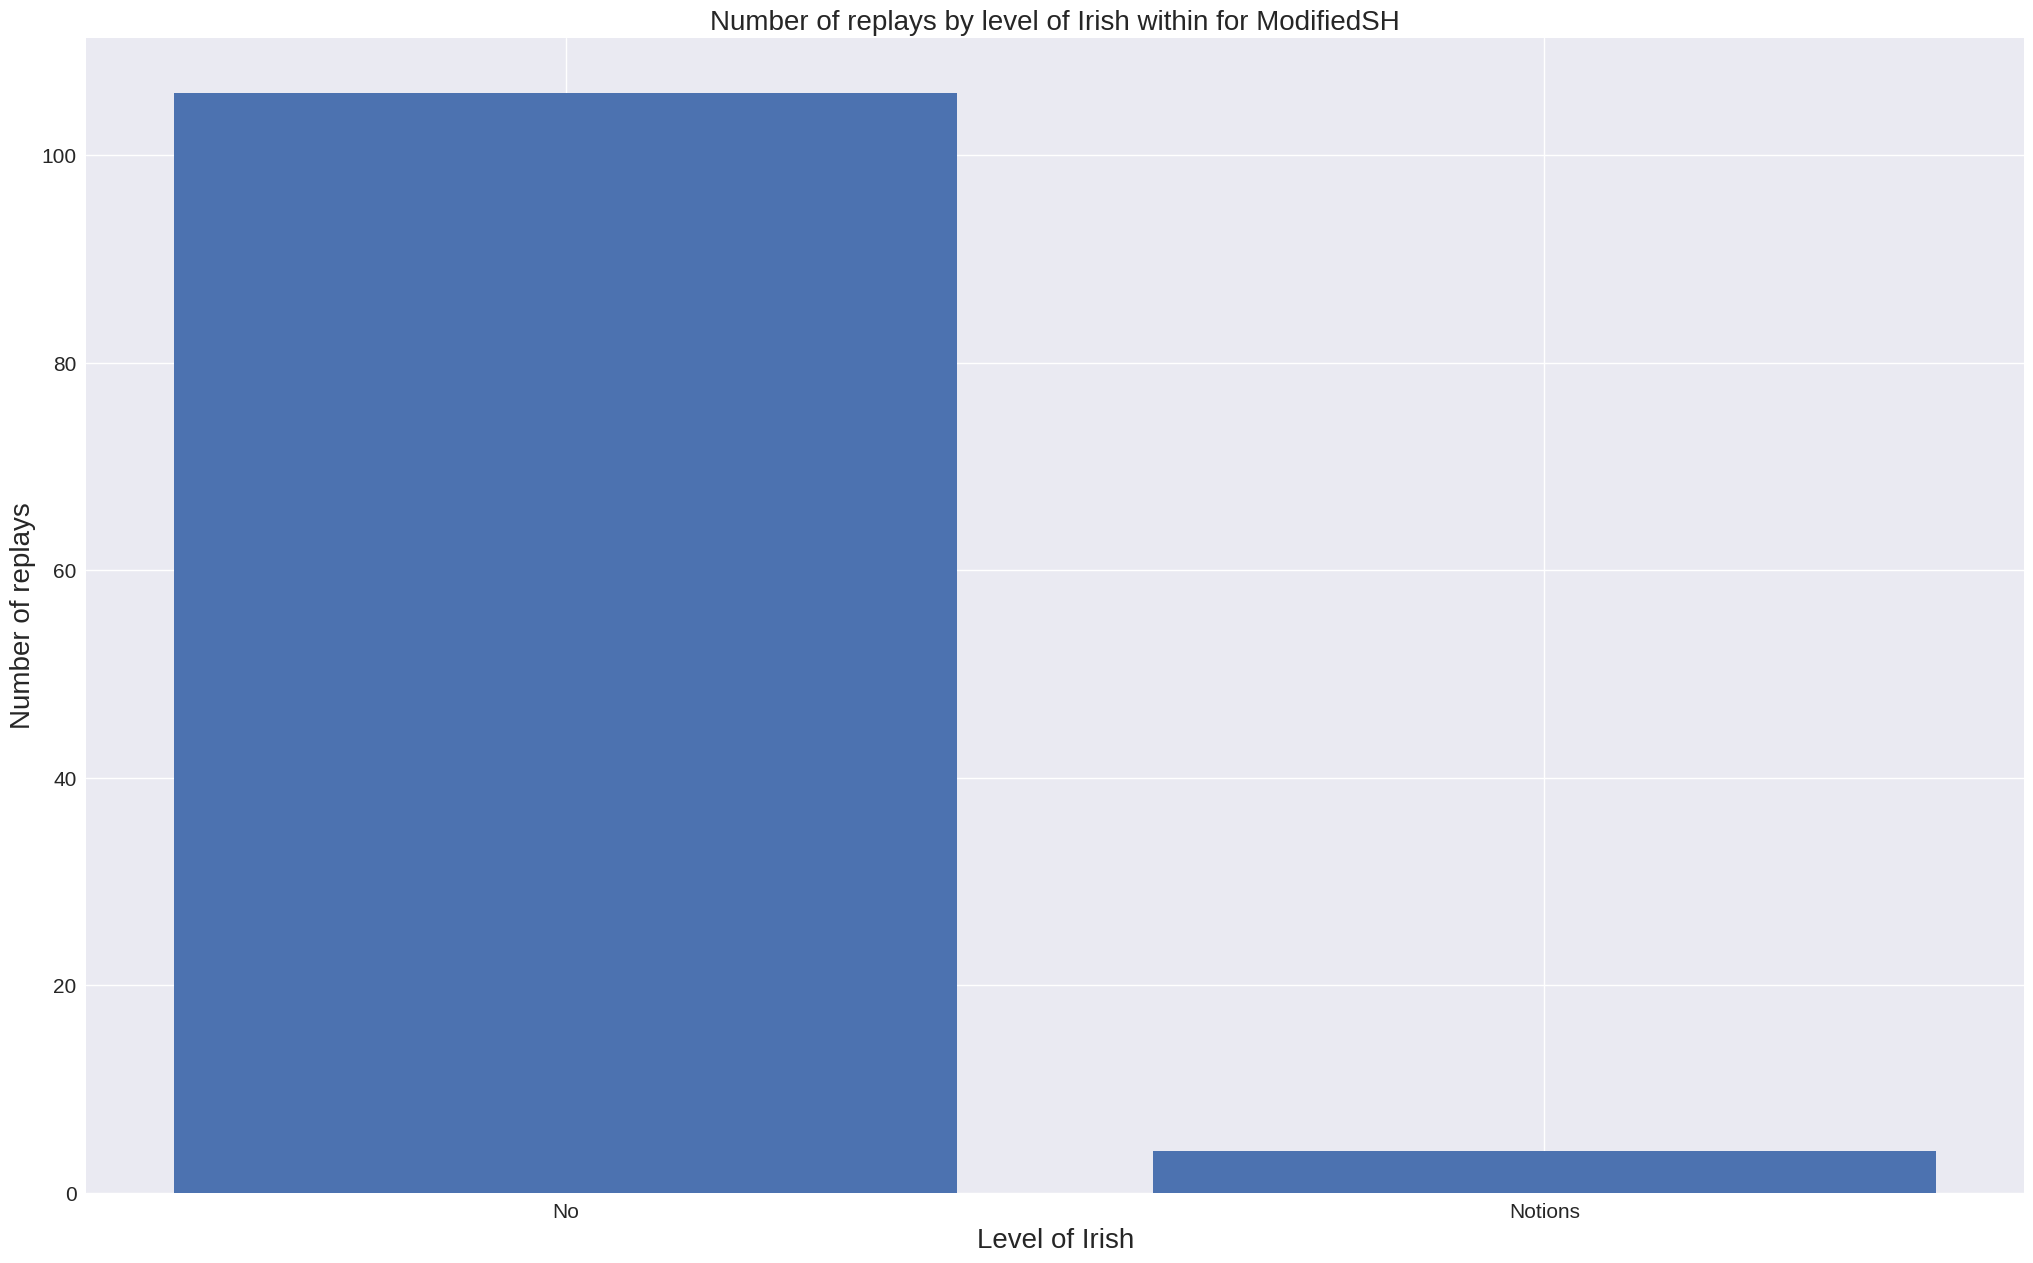

Condition1
ModifiedSH    110
ModifiedT     136
Name: Replay, dtype: int64


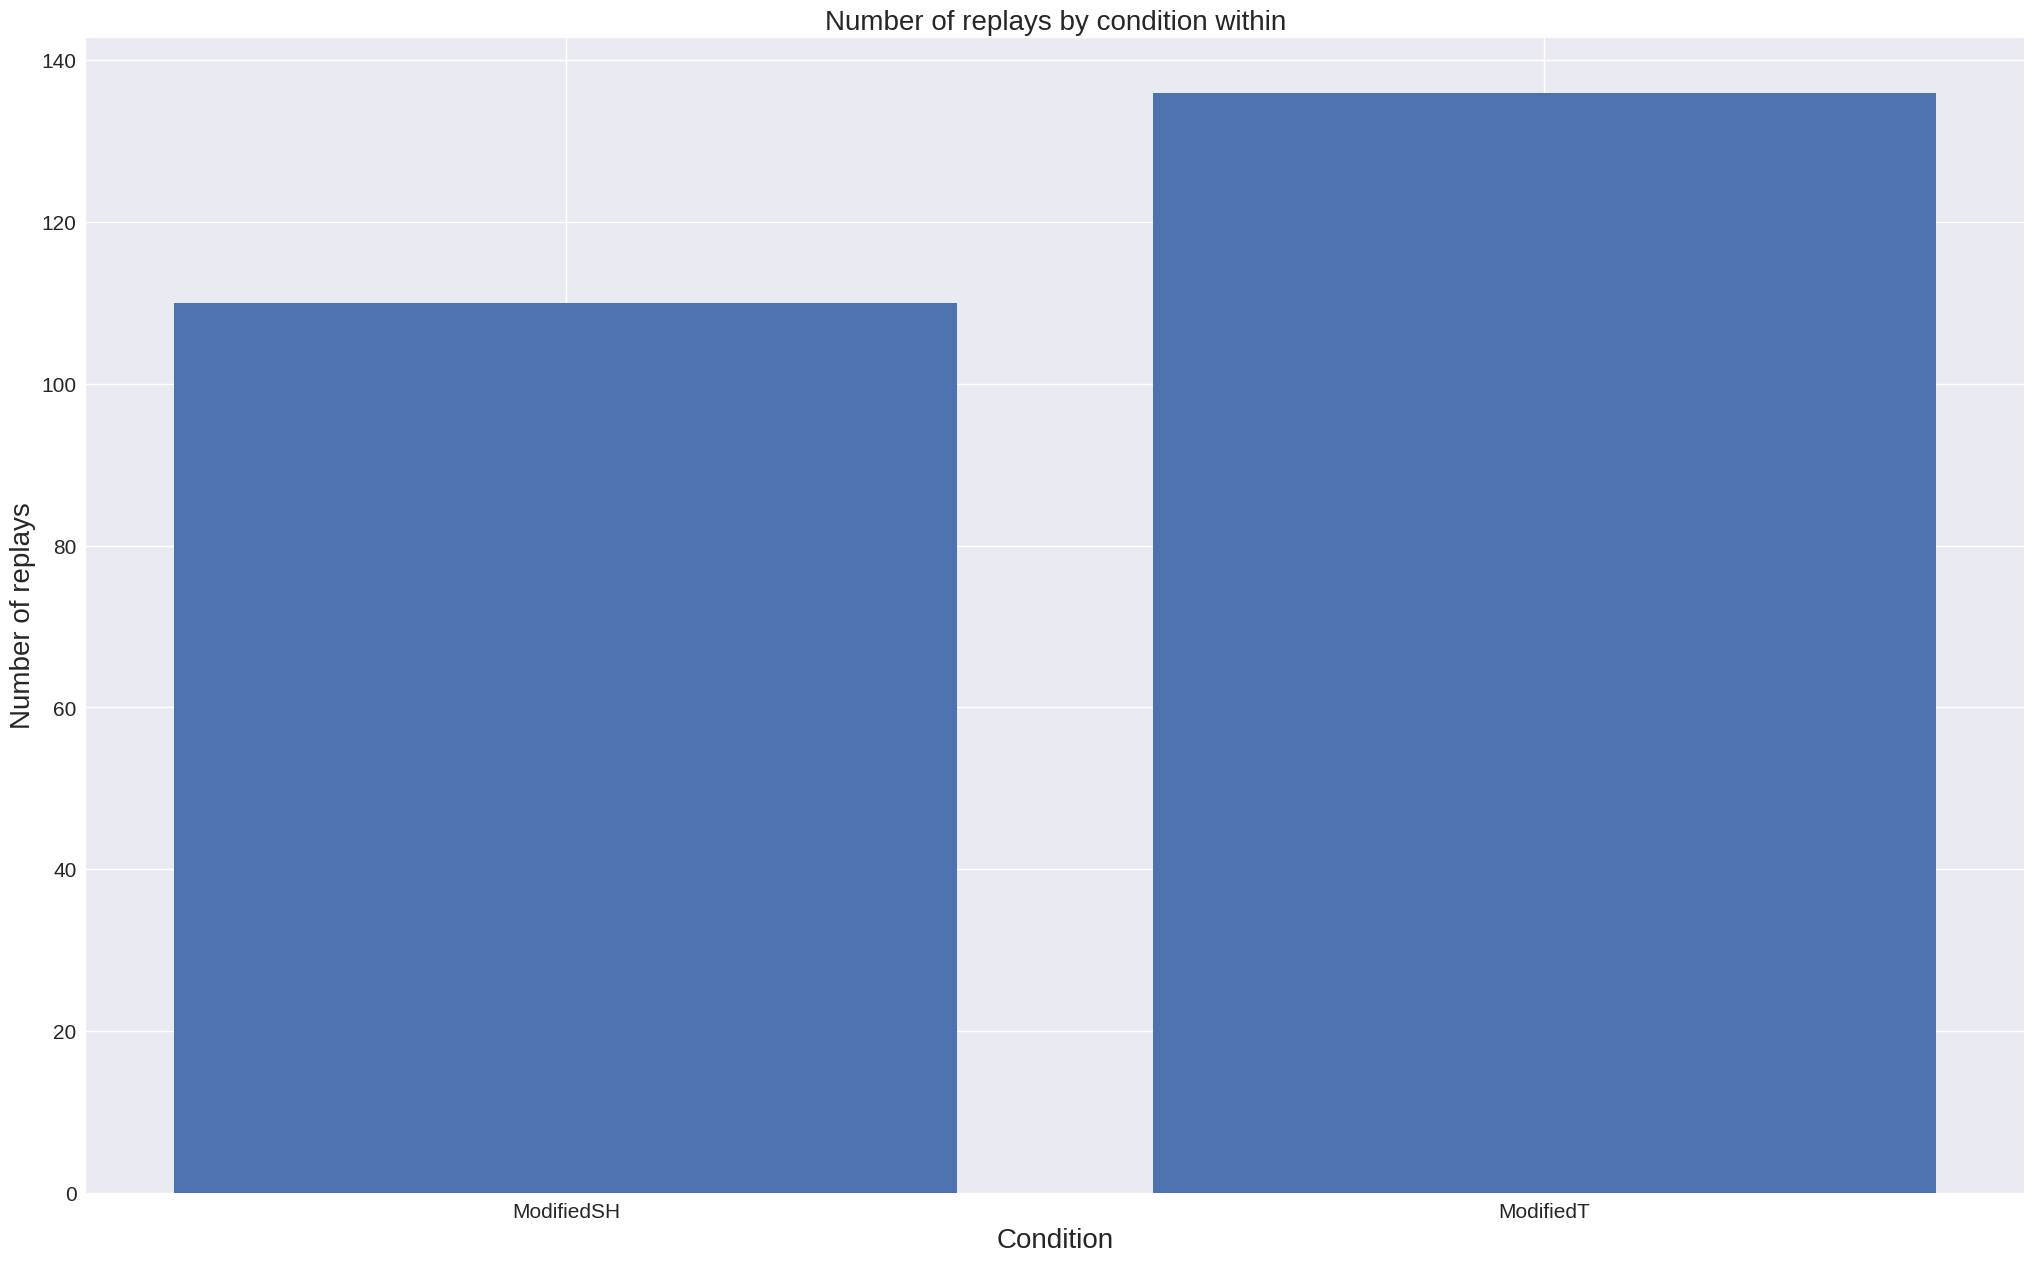

In [69]:
# @title Replay Count other english speaking countries

#-----------------------Gender
for x in condition:
    df = filter_withoutIrish[filter_withoutIrish['Condition1'] == x]
    plot_replay(df, x, 'Gender', 'Number of replays by Gender within for ', 'Gender')

#-----------------------Age
for x in condition:
    df = filter_withoutIrish[filter_withoutIrish['Condition1'] == x]
    plot_replay(df, x, 'Age_group', 'Number of replays by Age within  for ', 'Age')


#-----------------------Level Irish
for x in condition:
    df = filter_withoutIrish[filter_withoutIrish['Condition1'] == x]
    plot_replay(df, x, 'Irish', 'Number of replays by level of Irish within for ', 'Level of Irish')

#-----------------------Condition
plot_replay(filter_withoutIrish, '', 'Condition1', 'Number of replays by condition within', 'Condition')



Gender
F    17
M    33
Name: Replay, dtype: int64


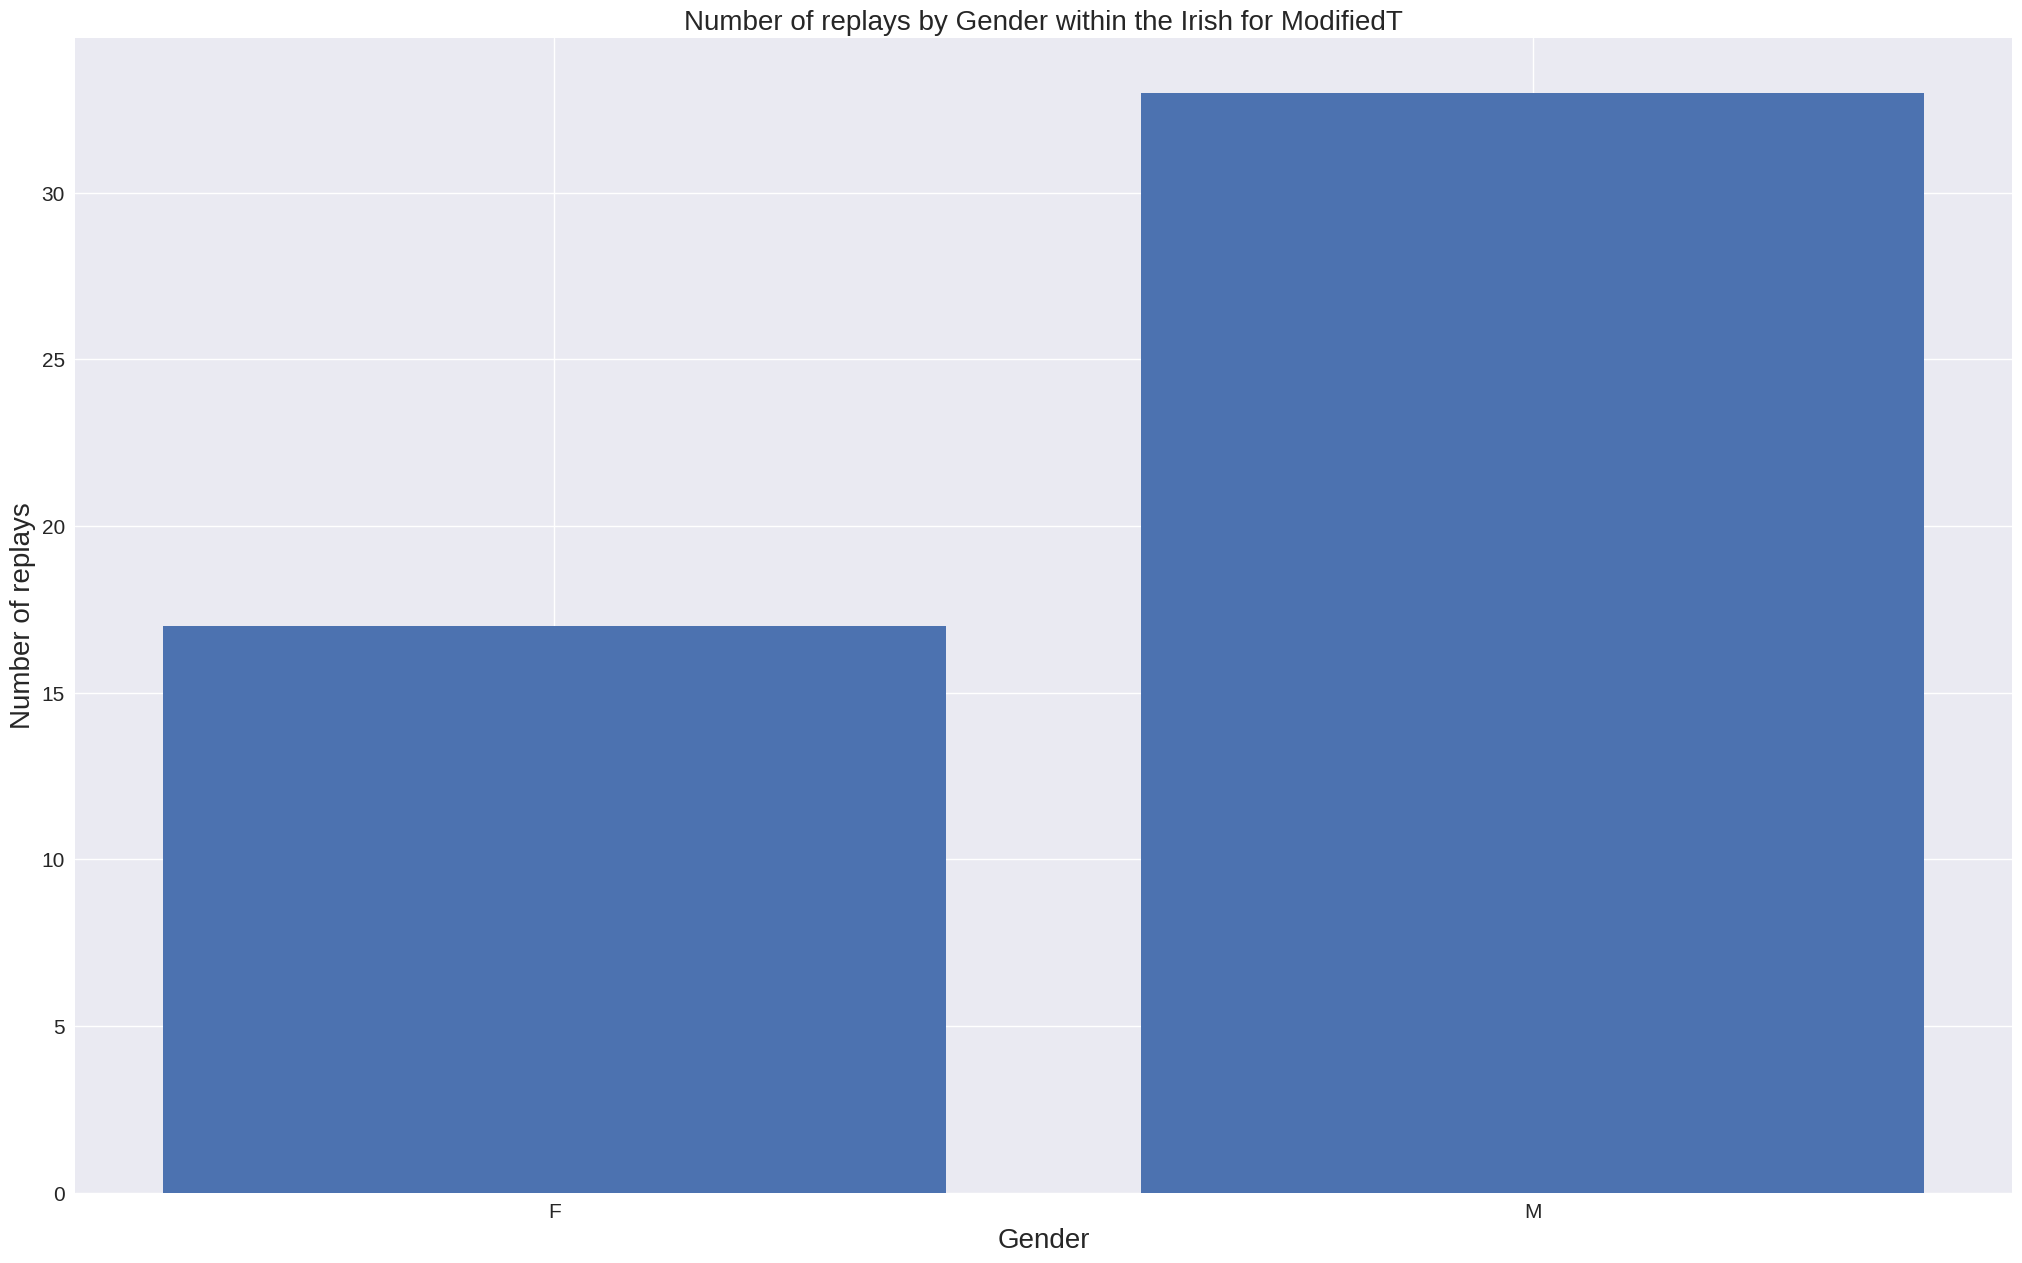

Gender
F    20
M    32
Name: Replay, dtype: int64


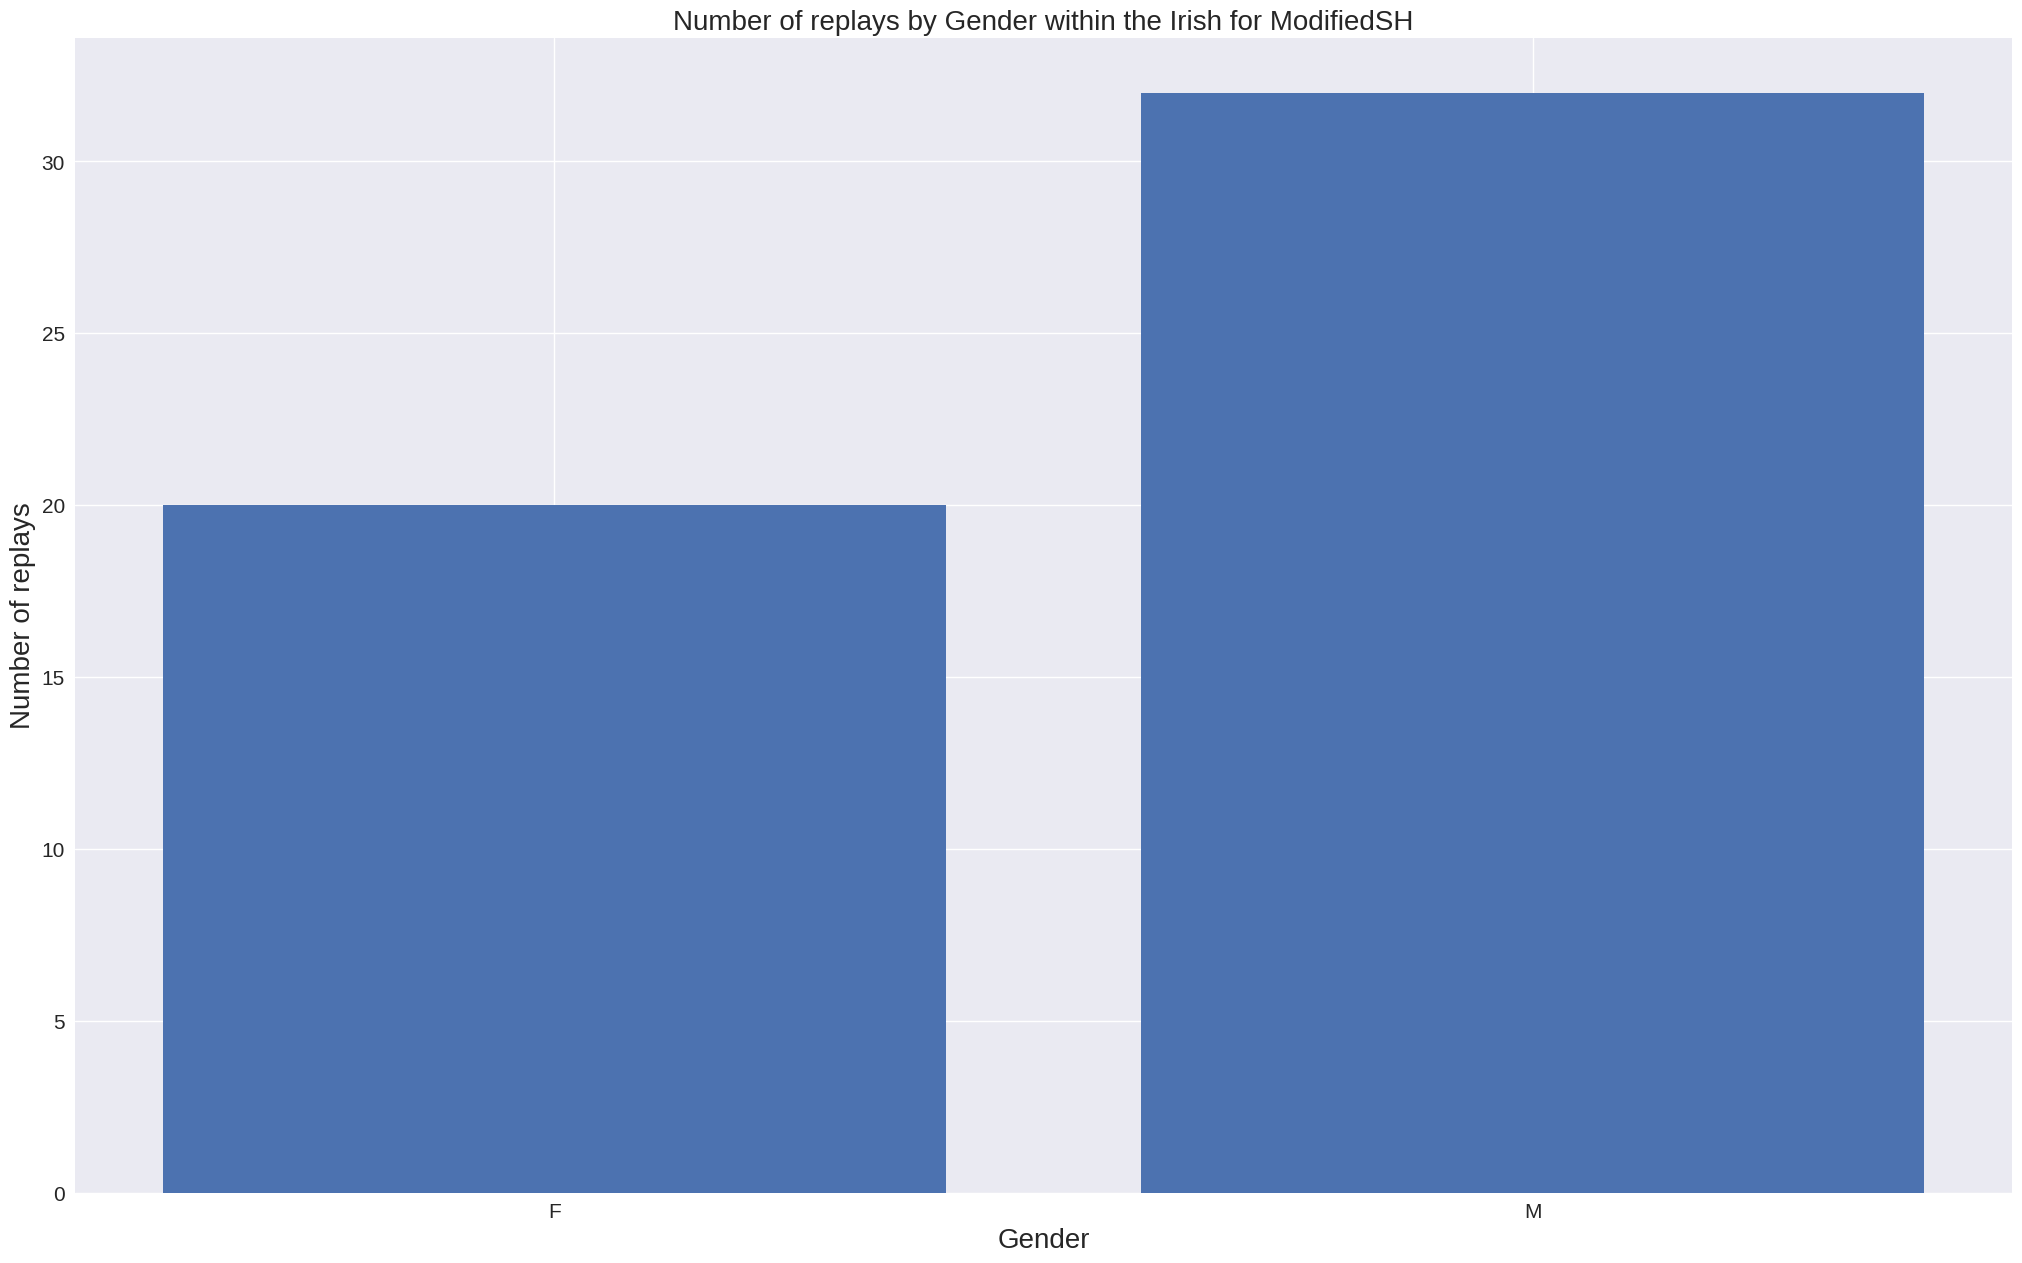

Age_group
18-37           42
38 and above     8
Name: Replay, dtype: int64


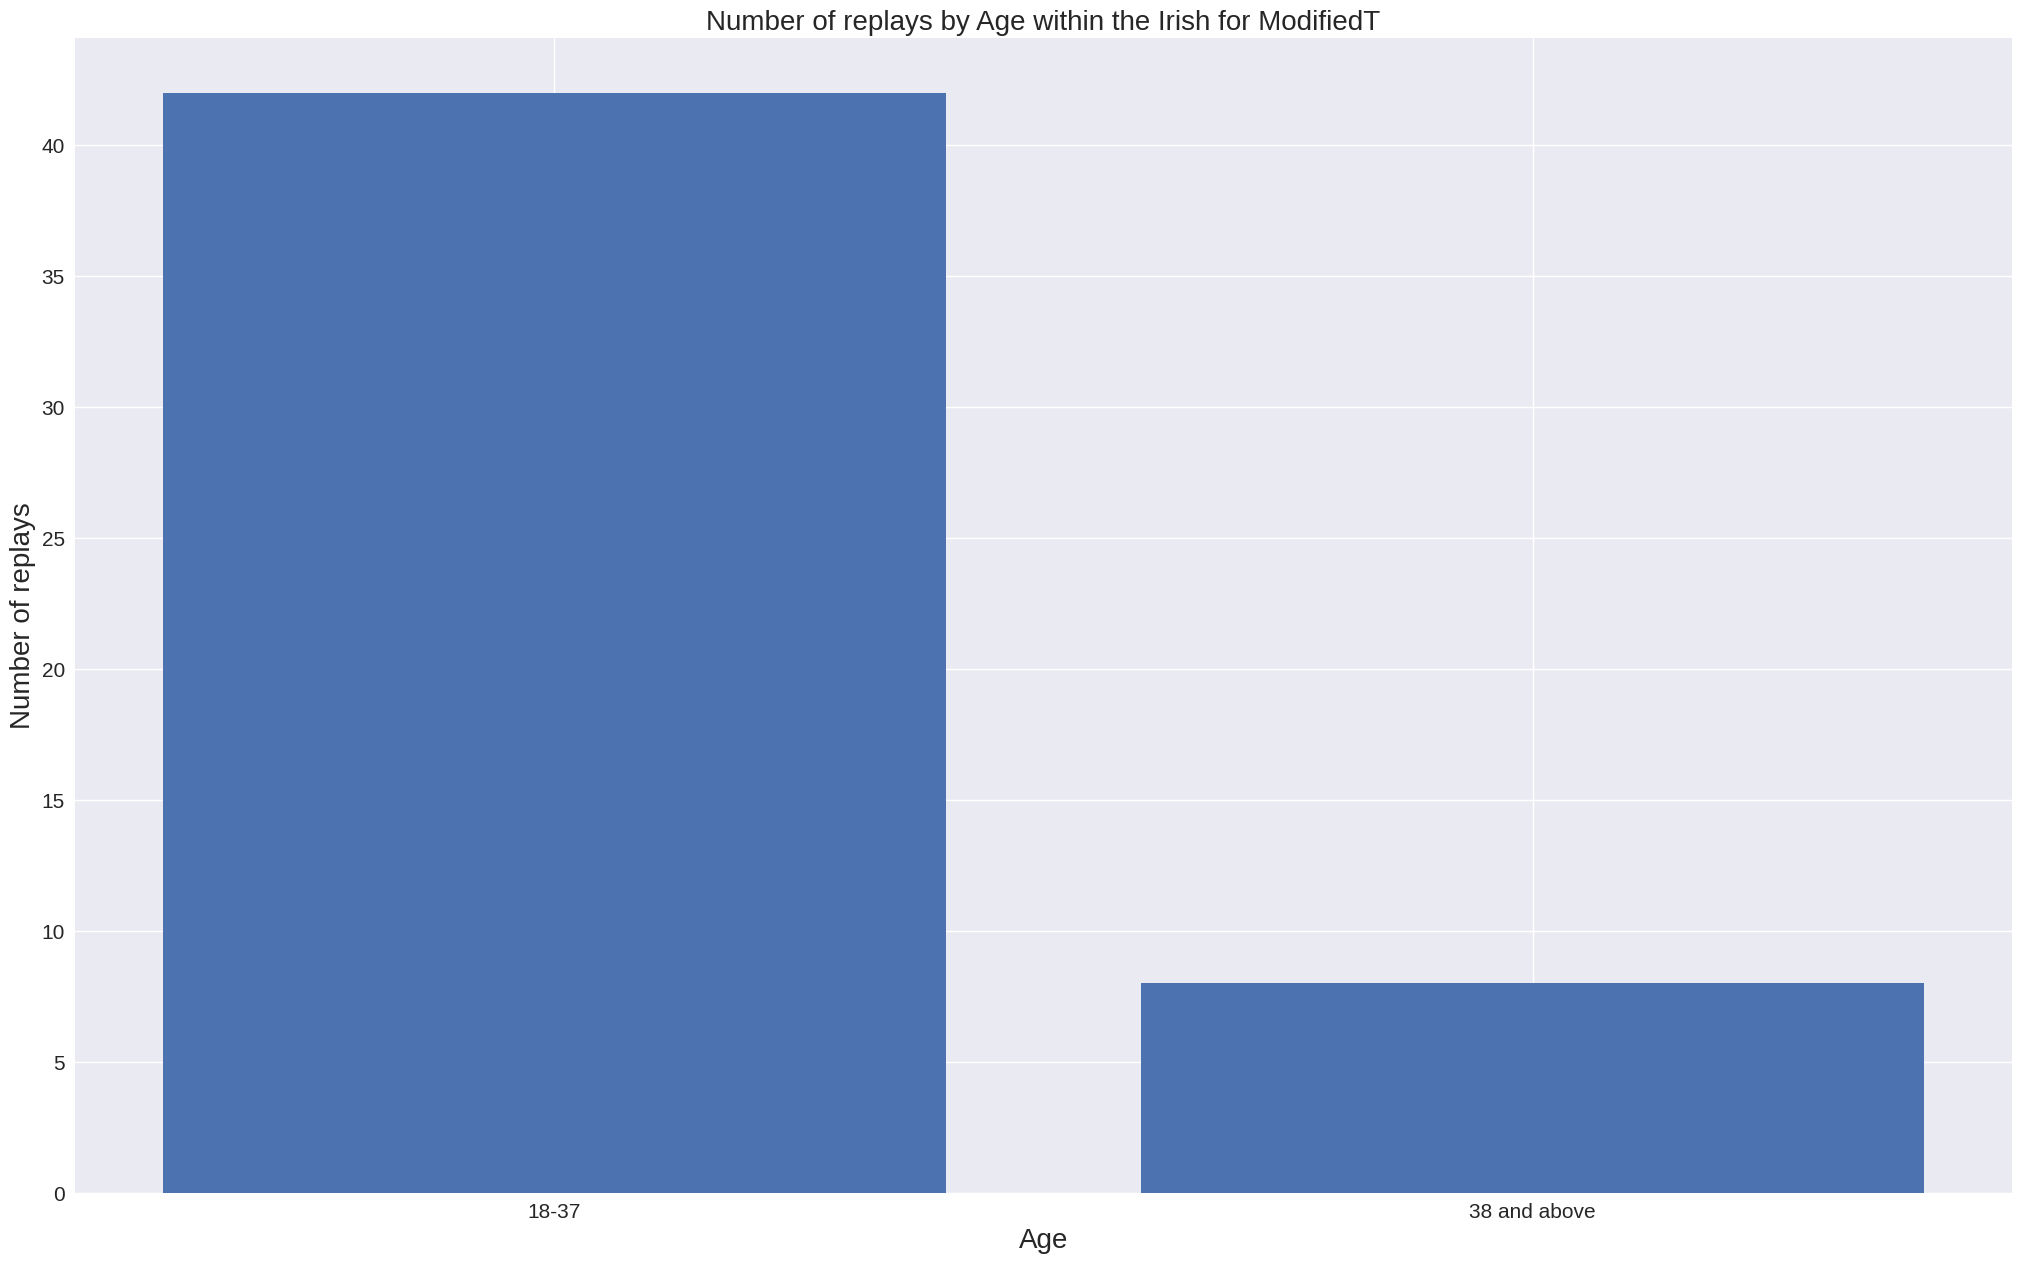

Age_group
18-37           41
38 and above    11
Name: Replay, dtype: int64


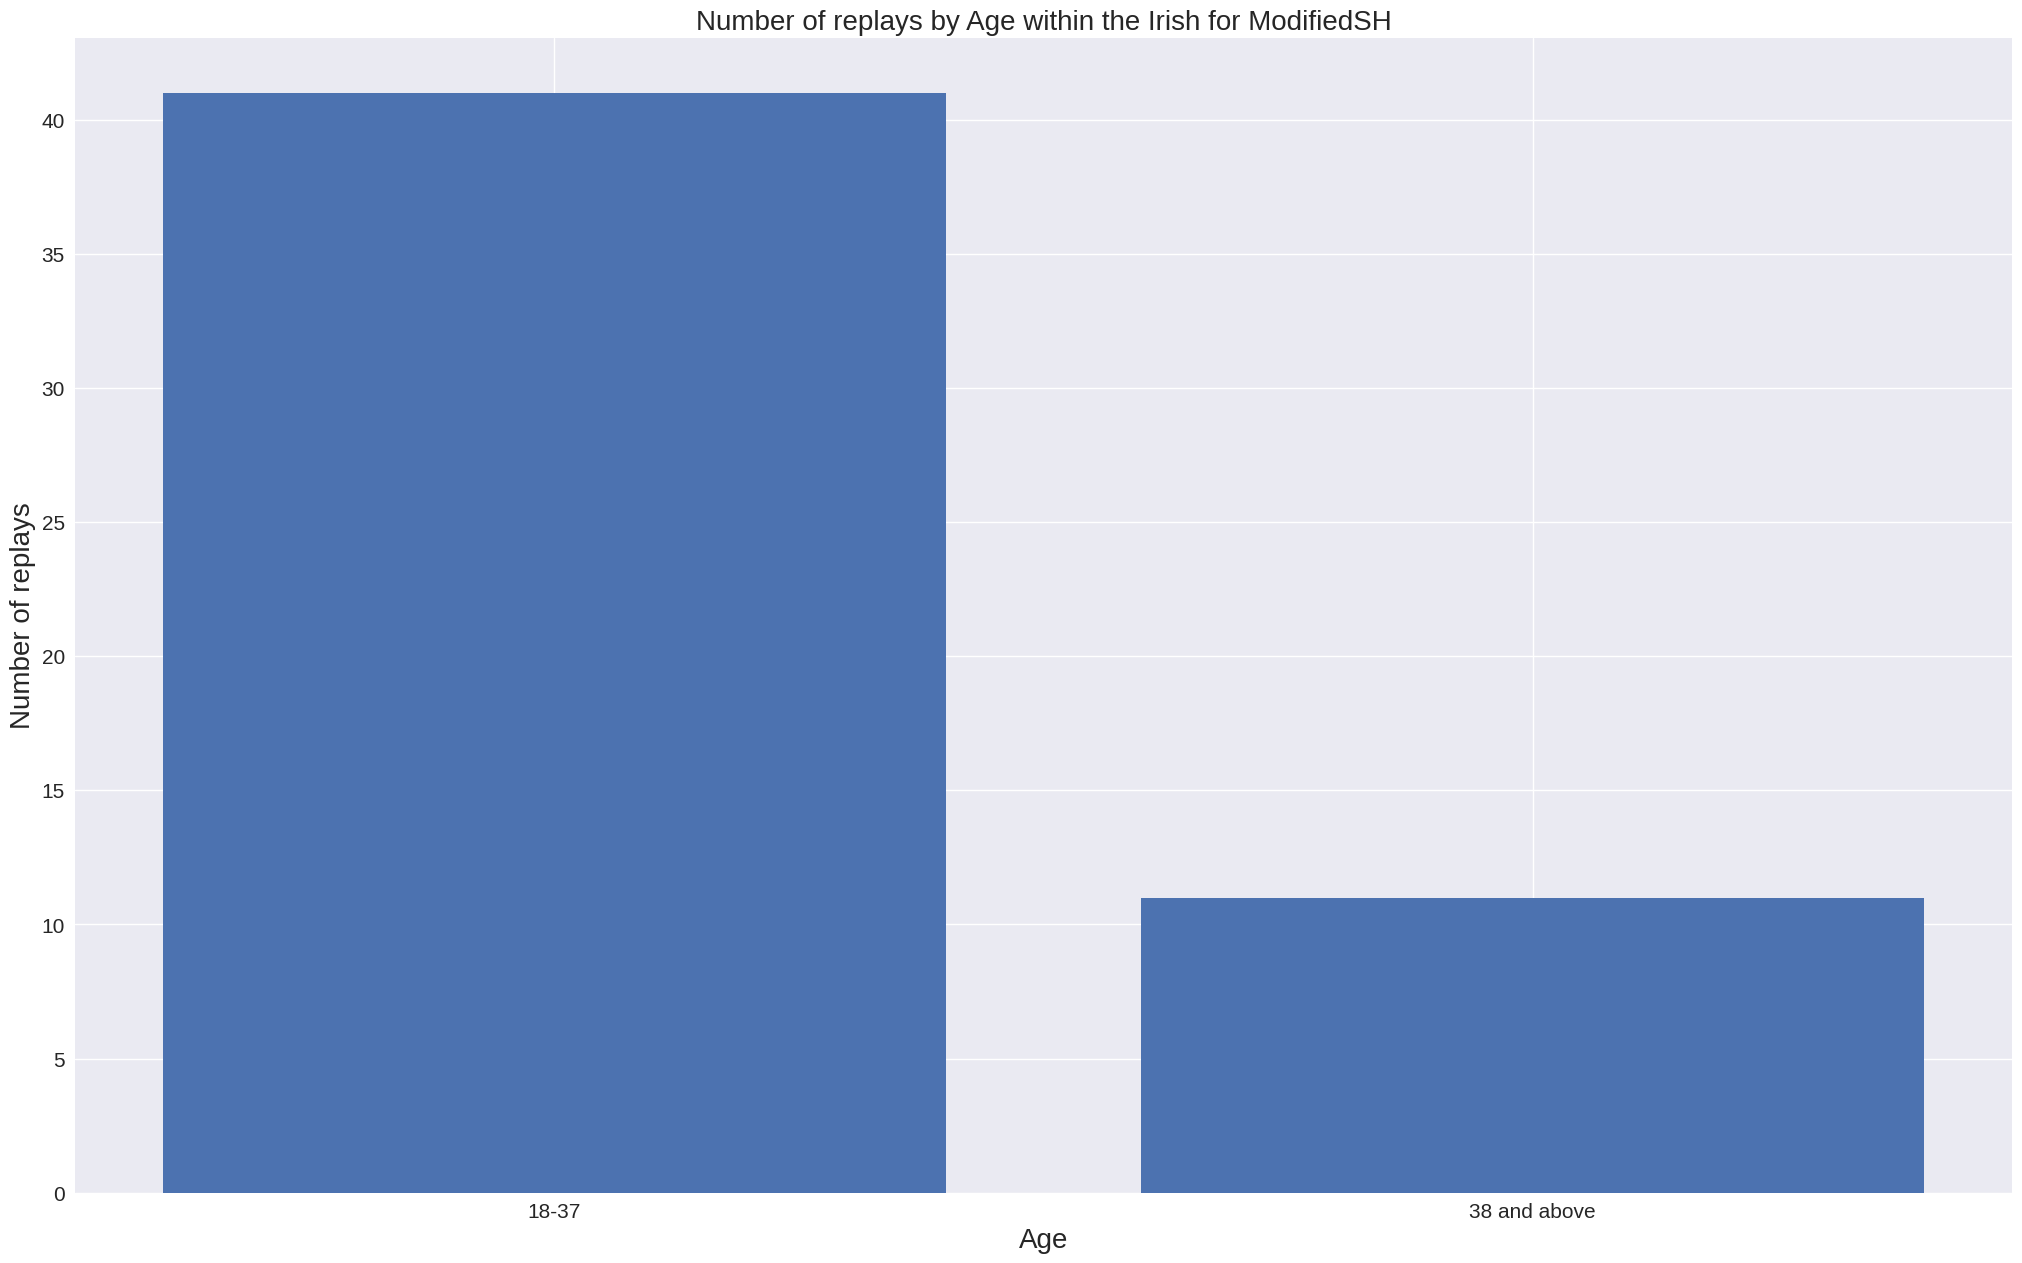

Irish
No         25
Notions     6
Yes        19
Name: Replay, dtype: int64


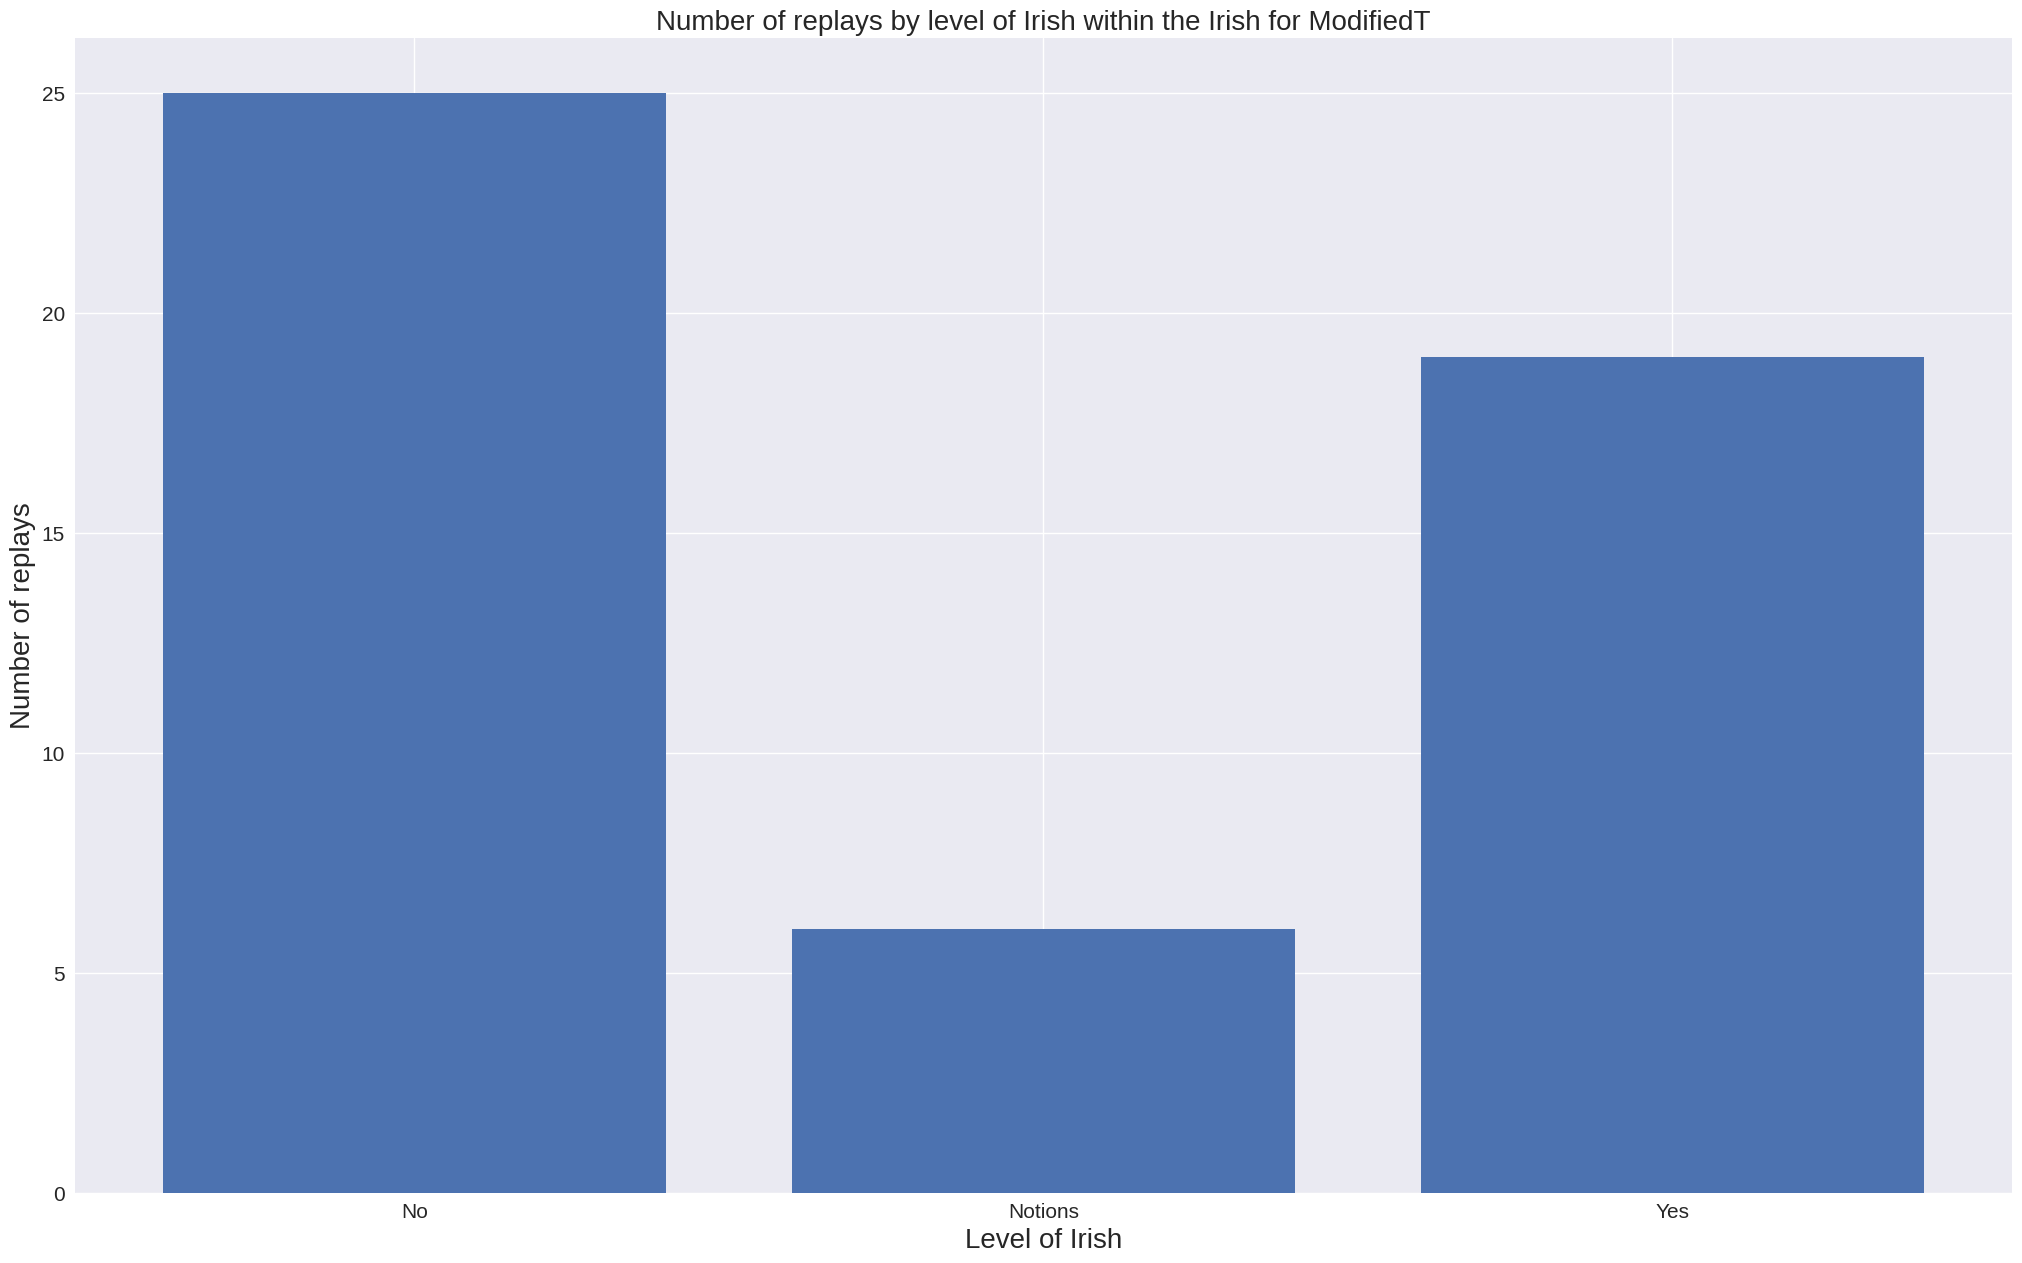

Irish
No         21
Notions     2
Yes        29
Name: Replay, dtype: int64


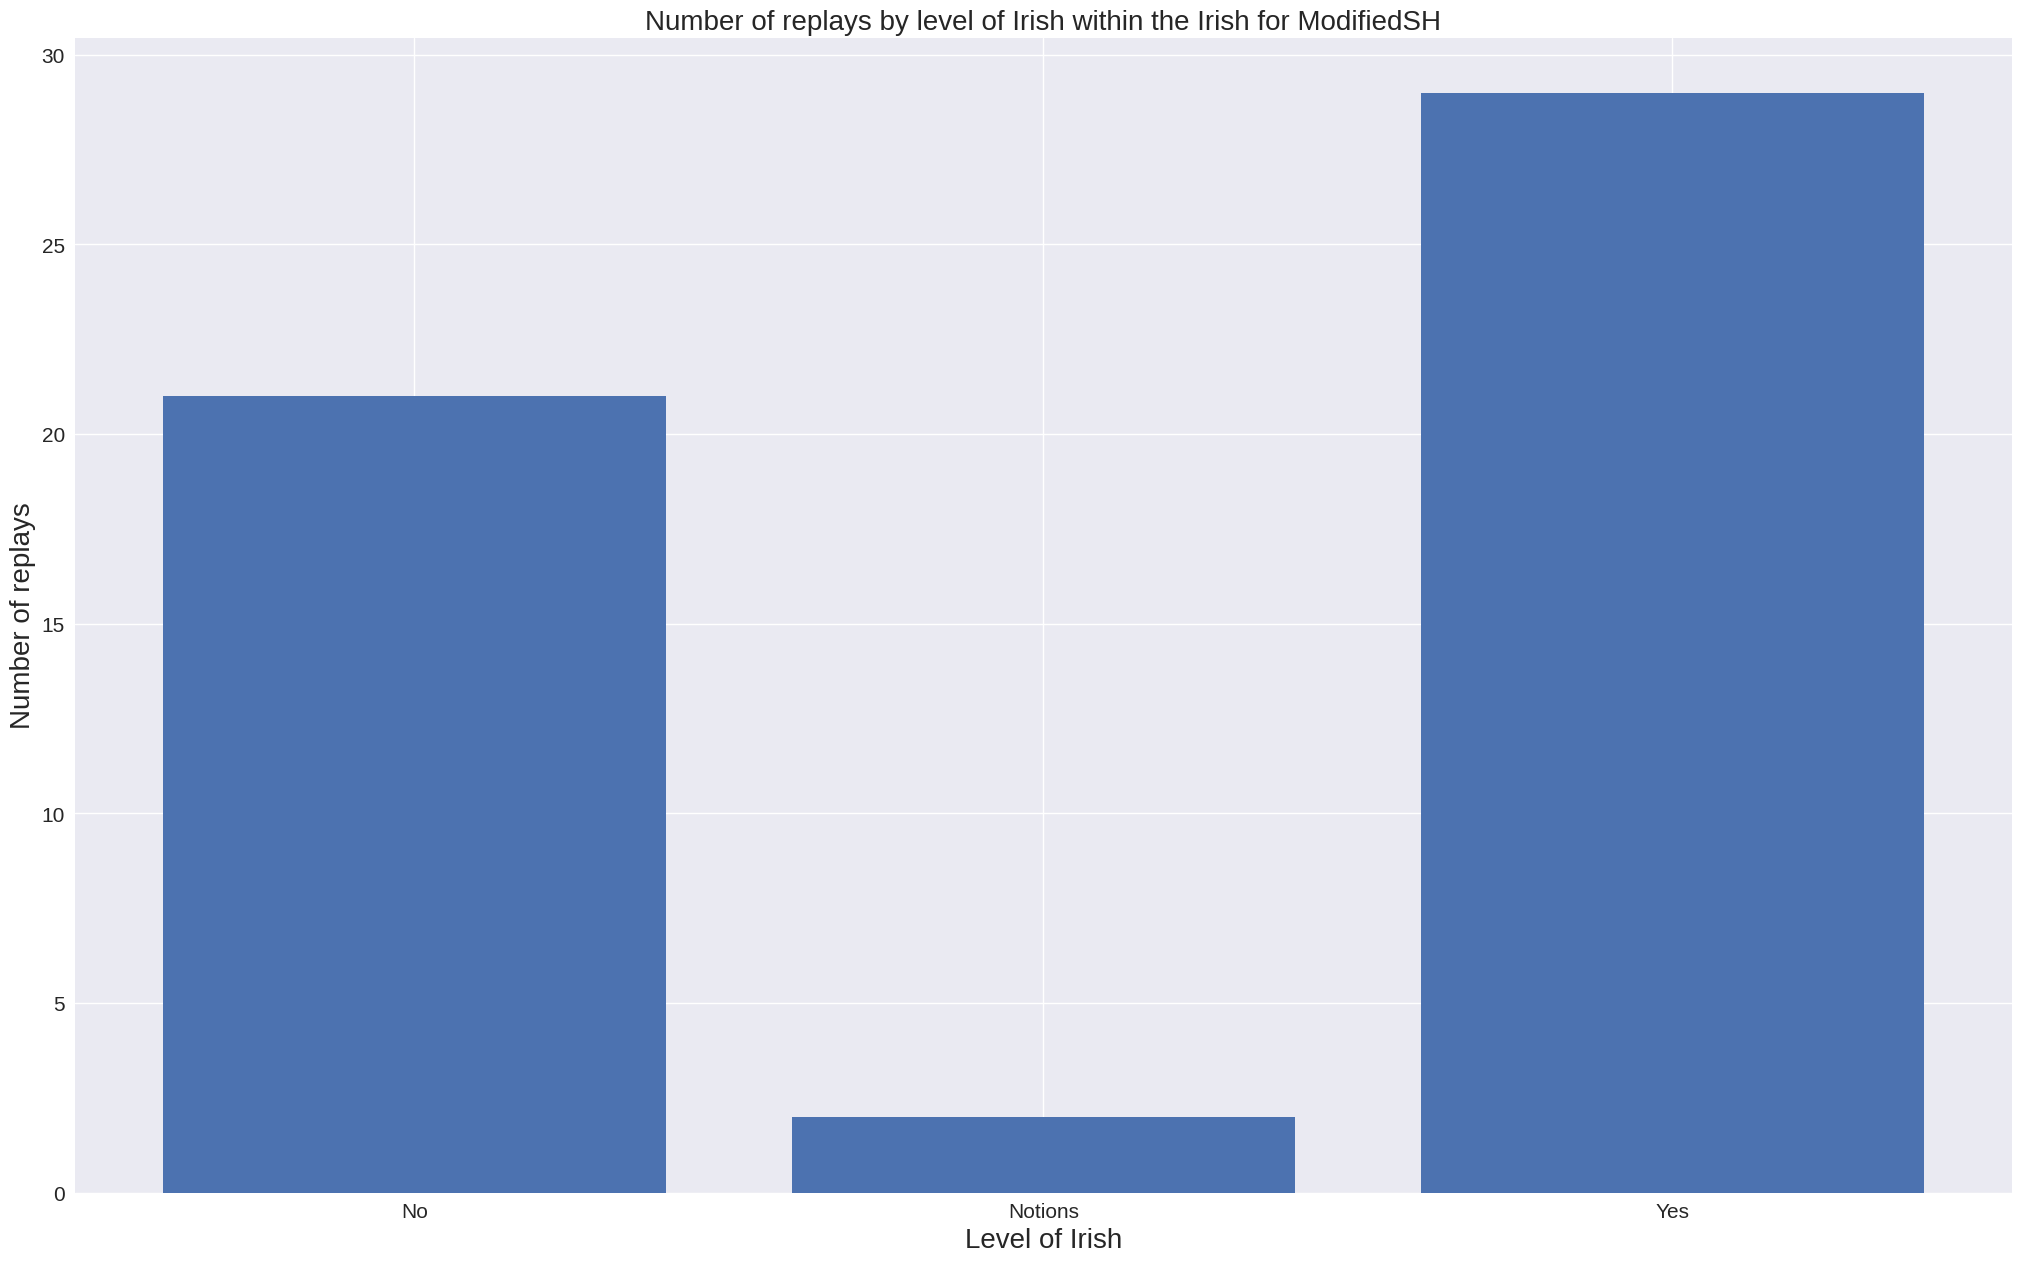

Condition1
ModifiedSH    52
ModifiedT     50
Name: Replay, dtype: int64


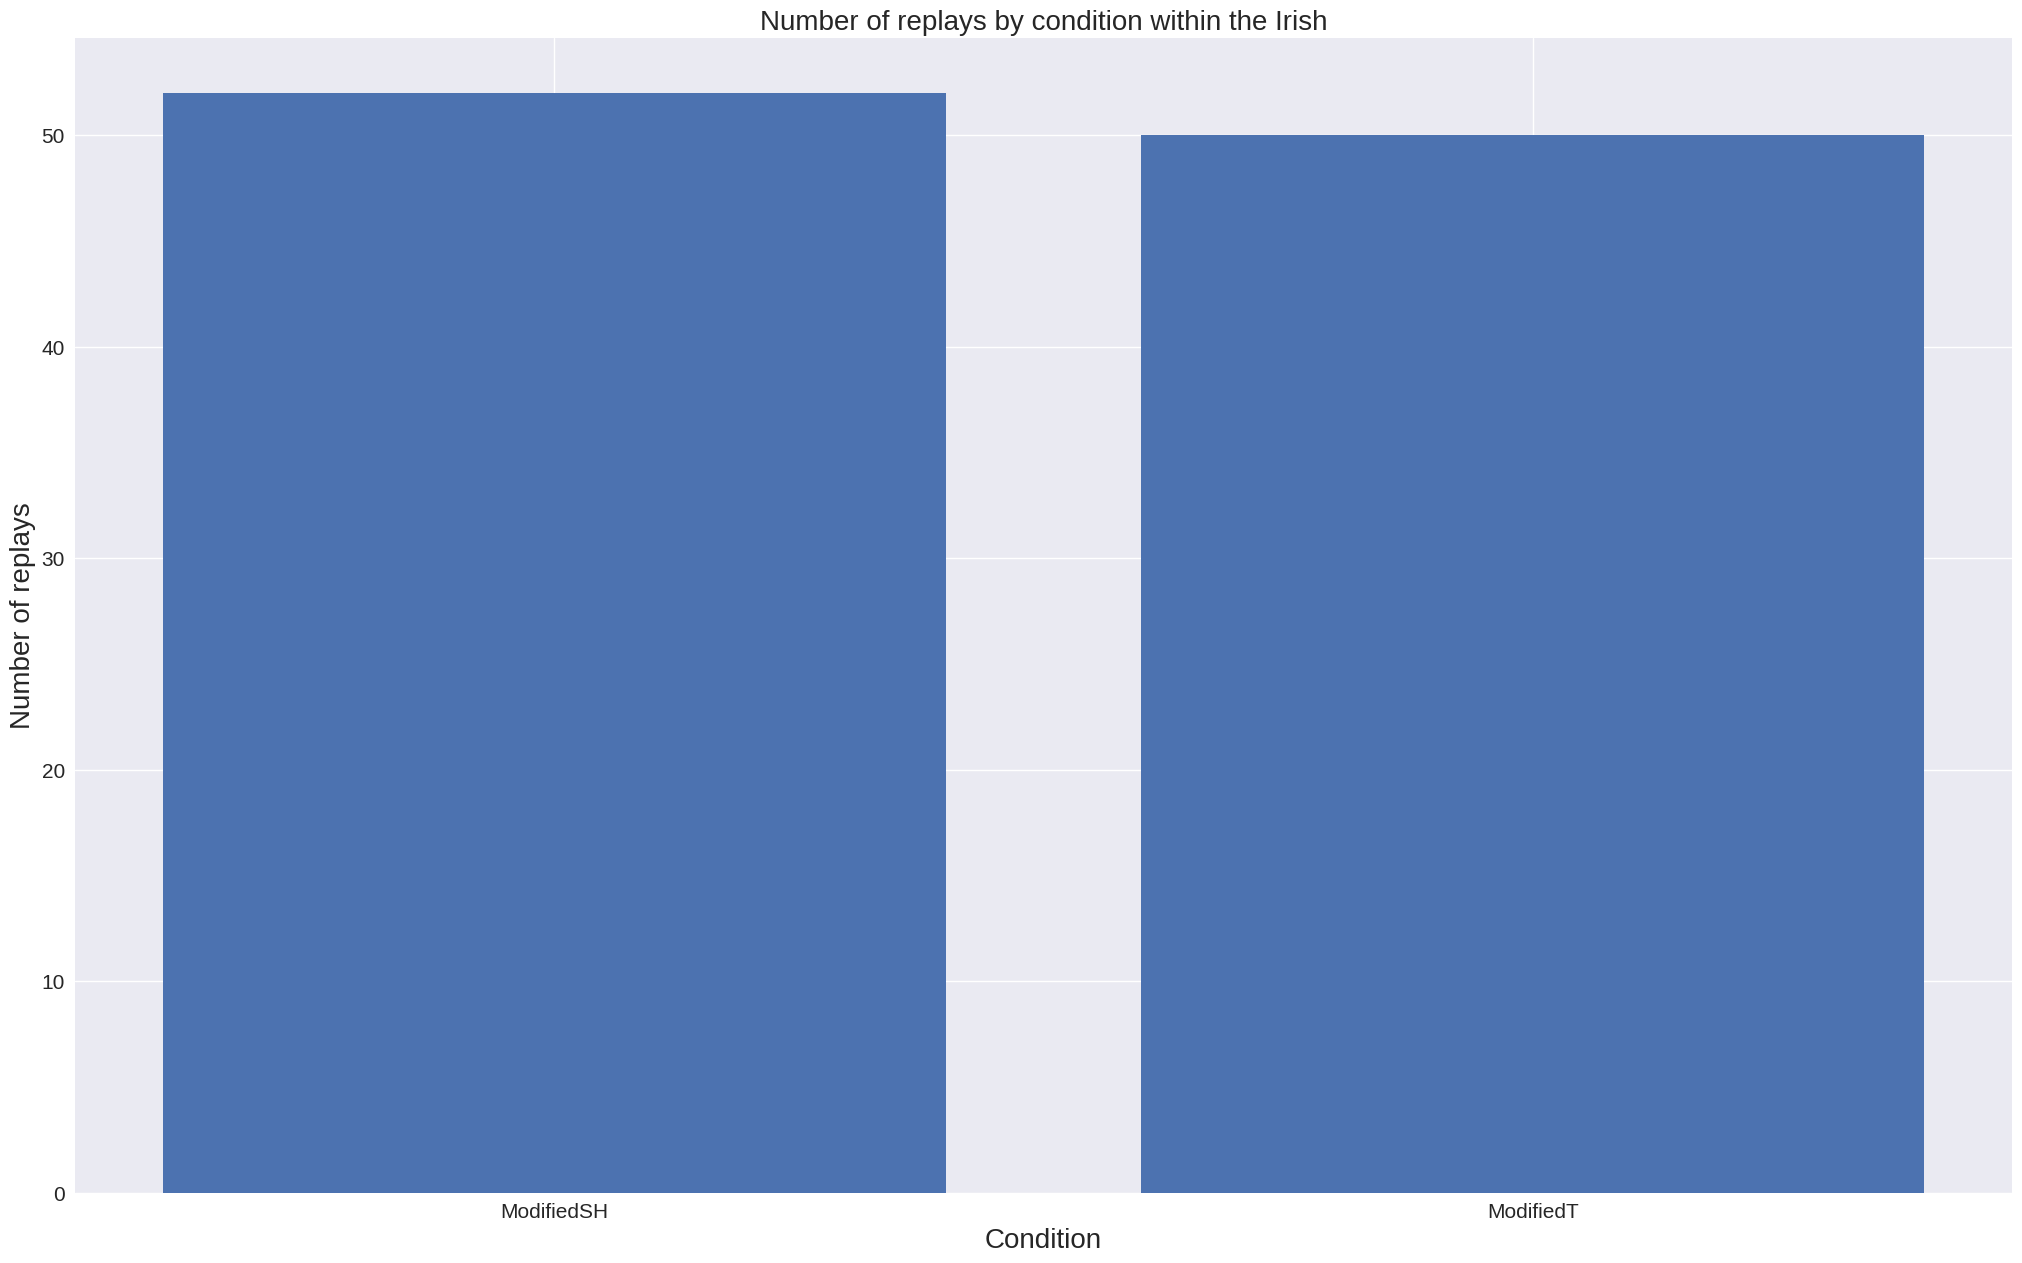

In [70]:
# @title Replay Count within irish

#-----------------------Gender
for x in condition:
    df = filter_withinIrish[filter_withinIrish['Condition1'] == x]
    plot_replay(df, x, 'Gender', 'Number of replays by Gender within the Irish for ', 'Gender')

#-----------------------Age
for x in condition:
    df = filter_withinIrish[filter_withinIrish['Condition1'] == x]
    plot_replay(df, x, 'Age_group', 'Number of replays by Age within the Irish for ', 'Age')


#-----------------------Level Irish
for x in condition:
    df = filter_withinIrish[filter_withinIrish['Condition1'] == x]
    plot_replay(df, x, 'Irish', 'Number of replays by level of Irish within the Irish for ', 'Level of Irish')

#-----------------------Condition
plot_replay(filter_withinIrish, '', 'Condition1', 'Number of replays by condition within the Irish', 'Condition')

